## CAPSTONE ASSIGNMENT PART 3:

1. Create a "progress report" that documents:
   - Your approach to exploratory data analysis
   - Your initial results
   - Any roadblocks, setbacks, or surprises
2. Perform initial descriptive and visual analysis of your data.
   - Identify outliers
   - Summarize risks and limitations
3. Discuss your proposed next steps
   - Describe how your EDA will inform your modeling decisions
   - What are three concrete actions you need to take next?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [618]:
#reading in my data
df = pd.read_csv('cleaned_politifact_df',index_col=0)

In [619]:
#verifying that the dataframe looks correct
df.head()

edition                                          statement statement_type  \
0     Texas  "The attorney general requires that rape victi...          Claim   
1  National  President Clinton "reduced the scale of our mi...          Claim   
2  National  "New Mexico was 46th in teacher pay (when he w...          Claim   
3  National  "I used tax cuts to help create over 80,000 jo...          Claim   
4  National  New Mexico moved "up to" sixth in the nation i...          Claim   

                      statement_context                speaker speaker_party  \
0                   in a Web site video  Barbara Ann Radnofsky      Democrat   
1  a Republican debate in Orlando, Fla.            Mitt Romney    Republican   
2                              a TV ad.        Bill Richardson      Democrat   
3                              a TV Ad.        Bill Richardson      Democrat   
4                              a TV Ad.        Bill Richardson      Democrat   

       speaker_job              subject          ruling        date  \
0              NaN                Crime  Pants on Fire!  2009-10-22   
1  Former governor             Military       Half-True  2007-10-21   
2         Governor            Education     Mostly True  2007-05-10   
3         Governor                Taxes     Mostly True  2007-05-10   
4         Governor  Job Accomplishments     Mostly True  2007-05-10   

  edition_type  binary_ruling       simple_context simple_job  
0        State          False  in a Web site video        NaN  
1     National           True             a debate   Governor  
2     National           True              a TV ad   Governor  
3     National           True             a TV Ad.   Governor  
4     National           True             a TV Ad.   Governor

In [620]:
#checking the data types
df.dtypes

edition              object
statement            object
statement_type       object
statement_context    object
speaker              object
speaker_party        object
speaker_job          object
subject              object
ruling               object
date                 object
edition_type         object
binary_ruling          bool
simple_context       object
simple_job           object
dtype: object

In [621]:
#converting the date column to datetime
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)

In [622]:
#verifying that the date column has been converted correctly
df.dtypes

edition                      object
statement                    object
statement_type               object
statement_context            object
speaker                      object
speaker_party                object
speaker_job                  object
subject                      object
ruling                       object
date                 datetime64[ns]
edition_type                 object
binary_ruling                  bool
simple_context               object
simple_job                   object
dtype: object

In [623]:
#the binary_ruling isn't really best thought of as a boolean variable -- 
#rather, the feature is a judgement about the truthfulness of the statement
#so, it's better to convert this to strings
df['binary_ruling'] = df['binary_ruling'].map(lambda x: str(x))

In [624]:
df.dtypes

edition                      object
statement                    object
statement_type               object
statement_context            object
speaker                      object
speaker_party                object
speaker_job                  object
subject                      object
ruling                       object
date                 datetime64[ns]
edition_type                 object
binary_ruling                object
simple_context               object
simple_job                   object
dtype: object

### Approach to EDA:

I'm going to start by adapting a couple of the features in my dataframe to potentially allow for easier analysis (the ruling and binary_ruling features).

Then, I'm going to start by looking at the features I already have in my dataframe and their relationship with my target variables (ruling and binary_ruling).  This will hopefully allow me to identify which of these features seems significant in predicting the veracity of a statement. 

Next, I'm going to vectorize my statement variable and try to get a sense of what words are more frequent for different Politifact rulings.

Nearly all of my data is categorical, so this will limit somewhat the different types of EDA available to me. 


##### Adapting my target variables:

I would like to think of my model as being a 'lie detector' of sorts, so rather than having my binary_ruling feature be True and False, I'm going to add a feature called 'lie', and the True statements will have values of 0 while the False statements will have values of 1.

I'm also going to add a feature that quantifies (imperfectly, of course) the falseness of a statement, where 0 is 'True', 1 is 'Mostly True', 2 is 'Half-True', 3 is 'Mostly False', 4 is 'False', and 5 is 'Pants on Fire!'.  This will enable me to find averages and other descriptive statistics, although of course I'm aware that this isn't necessarily a fully satisfactory approach because we don't have a real way to quantify the difference between 'Mostly True' and 'Half-True' versus the difference between 'Mostly False' and 'False', for example. Nevertheless I think it may be useful in our EDA. 

To stress: both of these new features associate higher numbers with deceit, *not* truthfulness.  A score of 1 on the binary feature or a score of 5 on the ordinal feature means that statement is a lie. 


In [625]:
def ordinal_ruling(x):
    if x=='True': y=0
    elif x=='Mostly True': y=1
    elif x=='Half-True': y=2
    elif x=='Mostly False': y=3
    elif x=='False': y=4
    elif x=='Pants on Fire!': y=5
    return y

df['number_ruling']=df['ruling'].map(ordinal_ruling)

In [626]:
df['lie'] = df['binary_ruling'].map(lambda x: 1 if x=='False' else 0)

In [627]:
#checking to see if the mapping working properly
df.head(2)

edition                                          statement statement_type  \
0     Texas  "The attorney general requires that rape victi...          Claim   
1  National  President Clinton "reduced the scale of our mi...          Claim   

                      statement_context                speaker speaker_party  \
0                   in a Web site video  Barbara Ann Radnofsky      Democrat   
1  a Republican debate in Orlando, Fla.            Mitt Romney    Republican   

       speaker_job   subject          ruling       date edition_type  \
0              NaN     Crime  Pants on Fire! 2009-10-22        State   
1  Former governor  Military       Half-True 2007-10-21     National   

  binary_ruling       simple_context simple_job  number_ruling  lie  
0         False  in a Web site video        NaN              5    1  
1          True             a debate   Governor              2    0

##### Investigating edition and edition_type features

edition is a feature that indicates from what version of Politifact the observation comes (the National edition, a particular state's edition, the media edition, or global edition).

edition_type is a feature created from edition that essentially combines the state editions together. (This might be useful in answering the question, 'Is national politics a dirtier, rottener game than state-level politics?  Do we see less lying as the politics become more local?')

In addition to investigating these features in pandas, I'd also like to use Tableau to visualise state-level differences. 

In [628]:
#finding the count, the average measures, and the standard deviation for observations
#grouped by edition_type
def mode(x):
    return x.value_counts().index[0]

edition_type_stats = df.groupby('edition_type').agg({'number_ruling':['count','mean','median',mode,'std']})
edition_type_stats.columns = edition_type_stats.columns.get_level_values(1)
edition_type_stats

count      mean  median  mode       std
edition_type                                         
Global           91  1.901099       1     1  1.527925
Media           931  3.128894       4     5  1.707206
National       4654  2.379029       2     2  1.554746
State          8229  2.221169       2     2  1.551399

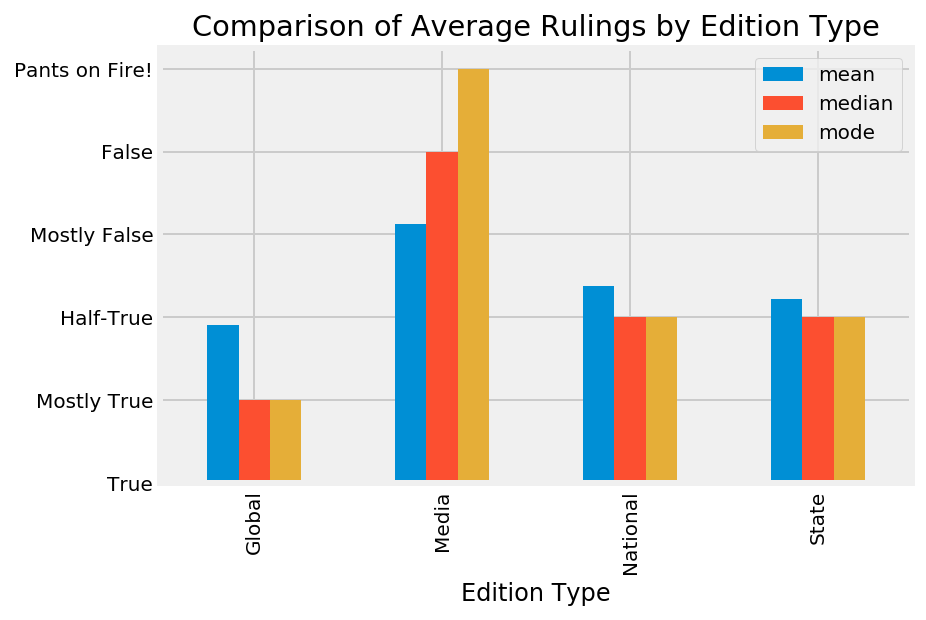

In [629]:
edition_type_stats[['mean','median','mode']].plot.bar()
plt.xlabel('Edition Type')
plt.title('Comparison of Average Rulings by Edition Type')
plt.yticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

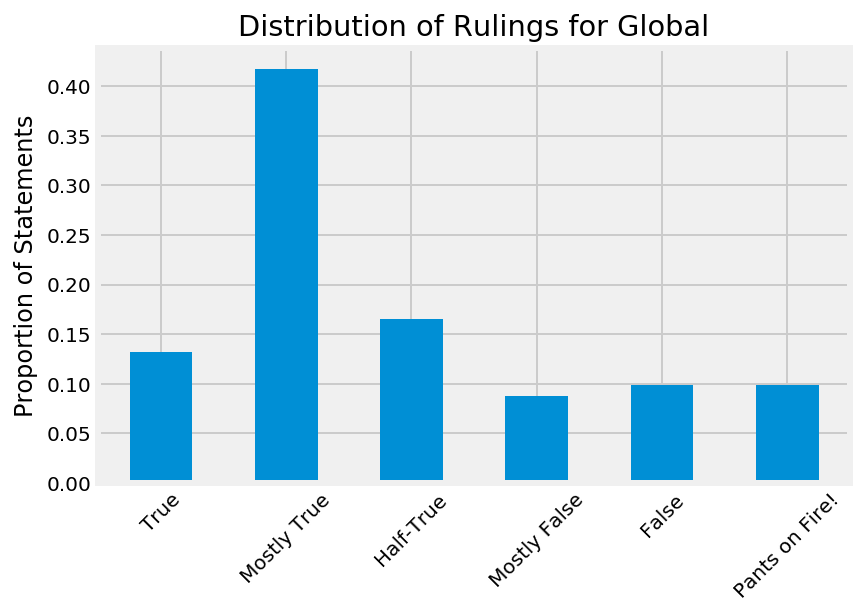

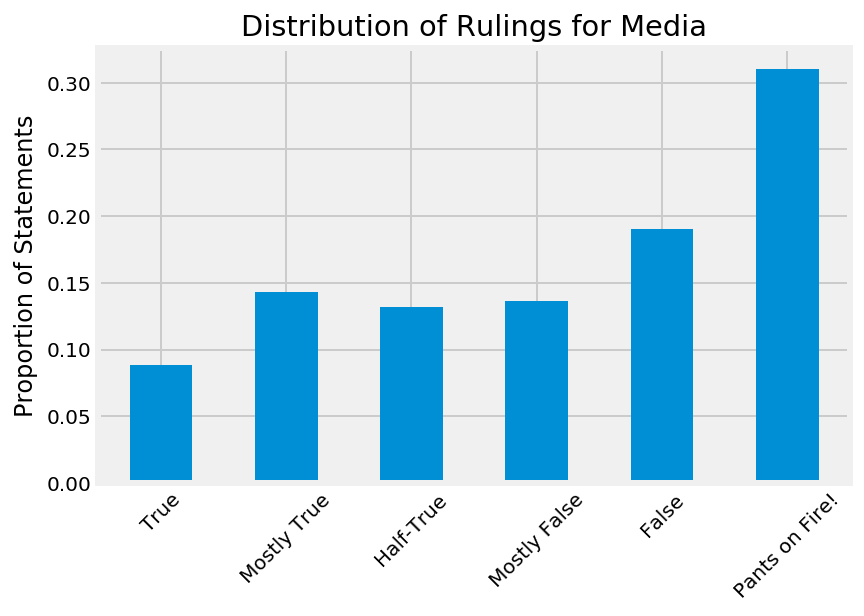

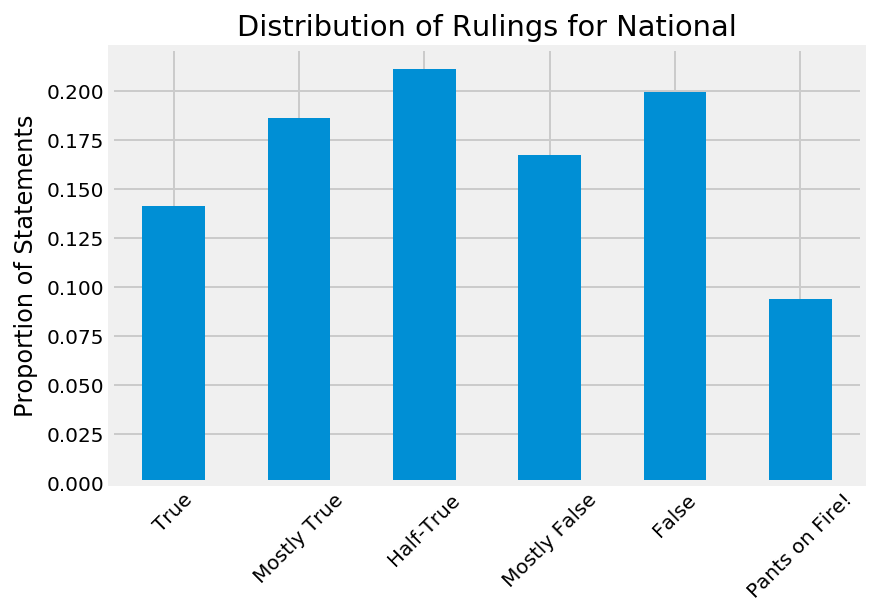

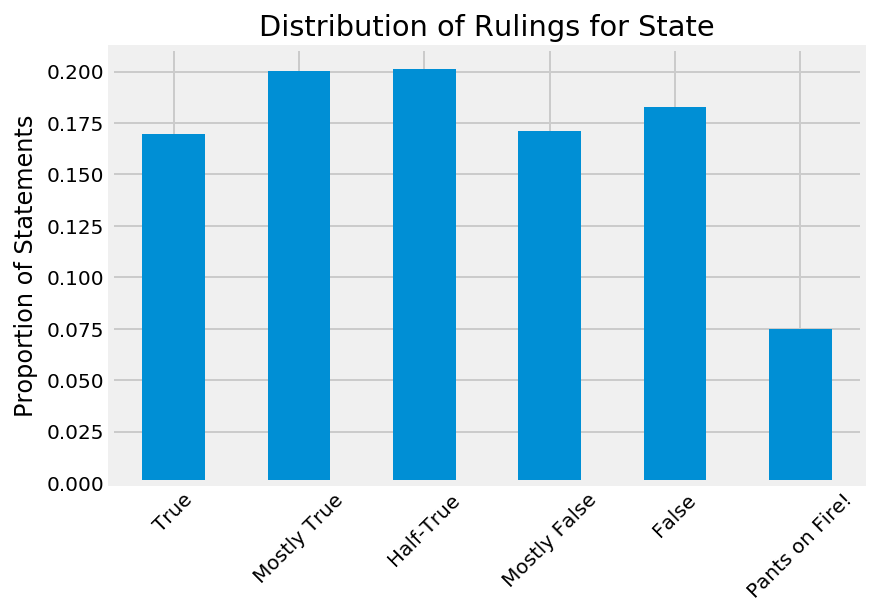

In [630]:
types = ['Global','Media','National','State']

for typ in types:
    typedf = df.loc[df['edition_type']==typ]
    frequencies = pd.DataFrame(typedf['number_ruling'].value_counts())
    frequencies.sort_index(inplace=True)
    frequencies['proportion'] = frequencies['number_ruling'].map(lambda x: float(x)/len(typedf))
    frequencies['proportion'].plot.bar()
    plt.title('Distribution of Rulings for '+typ)
    plt.ylabel('Proportion of Statements')
    plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'],rotation=45)
    plt.show()

In [631]:
#finding statistics for the binary variable 'lie' -- where 1 is a lie and 0 is a truth.
edition_type_stats2 = df.groupby('edition_type').agg({'lie':['count','mean','median',mode,'std']})
edition_type_stats2.columns = edition_type_stats2.columns.get_level_values(1)
edition_type_stats2

count      mean  median  mode       std
edition_type                                         
Global           91  0.285714       0     0  0.454257
Media           931  0.636950       1     1  0.481138
National       4654  0.460894       0     0  0.498522
State          8229  0.428606       0     0  0.494907

There are some clear differences between the different edition types, as shown above. 

- The Global edition tends to feature more truthful statements than the other types, with a far smaller proportion of lies overall. 

- The Media has a real problem with lying, clearly!  There are FAR more Pants on Fire! designations for media than for the other edition types, and a far smaller proportion of statements that were true or somewhat true. 

- The State and National edition types are much more consistently distributed, although both of them have notably fewer Pants on Fire! designations than other designations. National does have a smaller proportion of True and Mostly True statements than State editions do, as well as a higher proportion of False and Pants on Fire! statements. (We can see this reflected in the statistics for the 'lie' variable: 46% of National statements were designated as lies, versus 43% of State statements.) These differences are fairly subtle though: State and National are still fairly similar overall. 

Does this obscure differences between States, though?  I'll investigate below:

In [632]:
#for binary variable 'lie'
edition_stats = df.groupby('edition').agg({'lie':['count','mean','median',mode,'std']})
edition_stats.columns = edition_stats.columns.get_level_values(1)
edition_stats

count      mean  median  mode       std
edition                                                     
Arizona                 38  0.368421       0     0  0.488852
California             119  0.420168       0     0  0.495673
Colorado                30  0.600000       1     1  0.498273
Florida               1428  0.429272       0     0  0.495146
Georgia                864  0.329861       0     0  0.470435
Global News Service     91  0.285714       0     0  0.454257
Illinois                62  0.435484       0     0  0.499868
Iowa                    12  0.583333       1     1  0.514929
Missouri                87  0.367816       0     0  0.485006
National              4654  0.460894       0     0  0.498522
Nevada                  41  0.439024       0     0  0.502433
New Hampshire          155  0.470968       0     0  0.500774
New Jersey             393  0.384224       0     0  0.487031
New York                87  0.390805       0     0  0.490759
North Carolina          87  0.379310       0     0  0.488028
Ohio                   591  0.358714       0     0  0.480029
Oregon                 389  0.429306       0     0  0.495615
Pennsylvania            80  0.575000       1     1  0.497462
PunditFact             931  0.636950       1     1  0.481138
Rhode Island           544  0.450368       0     0  0.497988
Tennessee               76  0.565789       1     1  0.498946
Texas                 1352  0.426036       0     0  0.494682
Virginia               538  0.470260       0     0  0.499579
Wisconsin             1256  0.501592       1     1  0.500197

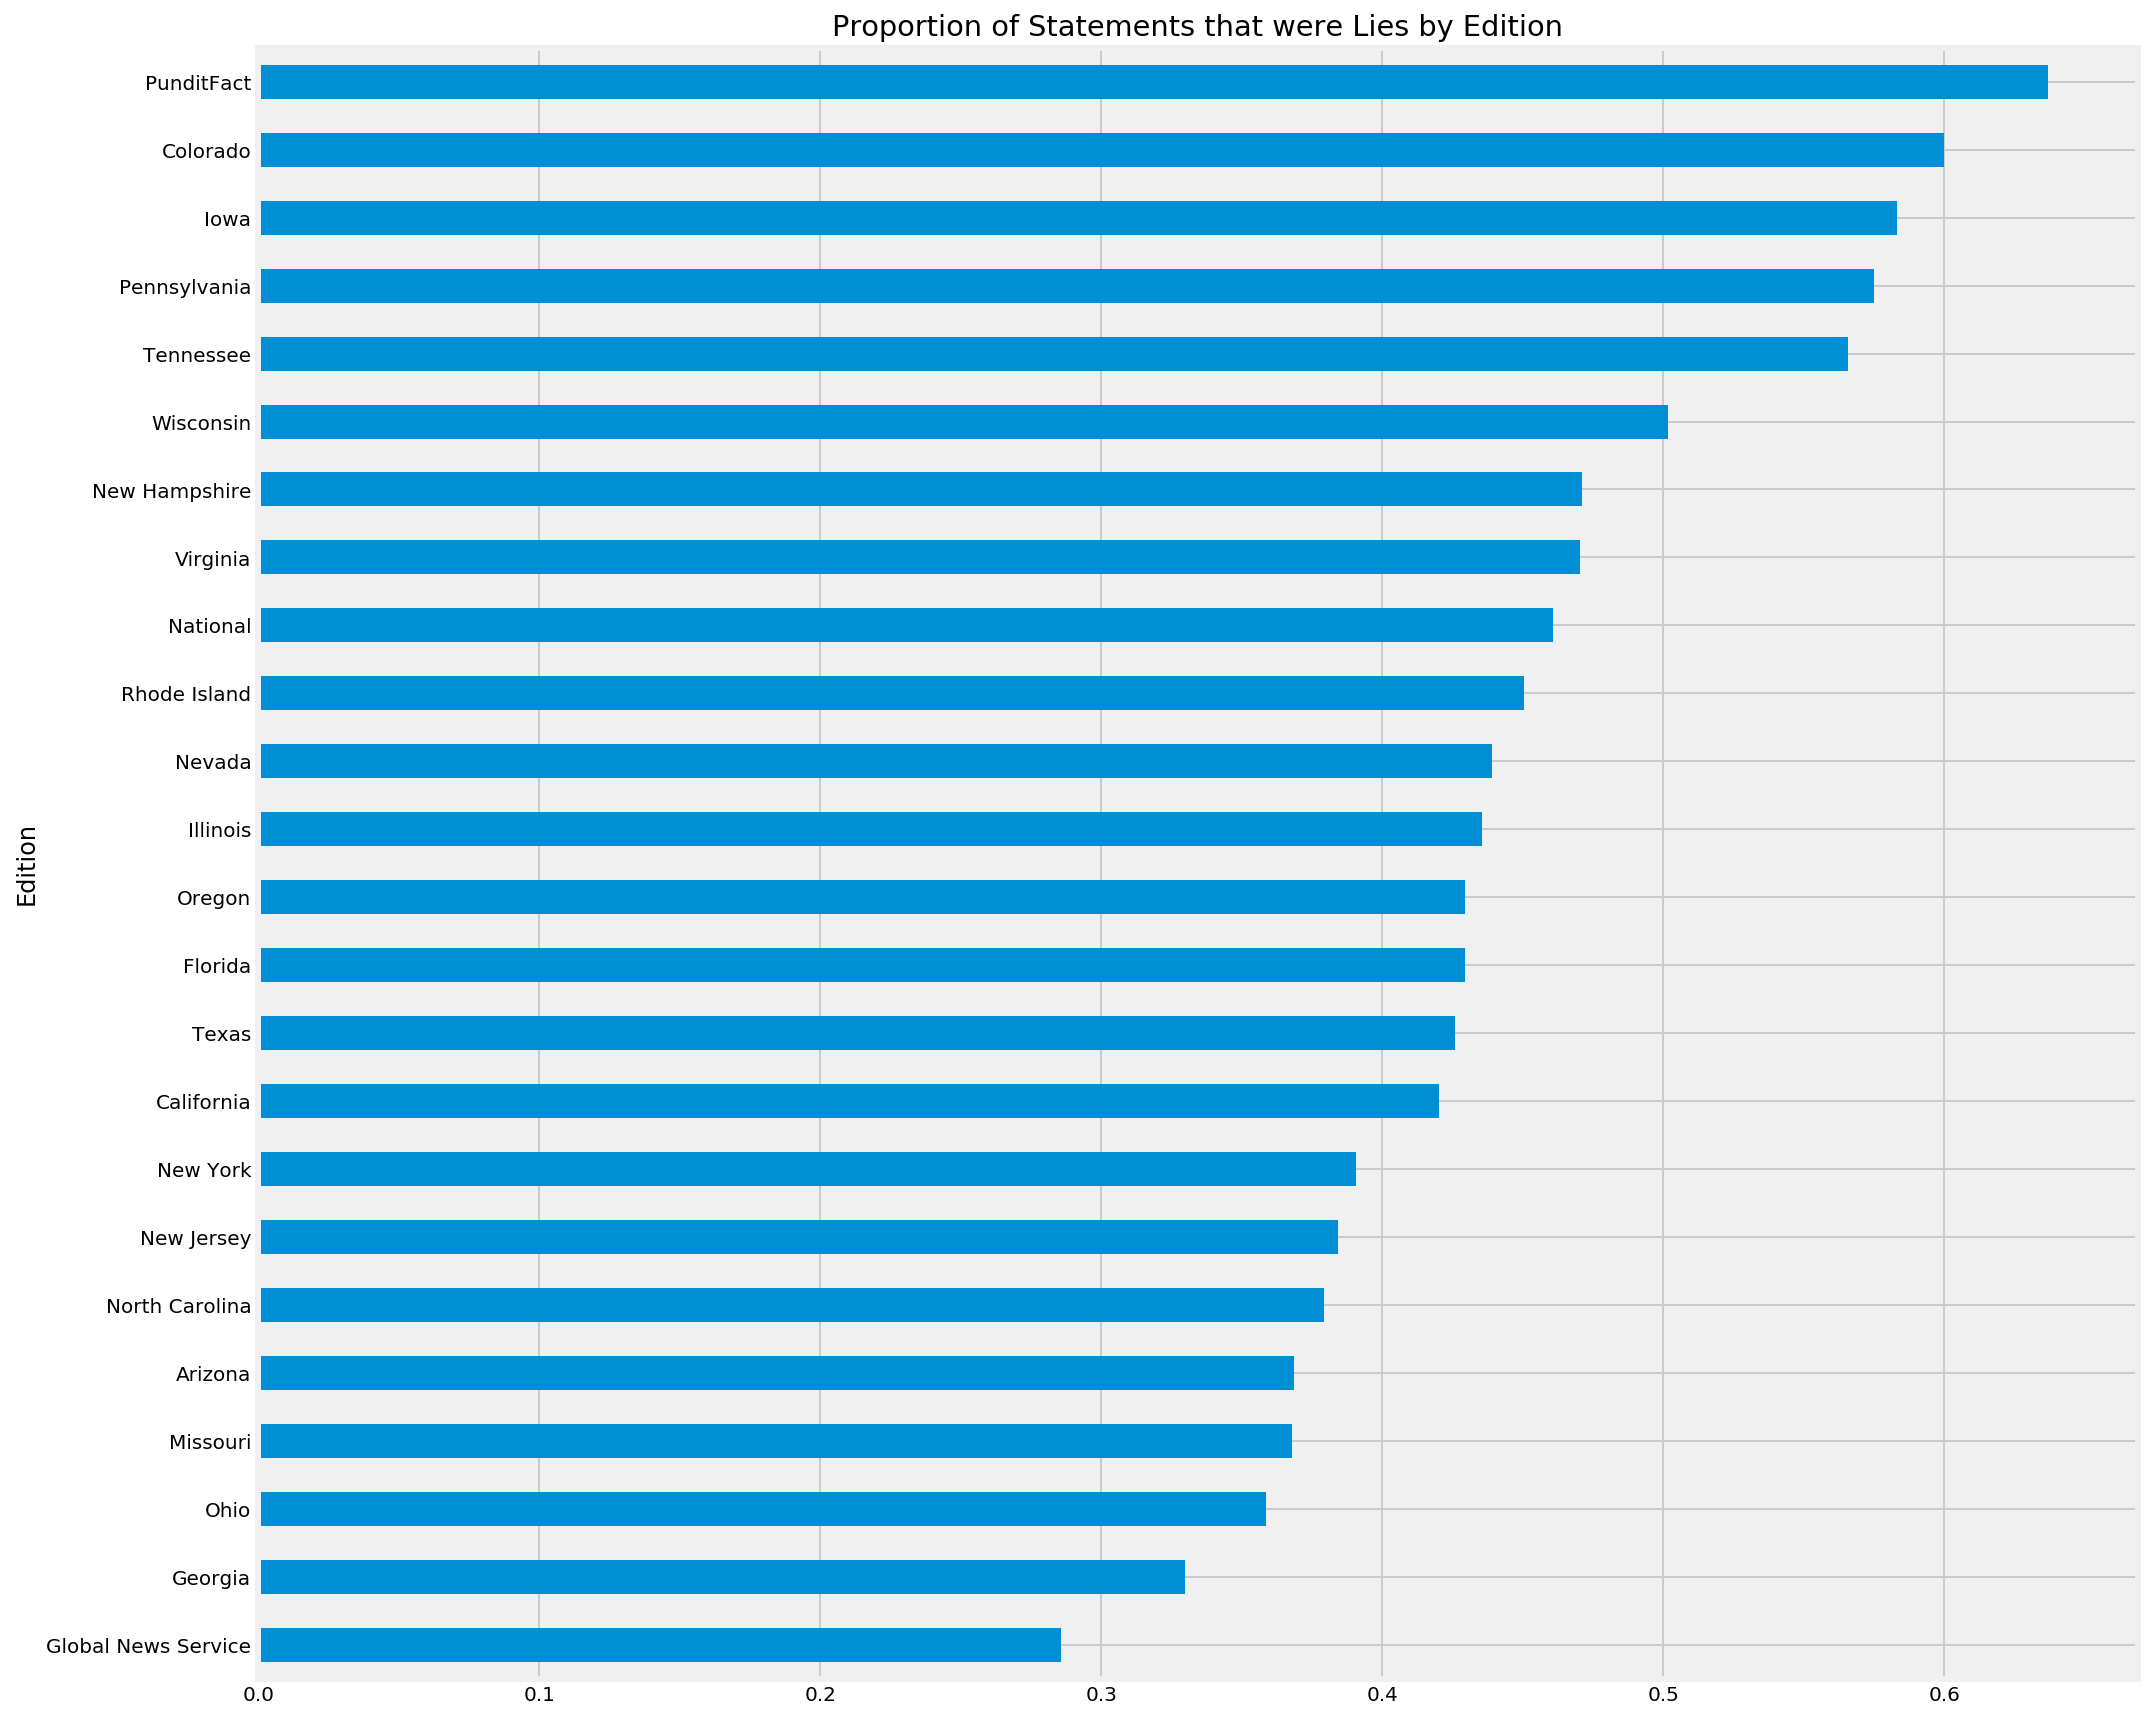

In [633]:
edition_stats.sort_values('mean',inplace=True,ascending=True)
edition_stats['mean'].plot.barh(figsize=(15,15))
plt.ylabel('Edition')
plt.title('Proportion of Statements that were Lies by Edition')
# plt.xticks([0,0.1],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

In [748]:
#for number_ruling, from 0 to 5
edition_stats2 = df.groupby('edition').agg({'number_ruling':['count','mean','median',mode,'std','min','max']})
edition_stats2.columns = edition_stats2.columns.get_level_values(1)
edition_stats2.sort_values('mean')

count      mean  median  mode       std  min  max
edition                                                               
Global News Service     91  1.901099       1     1  1.527925    0    5
New York                87  1.908046       2     0  1.639854    0    5
Georgia                864  1.940972       2     2  1.485343    0    5
Ohio                   591  1.962775       2     0  1.647382    0    5
Missouri                87  2.000000       2     1  1.311842    0    5
New Jersey             393  2.083969       2     1  1.589369    0    5
California             119  2.193277       2     1  1.541941    0    5
Oregon                 389  2.200514       2     4  1.602479    0    5
Illinois                62  2.209677       2     1  1.600585    0    5
Arizona                 38  2.210526       2     2  1.378560    0    5
Florida               1428  2.228291       2     2  1.440134    0    5
North Carolina          87  2.229885       2     2  1.361439    0    5
Texas                 1352  2.232249       2     2  1.577289    0    5
Virginia               538  2.236059       2     4  1.636991    0    5
New Hampshire          155  2.245161       2     3  1.373884    0    5
Rhode Island           544  2.270221       2     0  1.691315    0    5
Nevada                  41  2.365854       2     2  1.178051    0    5
National              4654  2.379029       2     2  1.554746    0    5
Wisconsin             1256  2.500796       3     4  1.489405    0    5
Colorado                30  2.566667       3     3  1.695498    0    5
Pennsylvania            80  2.662500       3     3  1.566612    0    5
Tennessee               76  2.671053       3     4  1.857512    0    5
Iowa                    12  2.750000       3     4  1.356801    1    5
PunditFact             931  3.128894       4     5  1.707206    0    5

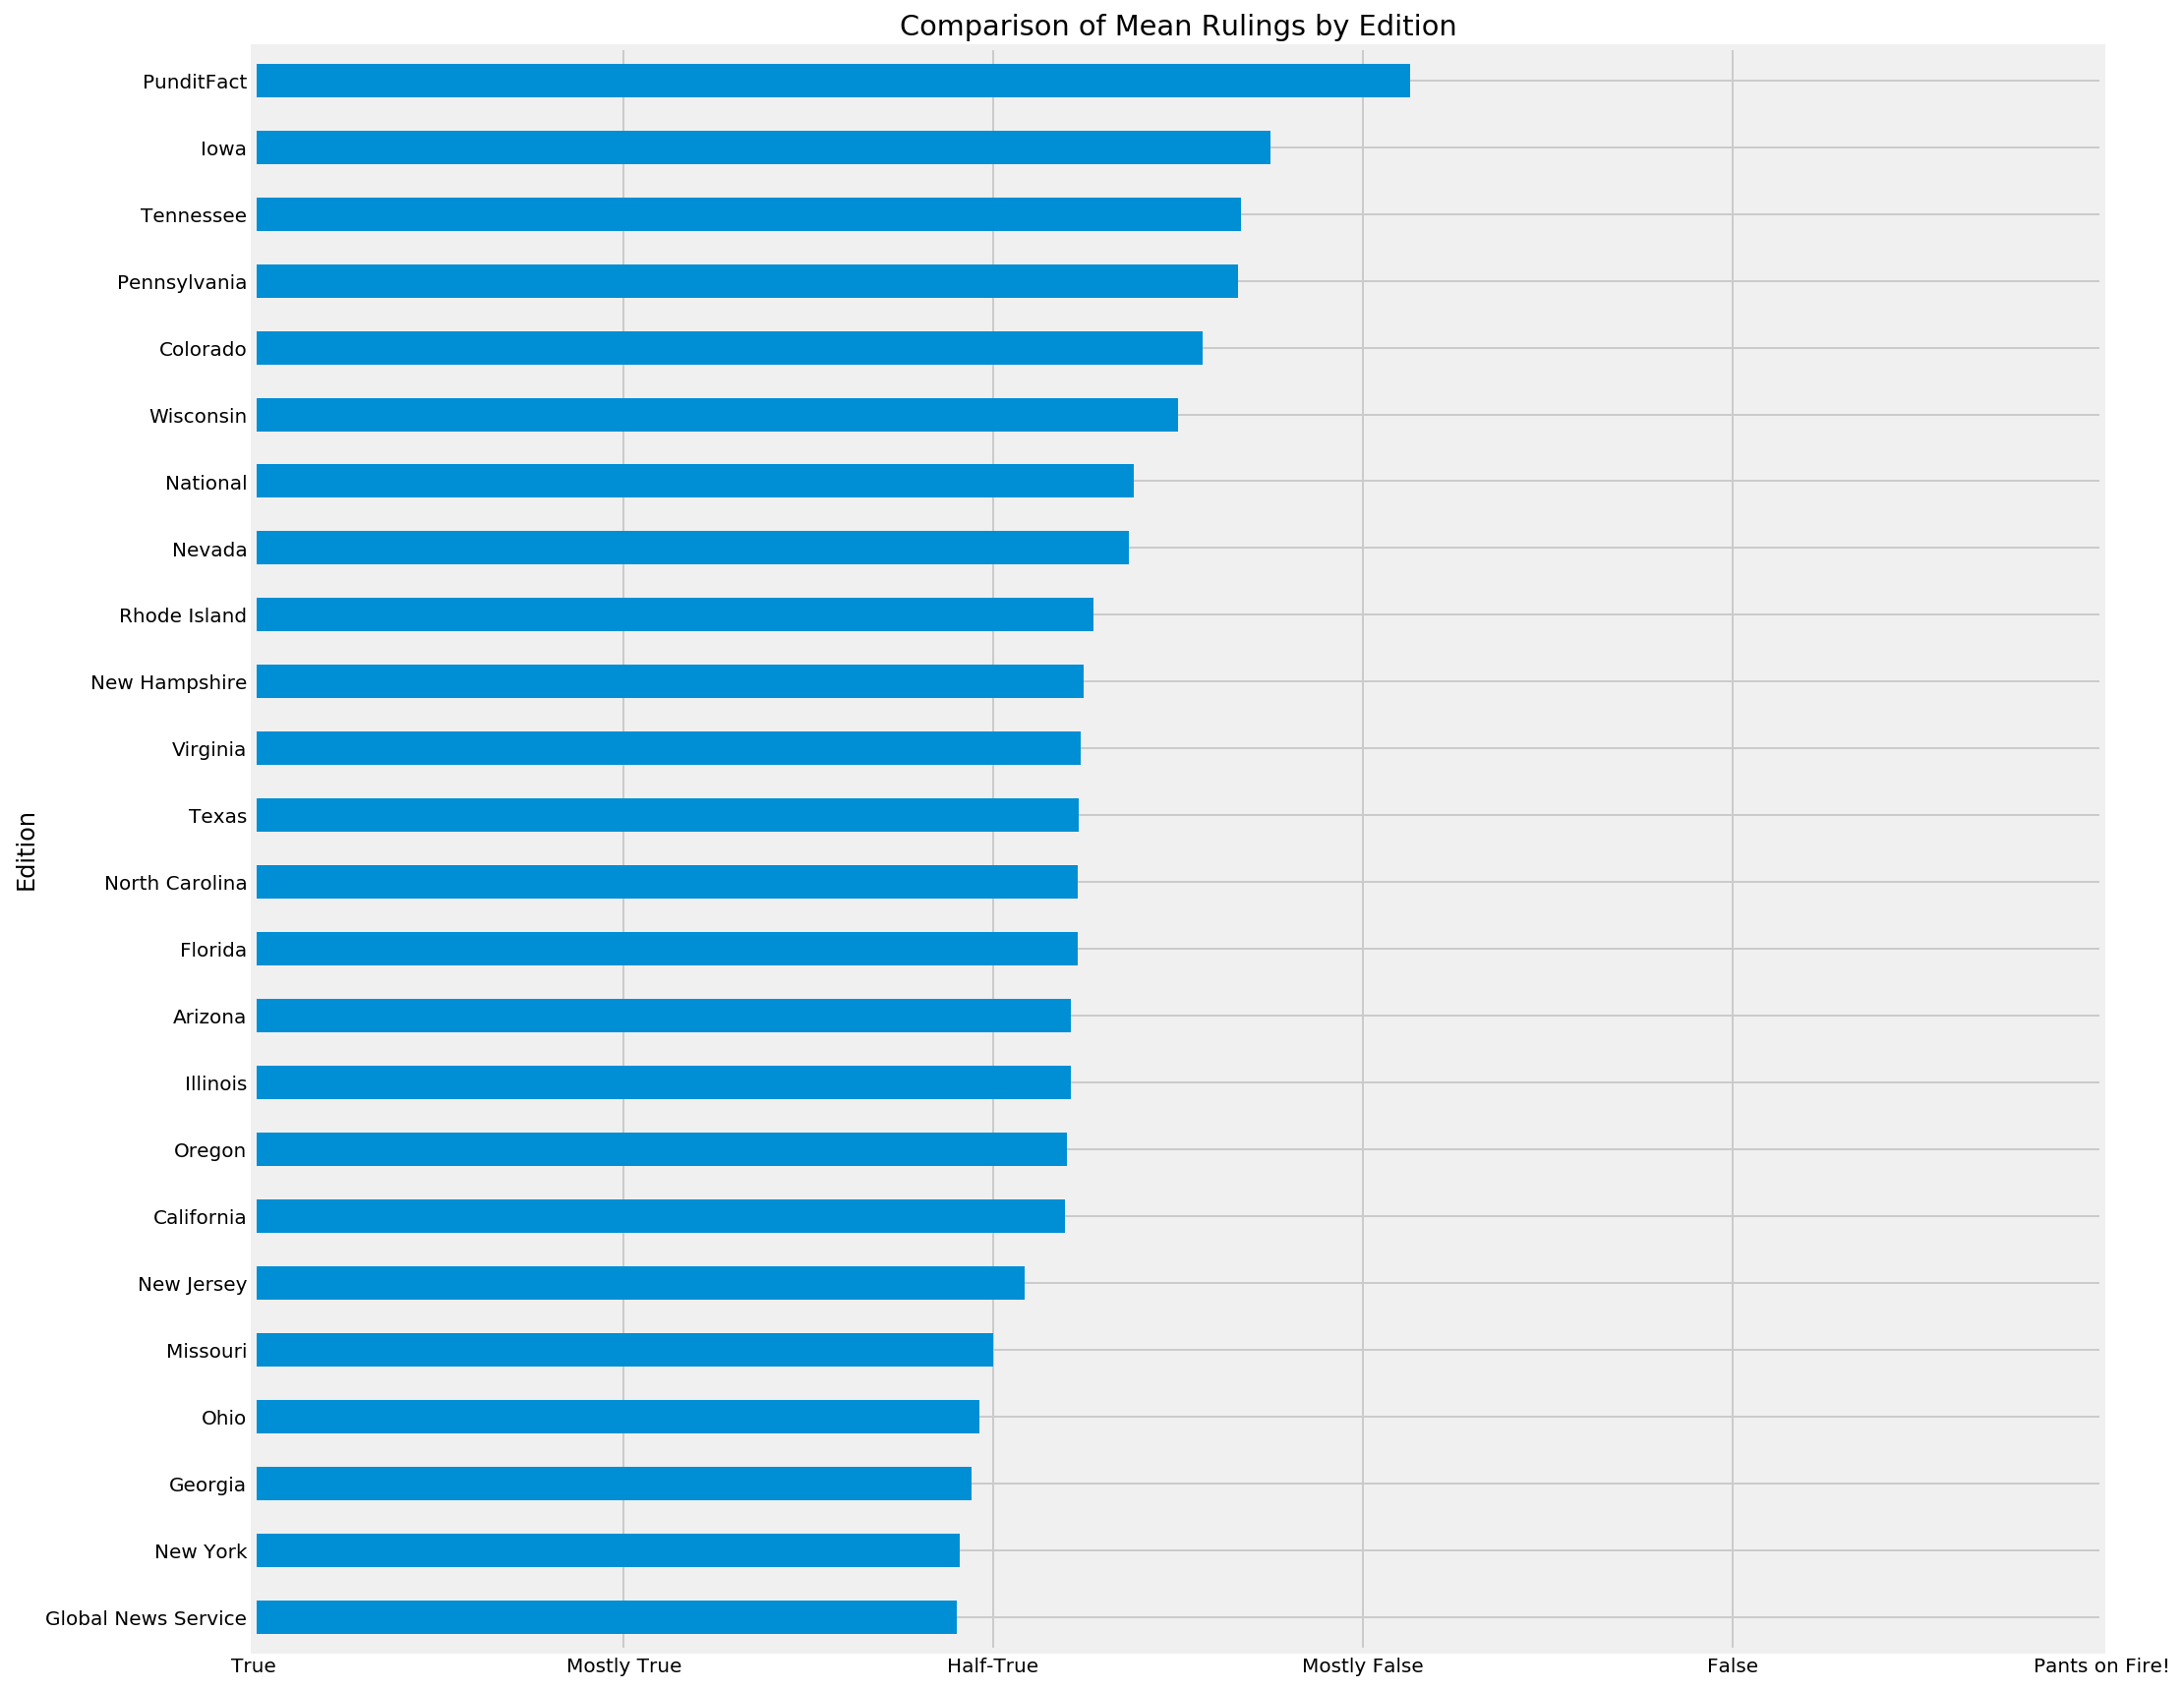

In [635]:
edition_stats2.sort_values('mean',inplace=True,ascending=True)
edition_stats2['mean'].plot.barh(figsize=(15,15))
plt.ylabel('Edition')
plt.title('Comparison of Mean Rulings by Edition')
plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

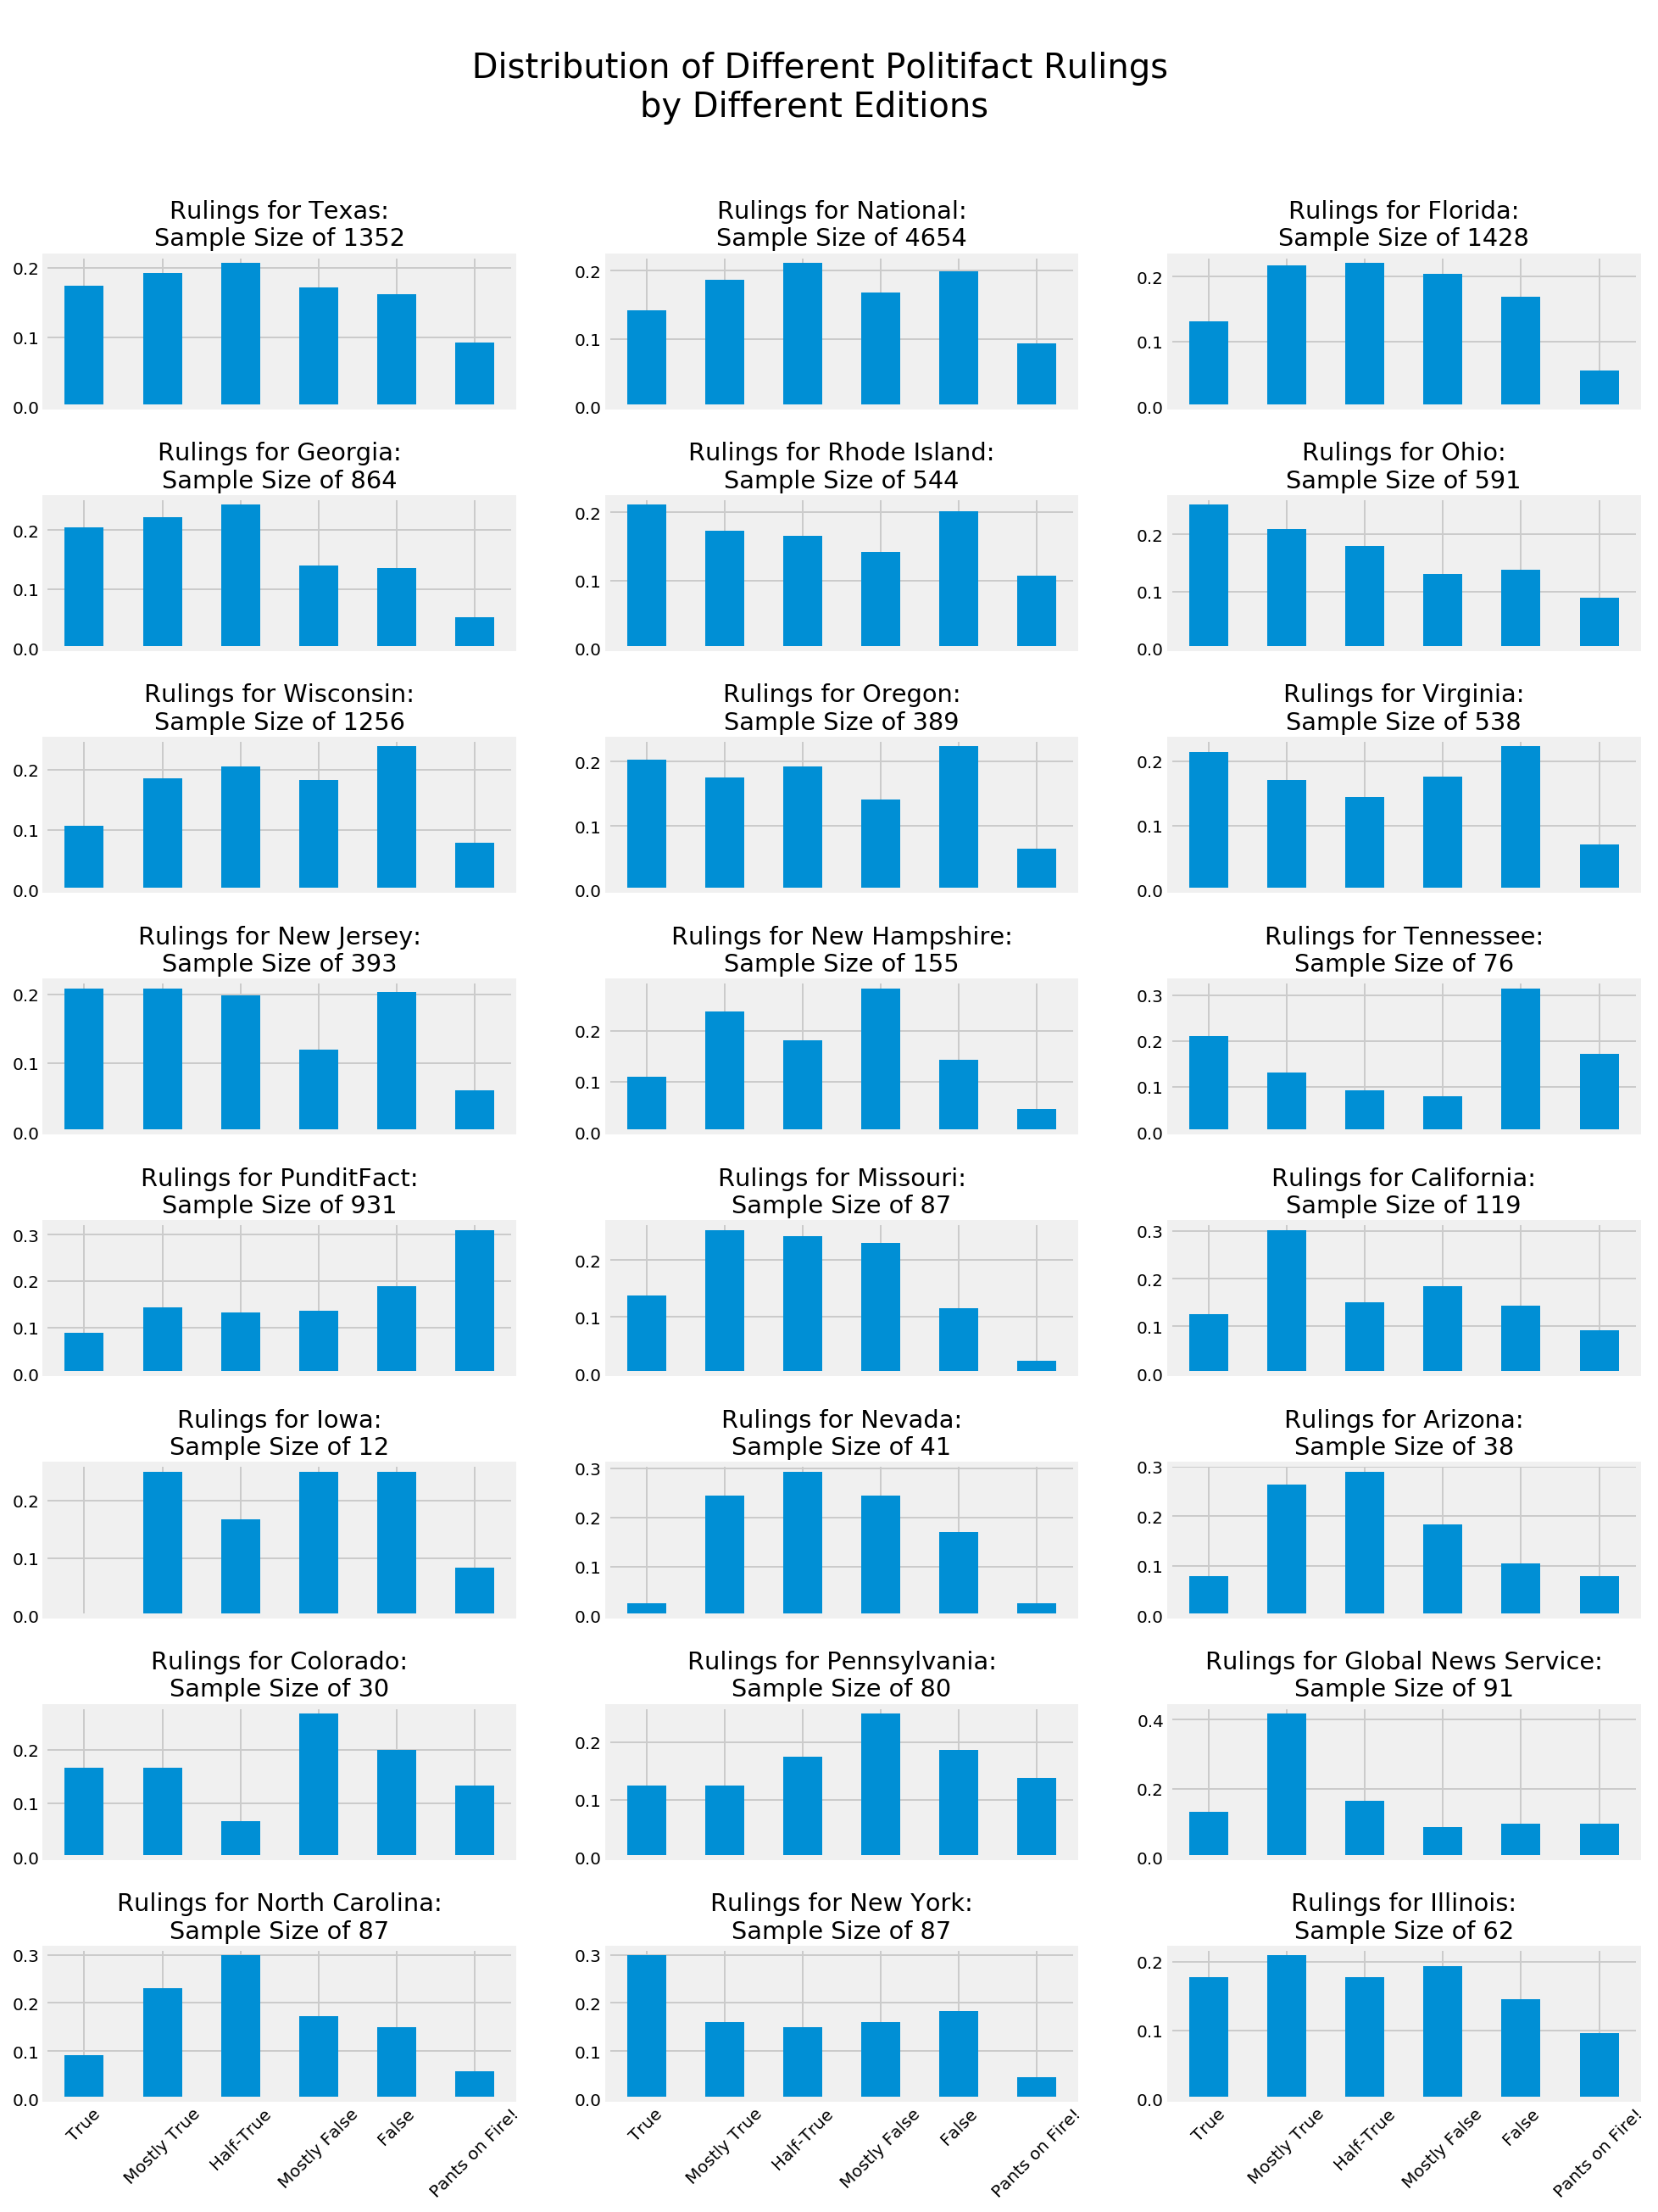

In [636]:
types = df['edition'].unique()

fig, axs = plt.subplots(nrows=len(types)/3, ncols=3, figsize=(15,20))
plt.subplots_adjust(hspace=0.6)
fig.suptitle('\n Distribution of Different Politifact Rulings\nby Different Editions',fontsize=20)

typesarray = np.array(types)
typesarray.shape = (len(types)/3,3)

for typ in types:
    row_pos = np.where(typesarray==typ)[0][0]
    col_pos = np.where(typesarray==typ)[1][0]
    typedf = df.loc[df['edition']==typ]
    frequencies = pd.DataFrame(typedf['number_ruling'].value_counts())
    if typ == 'Iowa':
        frequencies.loc[0] = 0
    frequencies.sort_index(inplace=True)
    frequencies['proportion'] = frequencies['number_ruling'].map(lambda x: float(x)/len(typedf))
    frequencies['proportion'].plot.bar(ax = axs[row_pos,col_pos])
    axs[row_pos,col_pos].set_title('Rulings for '+typ+':\nSample Size of '+str(len(typedf)))
    axs[row_pos,col_pos].set_xticklabels([])

for i in [0,1,2]:
    axs[7,i].set_xticklabels(['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'],rotation=45)

plt.show()

Some observations about differences between states:

- There definitely are some meaningful differences between the distributions in rulings for different states, although I want to exercise some caution because there are quite a few states with relatively few observations: Iowa (12); Arizona, Colorado, Nevada (all fewer than 50). 

- States that skew a little more than typical towards lies: Wisconsin, Tennesseee, Pennsylvania, Iowa, and Colorado. (The last two though have very few observations.)

- States that skew a little more than typical towards truths: Georgia, Ohio, New Jersey, Missouri, North Carolina, New York.

- Many of these states (for example, California, New Hampshire, or Nevada) have a dramatically less uniform distribution than is typical for the National edition or the State edition_type, even if they don't end up having a much different mean overall.  So, for instance, Nevada is markedly less likely than typical to have the very highest ruling or the very lowest ruling, and California is much more likely to have a ruling of 'Mostly True' than any other ruling. 

In [637]:
#if I can figure out Tableau, this will be the data I use for that
fortableau = df.loc[:,['edition','ruling','number_ruling','lie']]
fortableau = fortableau.loc[~(fortableau['edition'].isin(['National','PunditFact','Global News Service']))]

In [638]:
fortableau.to_csv('rulingsforstates.csv')

#### Investigating statement_type

There are only two types of statements: 'Claim' and 'Attack'

I think it's likely that Attacks might have more falsehoods than Claims do: let's see!

In [639]:
#for the binary variable 'lie':
statement_type_stats = df.groupby('statement_type').agg({'lie':['count','mean','median',mode,'std']})
statement_type_stats.columns = statement_type_stats.columns.get_level_values(1)
statement_type_stats

count      mean  median  mode       std
statement_type                                         
Attack           1570  0.538217       1     1  0.498696
Claim           12335  0.441508       0     0  0.496587

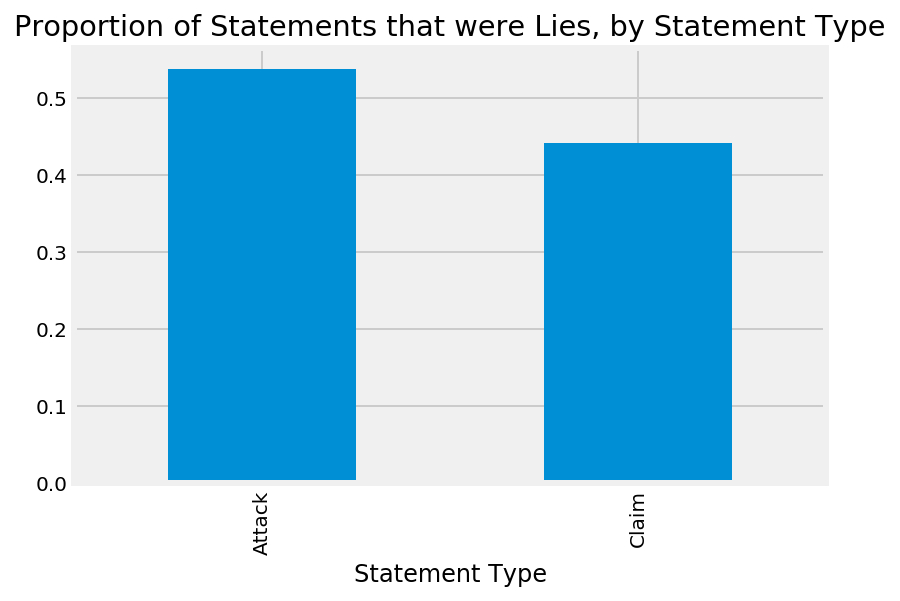

In [640]:
statement_type_stats['mean'].plot.bar()
plt.xlabel('Statement Type')
plt.title('Proportion of Statements that were Lies, by Statement Type')
plt.show()

In [641]:
#for the number_ruling, from 0 to 5:
statement_type_stats2 = df.groupby('statement_type').agg({'number_ruling':['count','mean','median',mode,'std']})
statement_type_stats2.columns = statement_type_stats2.columns.get_level_values(1)
statement_type_stats2

count      mean  median  mode       std
statement_type                                         
Attack           1570  2.590446       3     3  1.496471
Claim           12335  2.299878       2     1  1.586891

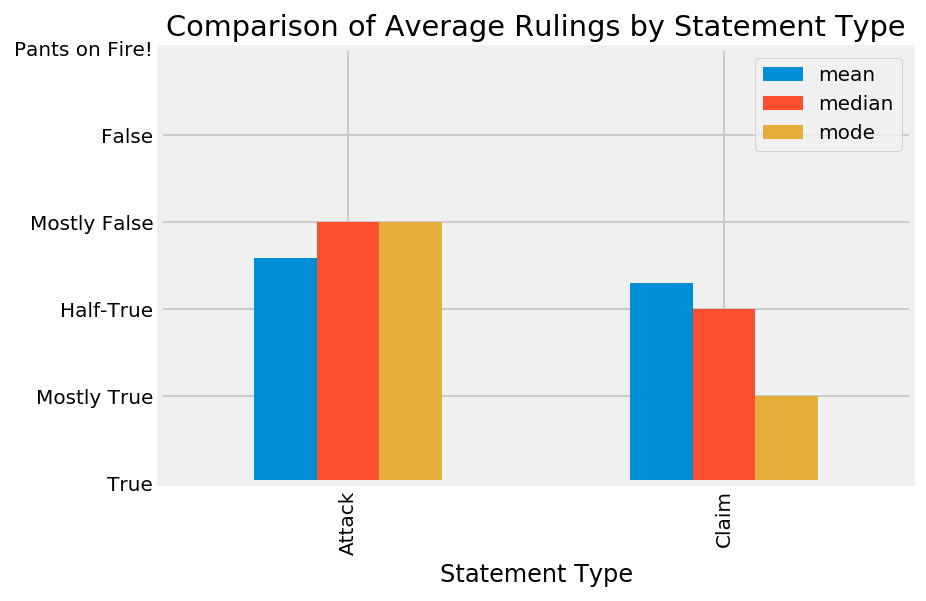

In [642]:
statement_type_stats2[['mean','median','mode']].plot.bar()
plt.xlabel('Statement Type')
plt.title('Comparison of Average Rulings by Statement Type')
plt.yticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

In [643]:
groupedbystatement = df.groupby(['statement_type','number_ruling'])['number_ruling'].count()

groupedbystatement = groupedbystatement.groupby(level=0).apply(lambda x: x/float(x.sum()))
groupedbystatement

statement_type  number_ruling
Attack          0                0.114650
                1                0.135669
                2                0.211465
                3                0.222293
                4                0.214650
                5                0.101274
Claim           0                0.159627
                1                0.200486
                2                0.198379
                3                0.159951
                4                0.185002
                5                0.096555
Name: number_ruling, dtype: float64

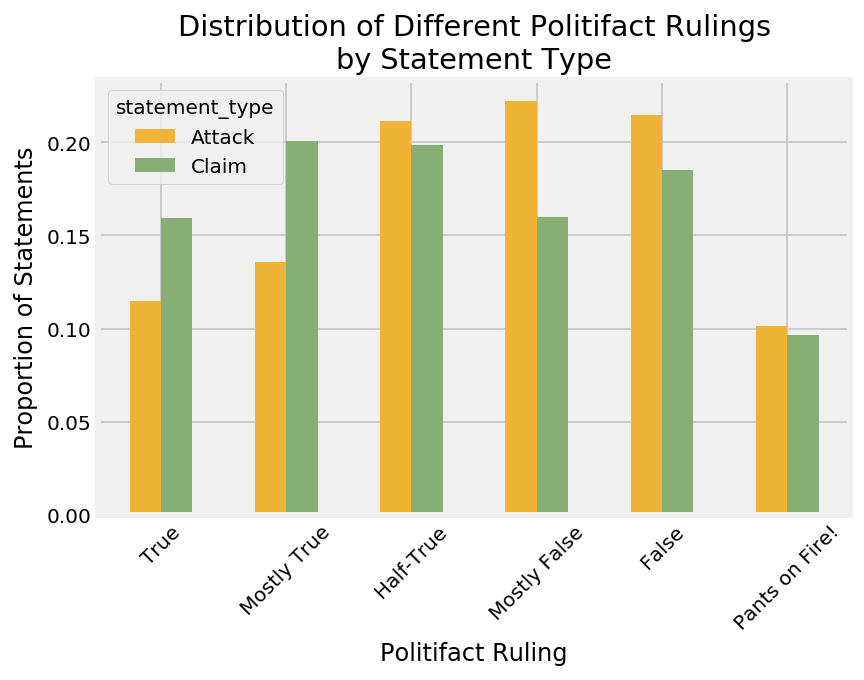

In [644]:
groupedbystatement.unstack(0).plot.bar(color=['xkcd:macaroni and cheese','xkcd:sage'])
plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'],rotation=45)
plt.xlabel('Politifact Ruling')
plt.ylabel('Proportion of Statements')
plt.title('Distribution of Different Politifact Rulings\nby Statement Type')
plt.show()

There's a very clear difference here between the different statement types.  Attacks are clearly less credible overall than Claims, no matter how you measure it. If you look at just the binary lie/truth variable, 54% of Attacks versus 44% of Claims were lies; for the number_ruling, all three measures of average were higher for Attacks (particularly the median and mode), and the distribution clearly shows the Attacks' distribution concentrated around Mostly False, with Claims having a much higher proportion of True and Mostly True statements than Attacks.  

#### Investigating speaker_party

The main area of interest here is to investigate the differene between the two main political parties, the Republicans and the Democrats.  Looking at Independents might also be interesting, but we have far fewer observations for Independents than for Republicans and Democrats.  We may also have to eliminate some groups that only have a few observations associated with them, since we can't really draw meaningful insights from, say, 3 observations.

In [645]:
df.speaker_party.value_counts()

Republican                         6097
Democrat                           4354
None                               2582
Organization                        285
Independent                         197
Newsmaker                            66
Libertarian                          60
Journalist                           52
Activist                             49
Columnist                            47
Talk show host                       33
State official                       27
Labor leader                         17
Business leader                      11
Tea Party member                     10
Green                                 3
Constitution Party                    3
Education official                    3
Government body                       2
county commissioner                   2
Moderate Party                        1
Ocean State Tea Party in Action       1
Democratic Farmer-Labor               1
Law enforcement official              1
Liberal Party of Canada               1


In [646]:
#I'm going to eliminate anything with fewer than 30 observations for the purposes of this EDA.
tokeep = ['Republican','Democrat','None','Organization', 'Independent','Newsmaker',
          'Libertarian','Journalist','Activist','Columnist','Talk show host']
dfparty = df.loc[df['speaker_party'].isin(tokeep)]

In [647]:
dfparty.speaker_party.unique()

array(['Democrat', 'Republican', 'None', 'Libertarian', 'Independent',
       'Columnist', 'Journalist', 'Organization', 'Talk show host',
       'Newsmaker', 'Activist'], dtype=object)

In [648]:
#for the binary variable 'lie':
speaker_party_stats = dfparty.groupby('speaker_party').agg({'lie':['count','mean','median',mode,'std']})
speaker_party_stats.columns = speaker_party_stats.columns.get_level_values(1)
speaker_party_stats

count      mean  median  mode       std
speaker_party                                          
Activist           49  0.367347       0     0  0.487078
Columnist          47  0.489362       0     0  0.505291
Democrat         4354  0.331419       0     0  0.470778
Independent       197  0.294416       0     0  0.456941
Journalist         52  0.384615       0     0  0.491251
Libertarian        60  0.400000       0     0  0.494032
Newsmaker          66  0.378788       0     0  0.488802
None             2582  0.556545       1     1  0.496889
Organization      285  0.508772       1     1  0.500802
Republican       6097  0.499754       0     0  0.500041
Talk show host     33  0.727273       1     1  0.452267

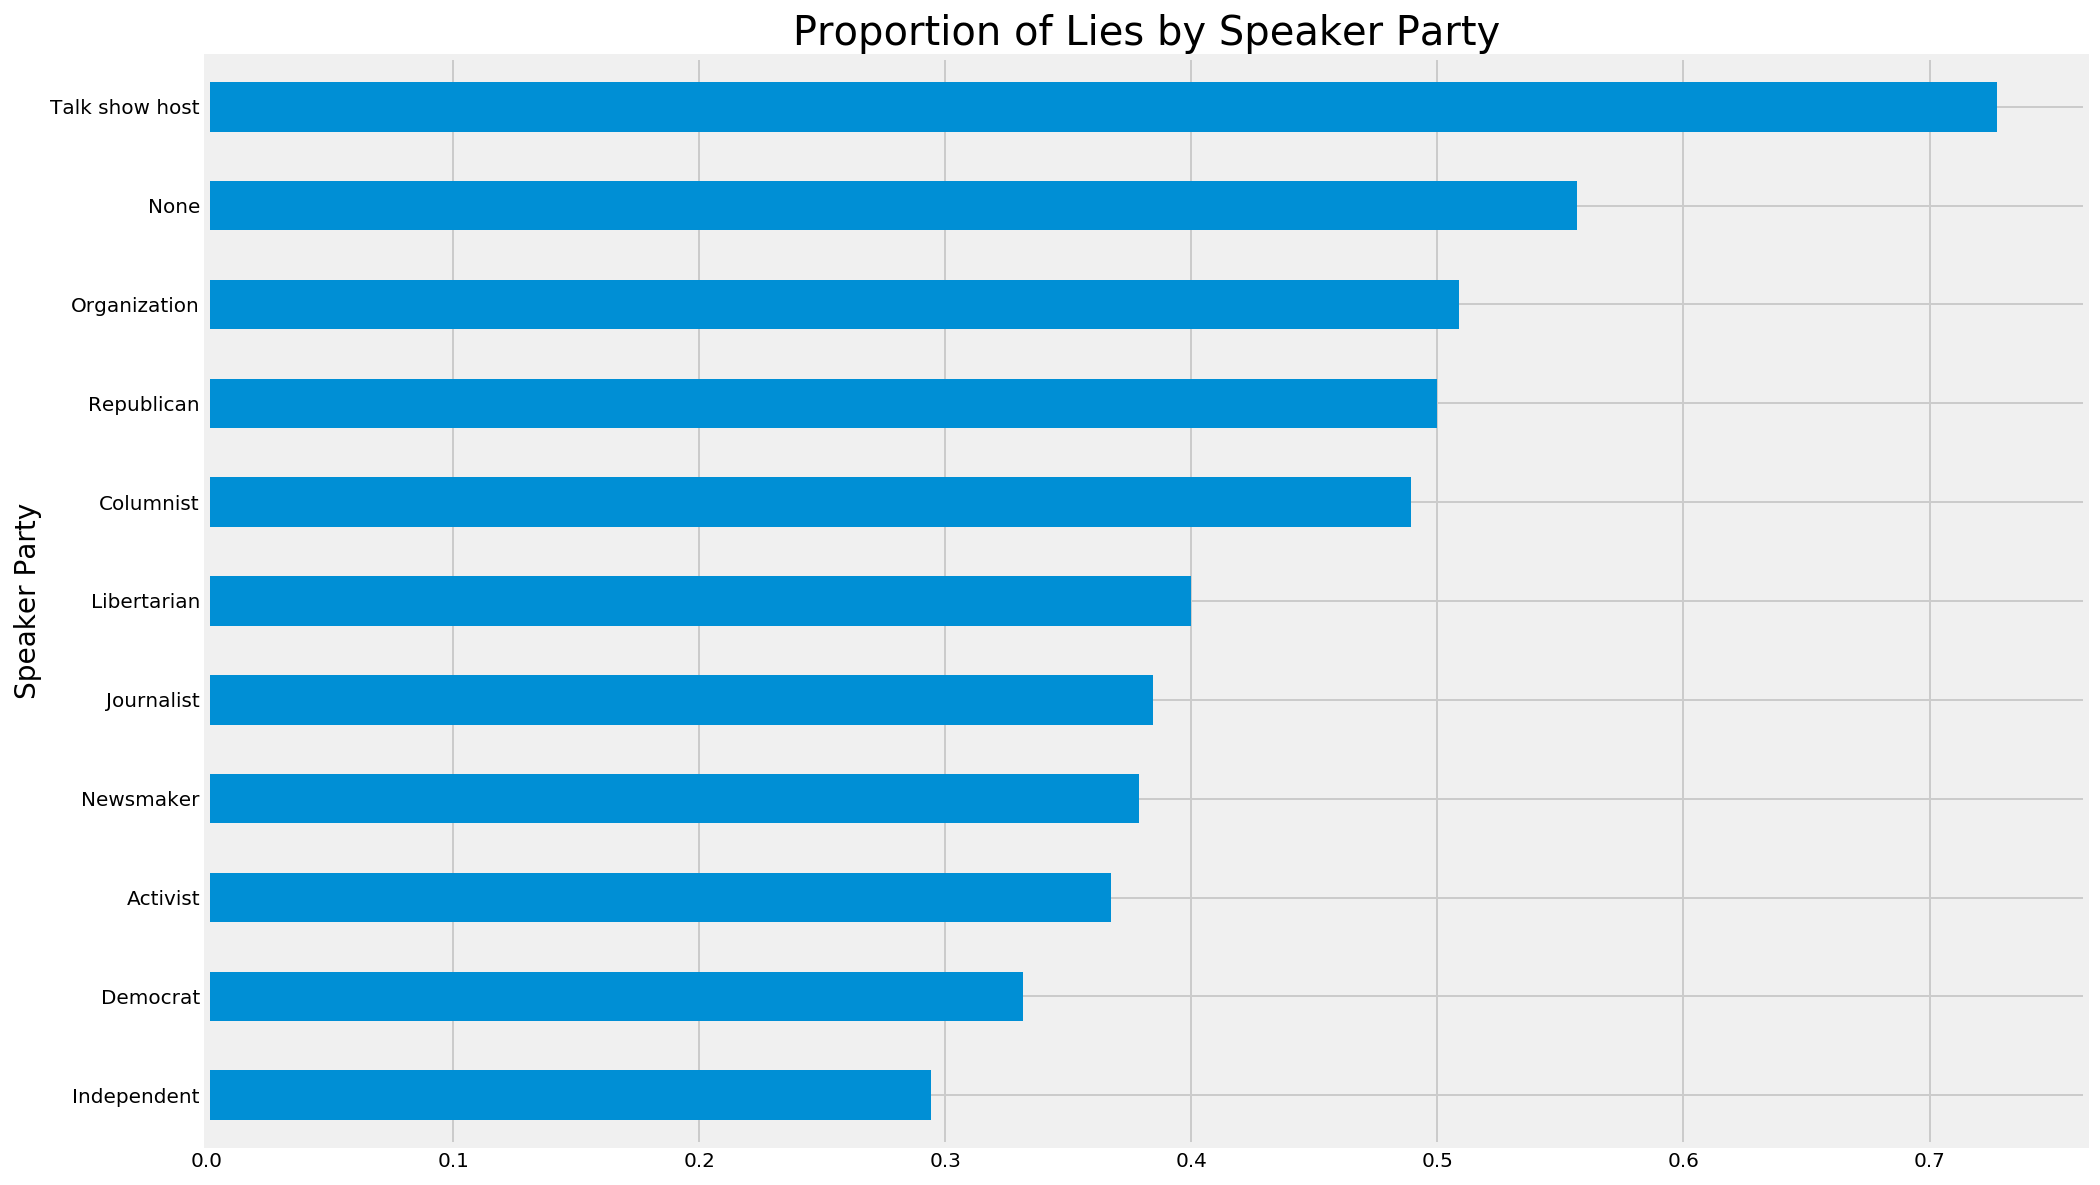

In [649]:
speaker_party_stats.sort_values('mean',inplace=True,ascending=True)
speaker_party_stats['mean'].plot.barh(figsize=(15,10))
plt.ylabel('Speaker Party', fontsize=14)
plt.title('Proportion of Lies by Speaker Party',fontsize=20)
plt.show()

In [650]:
df.loc[df['speaker_party']=='None'].speaker.value_counts()

 Bloggers                                                    238
 Chain email                                                 180
 Facebook posts                                               99
Rush Limbaugh                                                 38
 Democratic National Committee                                35
 Viral image                                                  33
Glenn Beck                                                    31
Rachel Maddow                                                 27
Bill O'Reilly                                                 21
Sean Hannity                                                  20
Chris Abele                                                   20
 Club for Growth                                              19
 National Rifle Association                                   19
Paul Krugman                                                  18
 Americans for Prosperity                                     18
Michael Moore            

I was a little bit surprised that 'None' had such a high proportion of lies -- I would have expected that partisanship would exacerbate untruthfulness.  I decided to investigate the 'None's a little bit more carefully, and it does that unfortunately a lot of these speakers are absolutely either Democrats or Republicans and have simply not been classified as such.  I don't have the time right now to go through and investigate every single one of the 1000 unique speakers to see what their political party is, unfortunately, and it strikes me that a lot of the columnists, journalists, activists, and organizations probably also have political leanings. 

If I have time (once I know that I have my models all set up etc and I can go back and do things in more careful detail) I would like to add a feature called 'Right-Leaning' and 'Left-Leaning', which would allow me to investigate conservative politicians, journalists, and organizations versus progressive politicians, journalists, and organizations.  Given the huge disparity between Republicans and Democrats in the proportion of lies that we see above, it seems like a speaker's position on the political spectrum may be a worthwhile feature to create.

In [651]:
# addtorightleaning = ['Rush Limbaugh','Glenn Beck',"Bill O'Reilly",
#                     'Sean Hannity',' Club for Growth', ' Americans for Prosperity',
#                     'Laura Ingraham', 'Wayne LaPierre', ' Winning our the Future']
# addtoleftleaning = [' Democratic National Committee','Rachel Maddow','Chris Abele',
#                   'Paul Krugman','Michael Moore','Ed Schultz','John Oliver',
#                   ' Americans United for Change', "Lawrence O'Donnell",'Keith Olbermann',
#                   'Jon Stewart']

In [652]:
#for number_ruling, from 0 to 5
speaker_party_stats2 = dfparty.groupby('speaker_party').agg({'number_ruling':['count','mean','median',mode,'std','min','max']})
speaker_party_stats2.columns = speaker_party_stats2.columns.get_level_values(1)
speaker_party_stats2

count      mean  median  mode       std  min  max
speaker_party                                                    
Activist           49  2.102041       2     2  1.294940    0    4
Columnist          47  2.148936       2     4  1.641562    0    5
Democrat         4354  1.922370       2     1  1.461958    0    5
Independent       197  1.781726       1     1  1.339384    0    5
Journalist         52  2.038462       2     1  1.571331    0    5
Libertarian        60  2.266667       2     2  1.582389    0    5
Newsmaker          66  1.984848       2     0  1.659401    0    5
None             2582  2.788536       3     5  1.732223    0    5
Organization      285  2.557895       3     2  1.441701    0    5
Republican       6097  2.448581       2     4  1.530107    0    5
Talk show host     33  3.393939       4     4  1.599597    0    5

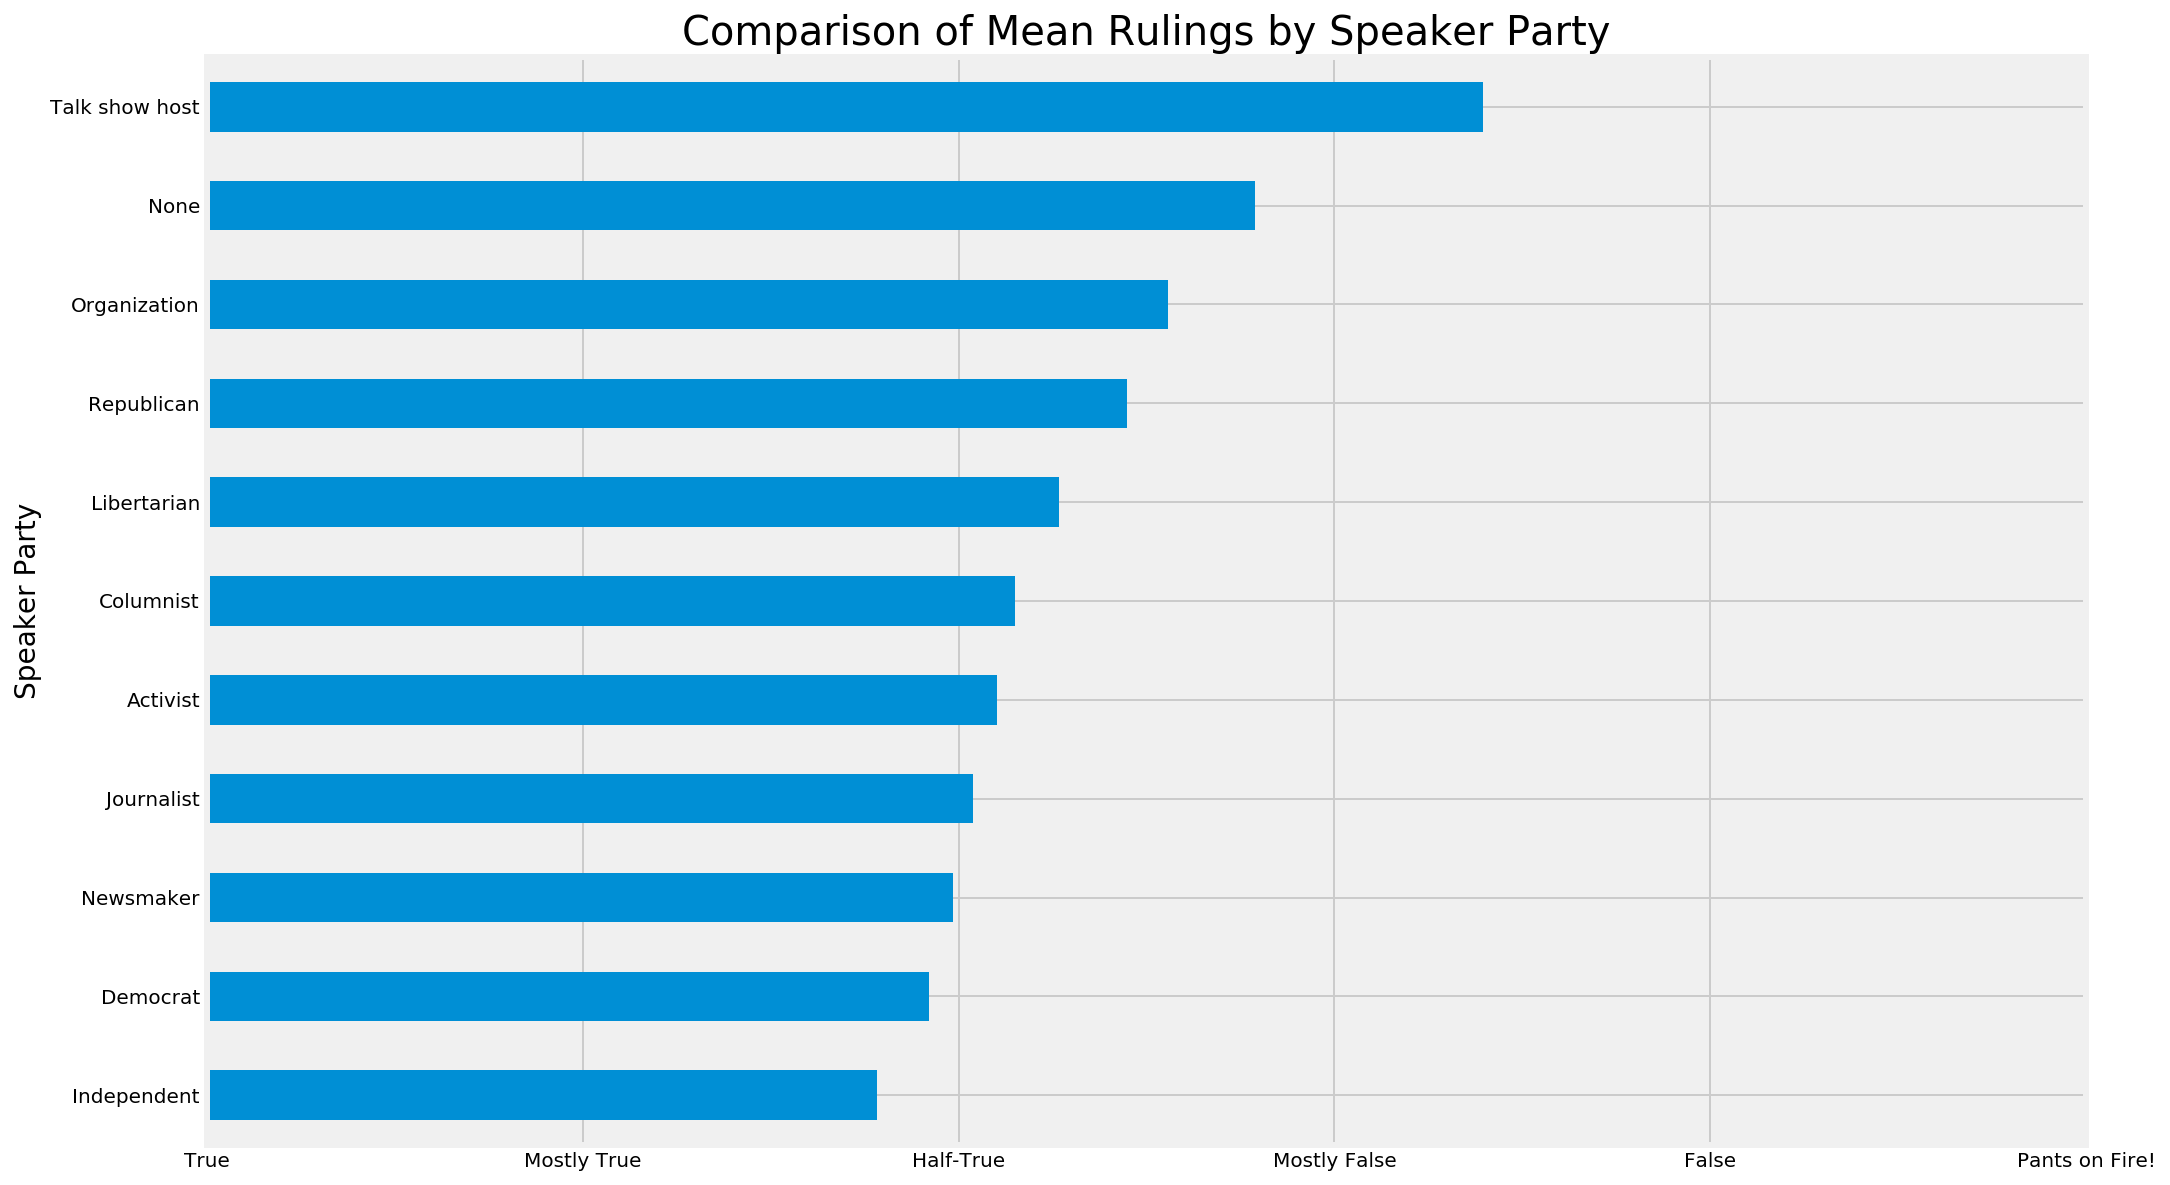

In [653]:
speaker_party_stats2.sort_values('mean',inplace=True,ascending=True)
speaker_party_stats2['mean'].plot.barh(figsize=(15,10))
plt.ylabel('Speaker Party', fontsize=14)
plt.title('Comparison of Mean Rulings by Speaker Party', fontsize=20)
plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

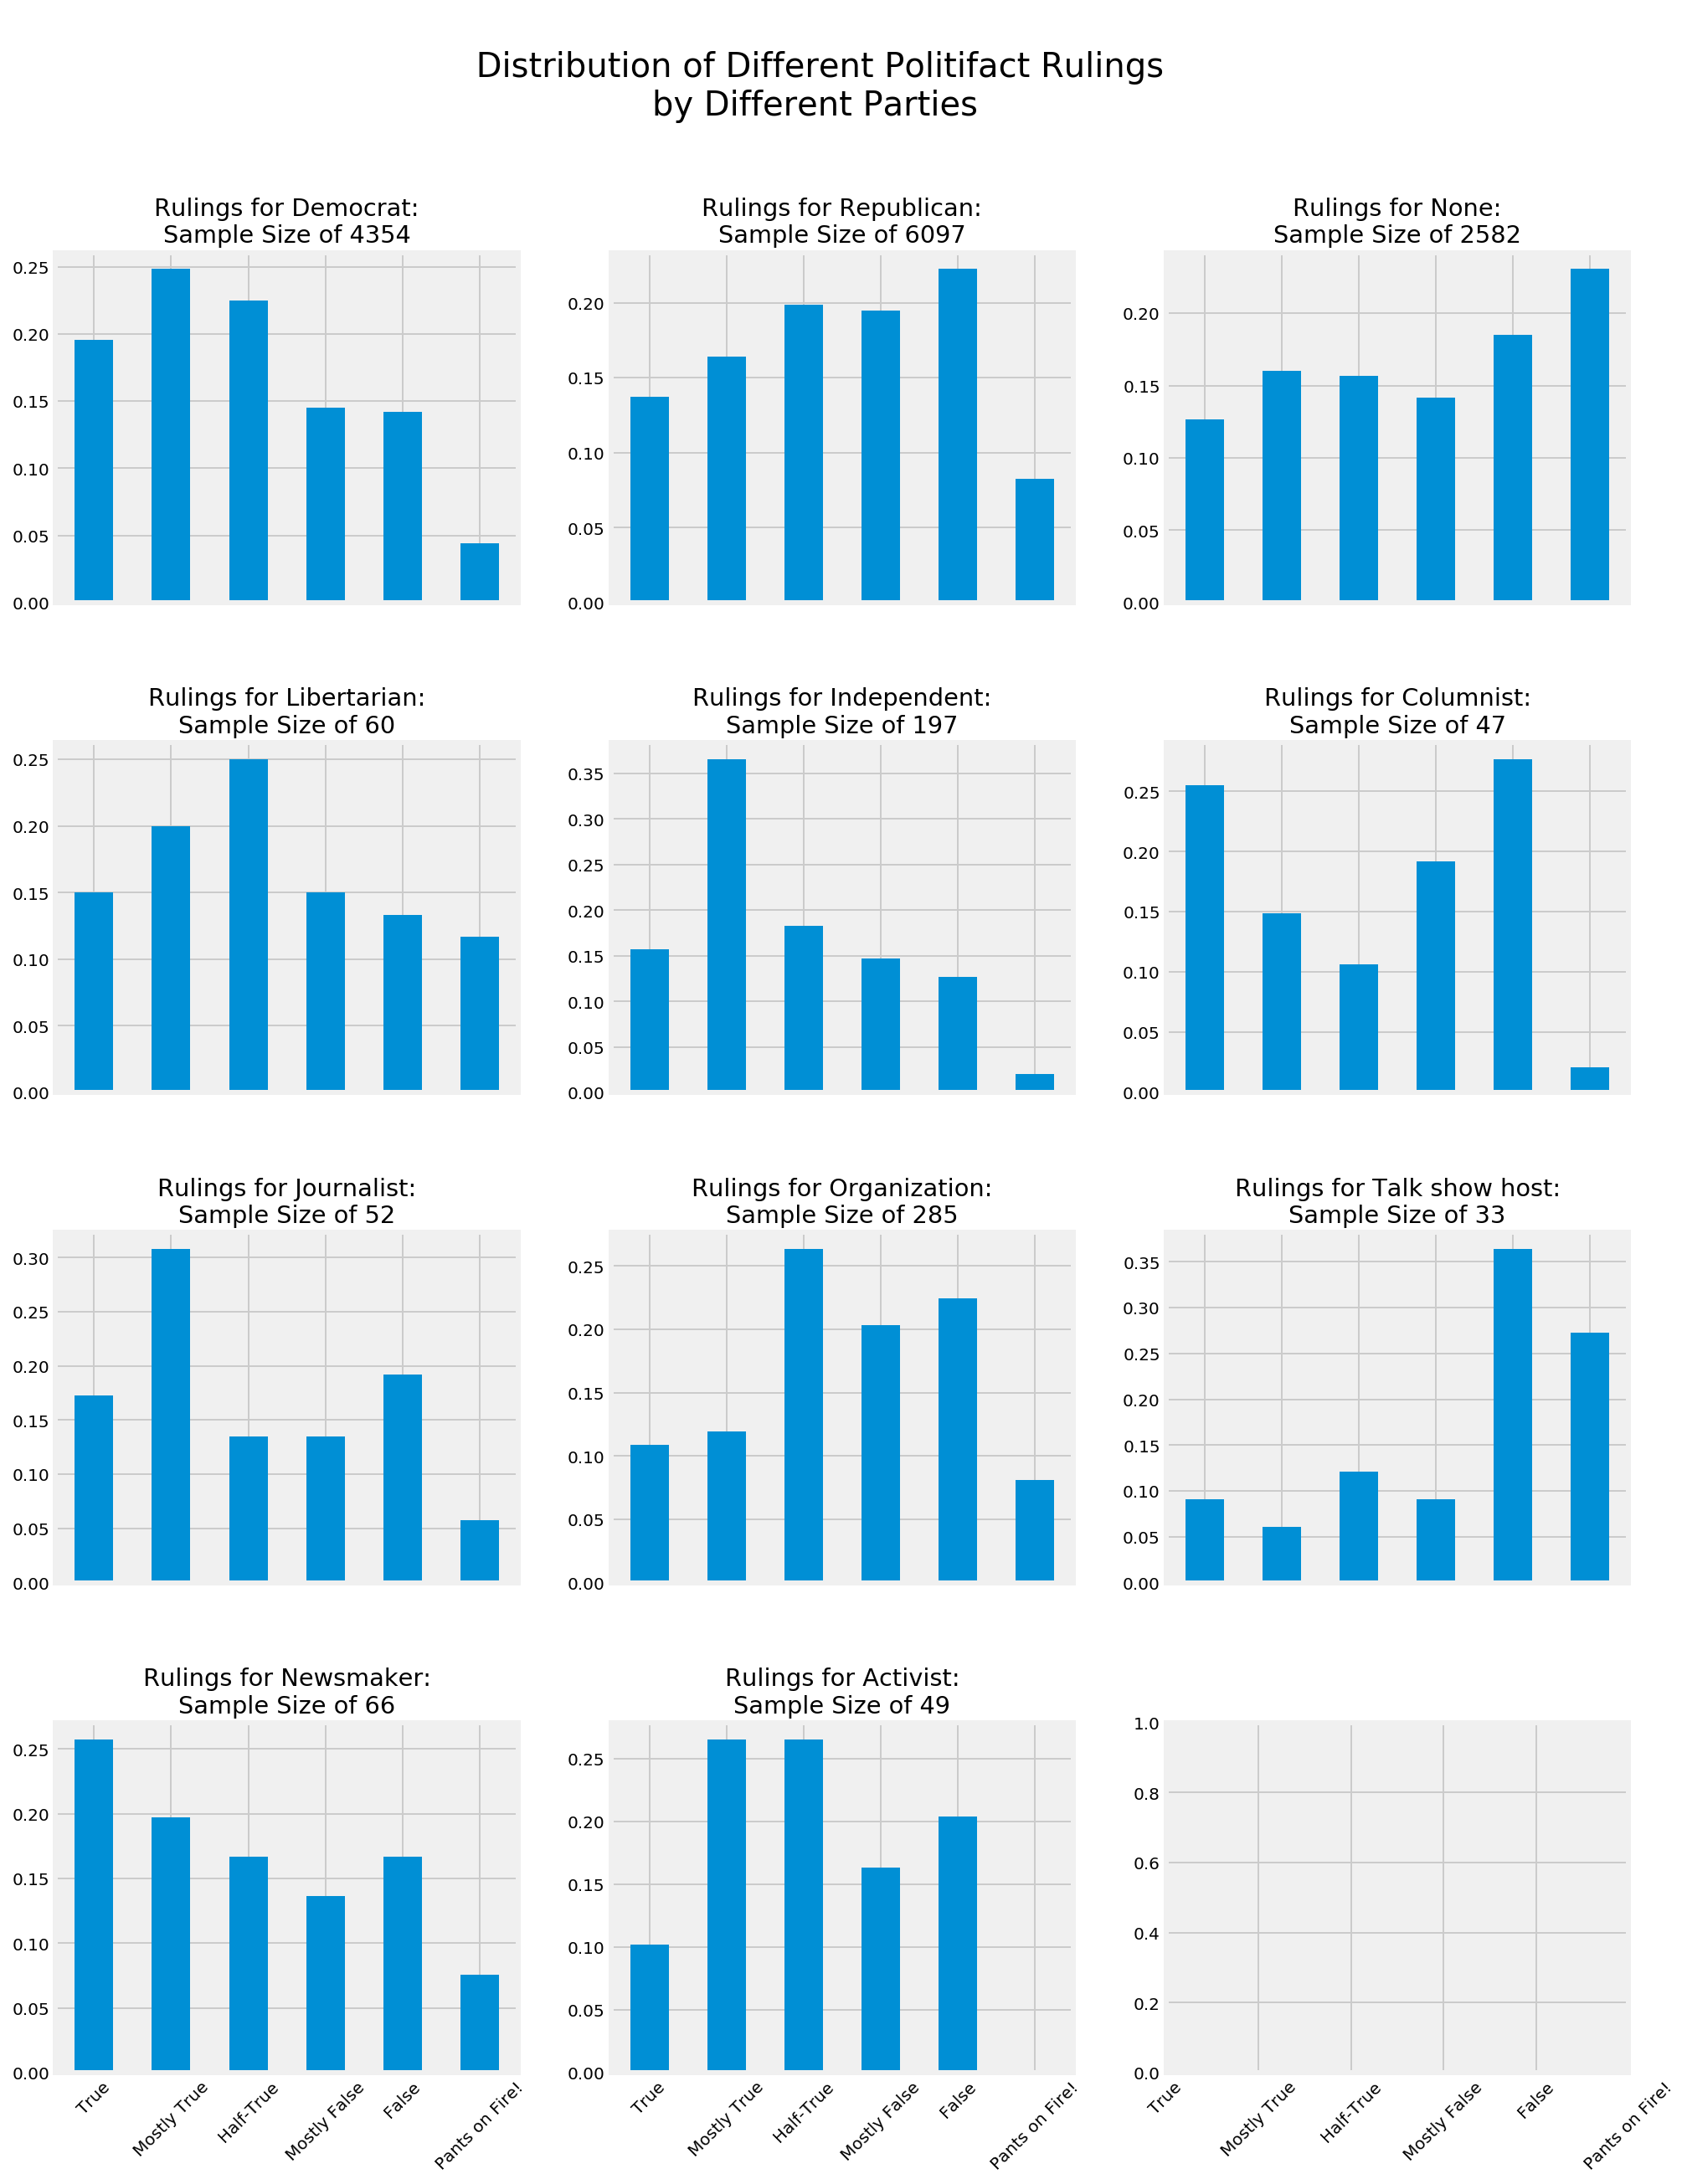

In [654]:
types = np.array(list(dfparty['speaker_party'].unique())+[' '])

fig, axs = plt.subplots(nrows=len(types)/3, ncols=3, figsize=(15,20))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('\n Distribution of Different Politifact Rulings\nby Different Parties',fontsize=20)

typesarray = np.array(types)
typesarray.shape = (len(types)/3,3)

for typ in types:
    try:
        row_pos = np.where(typesarray==typ)[0][0]
        col_pos = np.where(typesarray==typ)[1][0]
        typedf = dfparty.loc[dfparty['speaker_party']==typ]
        frequencies = pd.DataFrame(typedf['number_ruling'].value_counts())
        if typ == 'Activist':
            frequencies.loc[5] = 0
        frequencies.sort_index(inplace=True)
        frequencies['proportion'] = frequencies['number_ruling'].map(lambda x: float(x)/len(typedf))
        frequencies['proportion'].plot.bar(ax = axs[row_pos,col_pos])
        axs[row_pos,col_pos].set_title('Rulings for '+typ+':\nSample Size of '+str(len(typedf)))
        axs[row_pos,col_pos].set_xticklabels([])
    except: continue
        
for i in [0,1,2]:
    axs[3,i].set_xticklabels(['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'],rotation=45)

plt.show()

The key takeaways about political party:

- Apparently, never trust a talk show host? (Still a pretty small sample size, though!)
- More trustworthy than average: Independents, Democrats, Newsmakers, Journalists (fairly small sample sizes for those last two)
- Less trustworthy than average: Talk show hosts, Organizations, Republicans, and 'None'; as discussed above, 'None' is a bit of a problem for us, especially since it represents such a huge chunk of observations. 

#### Investigating subject

Now I'm going to see whether there are certain topics that seem to elicit a lot of lies in political discussion.  As with the political parties above, I'm going to probably want to eliminate subjects that have fewer than thirty observations associated with them for the purposes of this EDA.  

In [655]:
pd.set_option('display.max_rows',None)
df.subject.value_counts()

Economy                          1173
Health Care                      1036
Candidate Biography               757
Education                         745
Elections                         570
Federal Budget                    494
Crime                             493
Taxes                             424
Foreign Policy                    415
Immigration                       414
Abortion                          330
Energy                            326
State Budget                      255
Jobs                              245
Guns                              244
Campaign Finance                  236
Children                          226
Fake news                         216
Congress                          205
Corrections and Updates           197
Deficit                           186
Environment                       164
History                           161
Corporations                      141
Job Accomplishments               139
Climate Change                    137
Civil Rights

In [656]:
#function to create a dataframe including only the observations where, for a particular variable,
#there were at least thirty observations for that specific response
def morethanthirty(x,variable):
    counts = pd.DataFrame(x[variable].value_counts())
    counts = counts.loc[counts[variable]>=30]
    tokeep = list(counts.index)
    keptdf = x.loc[x[variable].isin(tokeep)]
    return keptdf

In [657]:
subjectdf = morethanthirty(df,'subject')
print subjectdf.shape
print df.shape

(13147, 16)
(13905, 16)


In [658]:
#for the binary variable 'lie':
subject_stats = subjectdf.groupby('subject').agg({'lie':['count','mean','median',mode,'std']})
subject_stats.columns = subject_stats.columns.get_level_values(1)
subject_stats

count      mean  median  mode       std
subject                                                          
Abortion                    330  0.472727       0     0  0.500014
Afghanistan                  60  0.350000       0     0  0.480995
Agriculture                  90  0.422222       0     0  0.496681
Alcohol                      40  0.425000       0     0  0.500641
Animals                      54  0.425926       0     0  0.499126
Bankruptcy                   42  0.357143       0     0  0.484966
Bipartisanship              114  0.324561       0     0  0.470278
Bush Administration          39  0.487179       0     0  0.506370
Campaign Finance            236  0.478814       0     0  0.500613
Candidate Biography         757  0.501982       1     1  0.500327
Cap and Trade                37  0.621622       1     1  0.491672
Census                       43  0.465116       0     0  0.504685
Children                    226  0.384956       0     0  0.487665
China                        55  0.509091       1     1  0.504525
City Budget                  94  0.478723       0     0  0.502226
City Government             104  0.394231       0     0  0.491051
Civil Rights                132  0.424242       0     0  0.496110
Climate Change              137  0.510949       1     1  0.501715
Congress                    205  0.487805       0     0  0.501075
Congressional Rules          40  0.450000       0     0  0.503831
Consumer Safety              30  0.433333       0     0  0.504007
Corporations                141  0.390071       0     0  0.489505
Corrections and Updates     197  0.507614       1     1  0.501216
County Budget                53  0.415094       0     0  0.497454
Crime                       493  0.425963       0     0  0.494990
Criminal Justice             95  0.347368       0     0  0.478660
Debates                      55  0.472727       0     0  0.503857
Debt                        110  0.354545       0     0  0.480565
Deficit                     186  0.370968       0     0  0.484368
Diversity                    67  0.492537       0     0  0.503718
Drugs                        76  0.315789       0     0  0.467918
Economy                    1173  0.353794       0     0  0.478350
Education                   745  0.379866       0     0  0.485679
Elections                   570  0.471930       0     0  0.499650
Energy                      326  0.490798       0     0  0.500684
Environment                 164  0.432927       0     0  0.496998
Ethics                      124  0.419355       0     0  0.495455
Fake news                   216  1.000000       1     1  0.000000
Families                     46  0.347826       0     0  0.481543
Federal Budget              494  0.396761       0     0  0.489722
Financial Regulation         38  0.526316       1     1  0.506009
Foreign Policy              415  0.508434       1     1  0.500532
Gays and Lesbians            70  0.471429       0     0  0.502787
Government Efficiency        81  0.419753       0     0  0.496593
Government regulation        53  0.490566       0     0  0.504695
Guns                        244  0.413934       0     0  0.493549
Health Care                1036  0.530888       1     1  0.499286
History                     161  0.484472       0     0  0.501318
Homeland Security           104  0.471154       0     0  0.501584
Housing                      44  0.227273       0     0  0.423915
Immigration                 414  0.492754       0     0  0.500552
Income                       79  0.354430       0     0  0.481397
Infrastructure               31  0.387097       0     0  0.495138
Iraq                         92  0.336957       0     0  0.475260
Job Accomplishments         139  0.482014       0     0  0.501484
Jobs                        245  0.371429       0     0  0.484176
Labor                        90  0.655556       1     1  0.477849
Legal Issues                 98  0.479592       0     0  0.502152
Medicare                     48  0.520833       1     1  0.504852


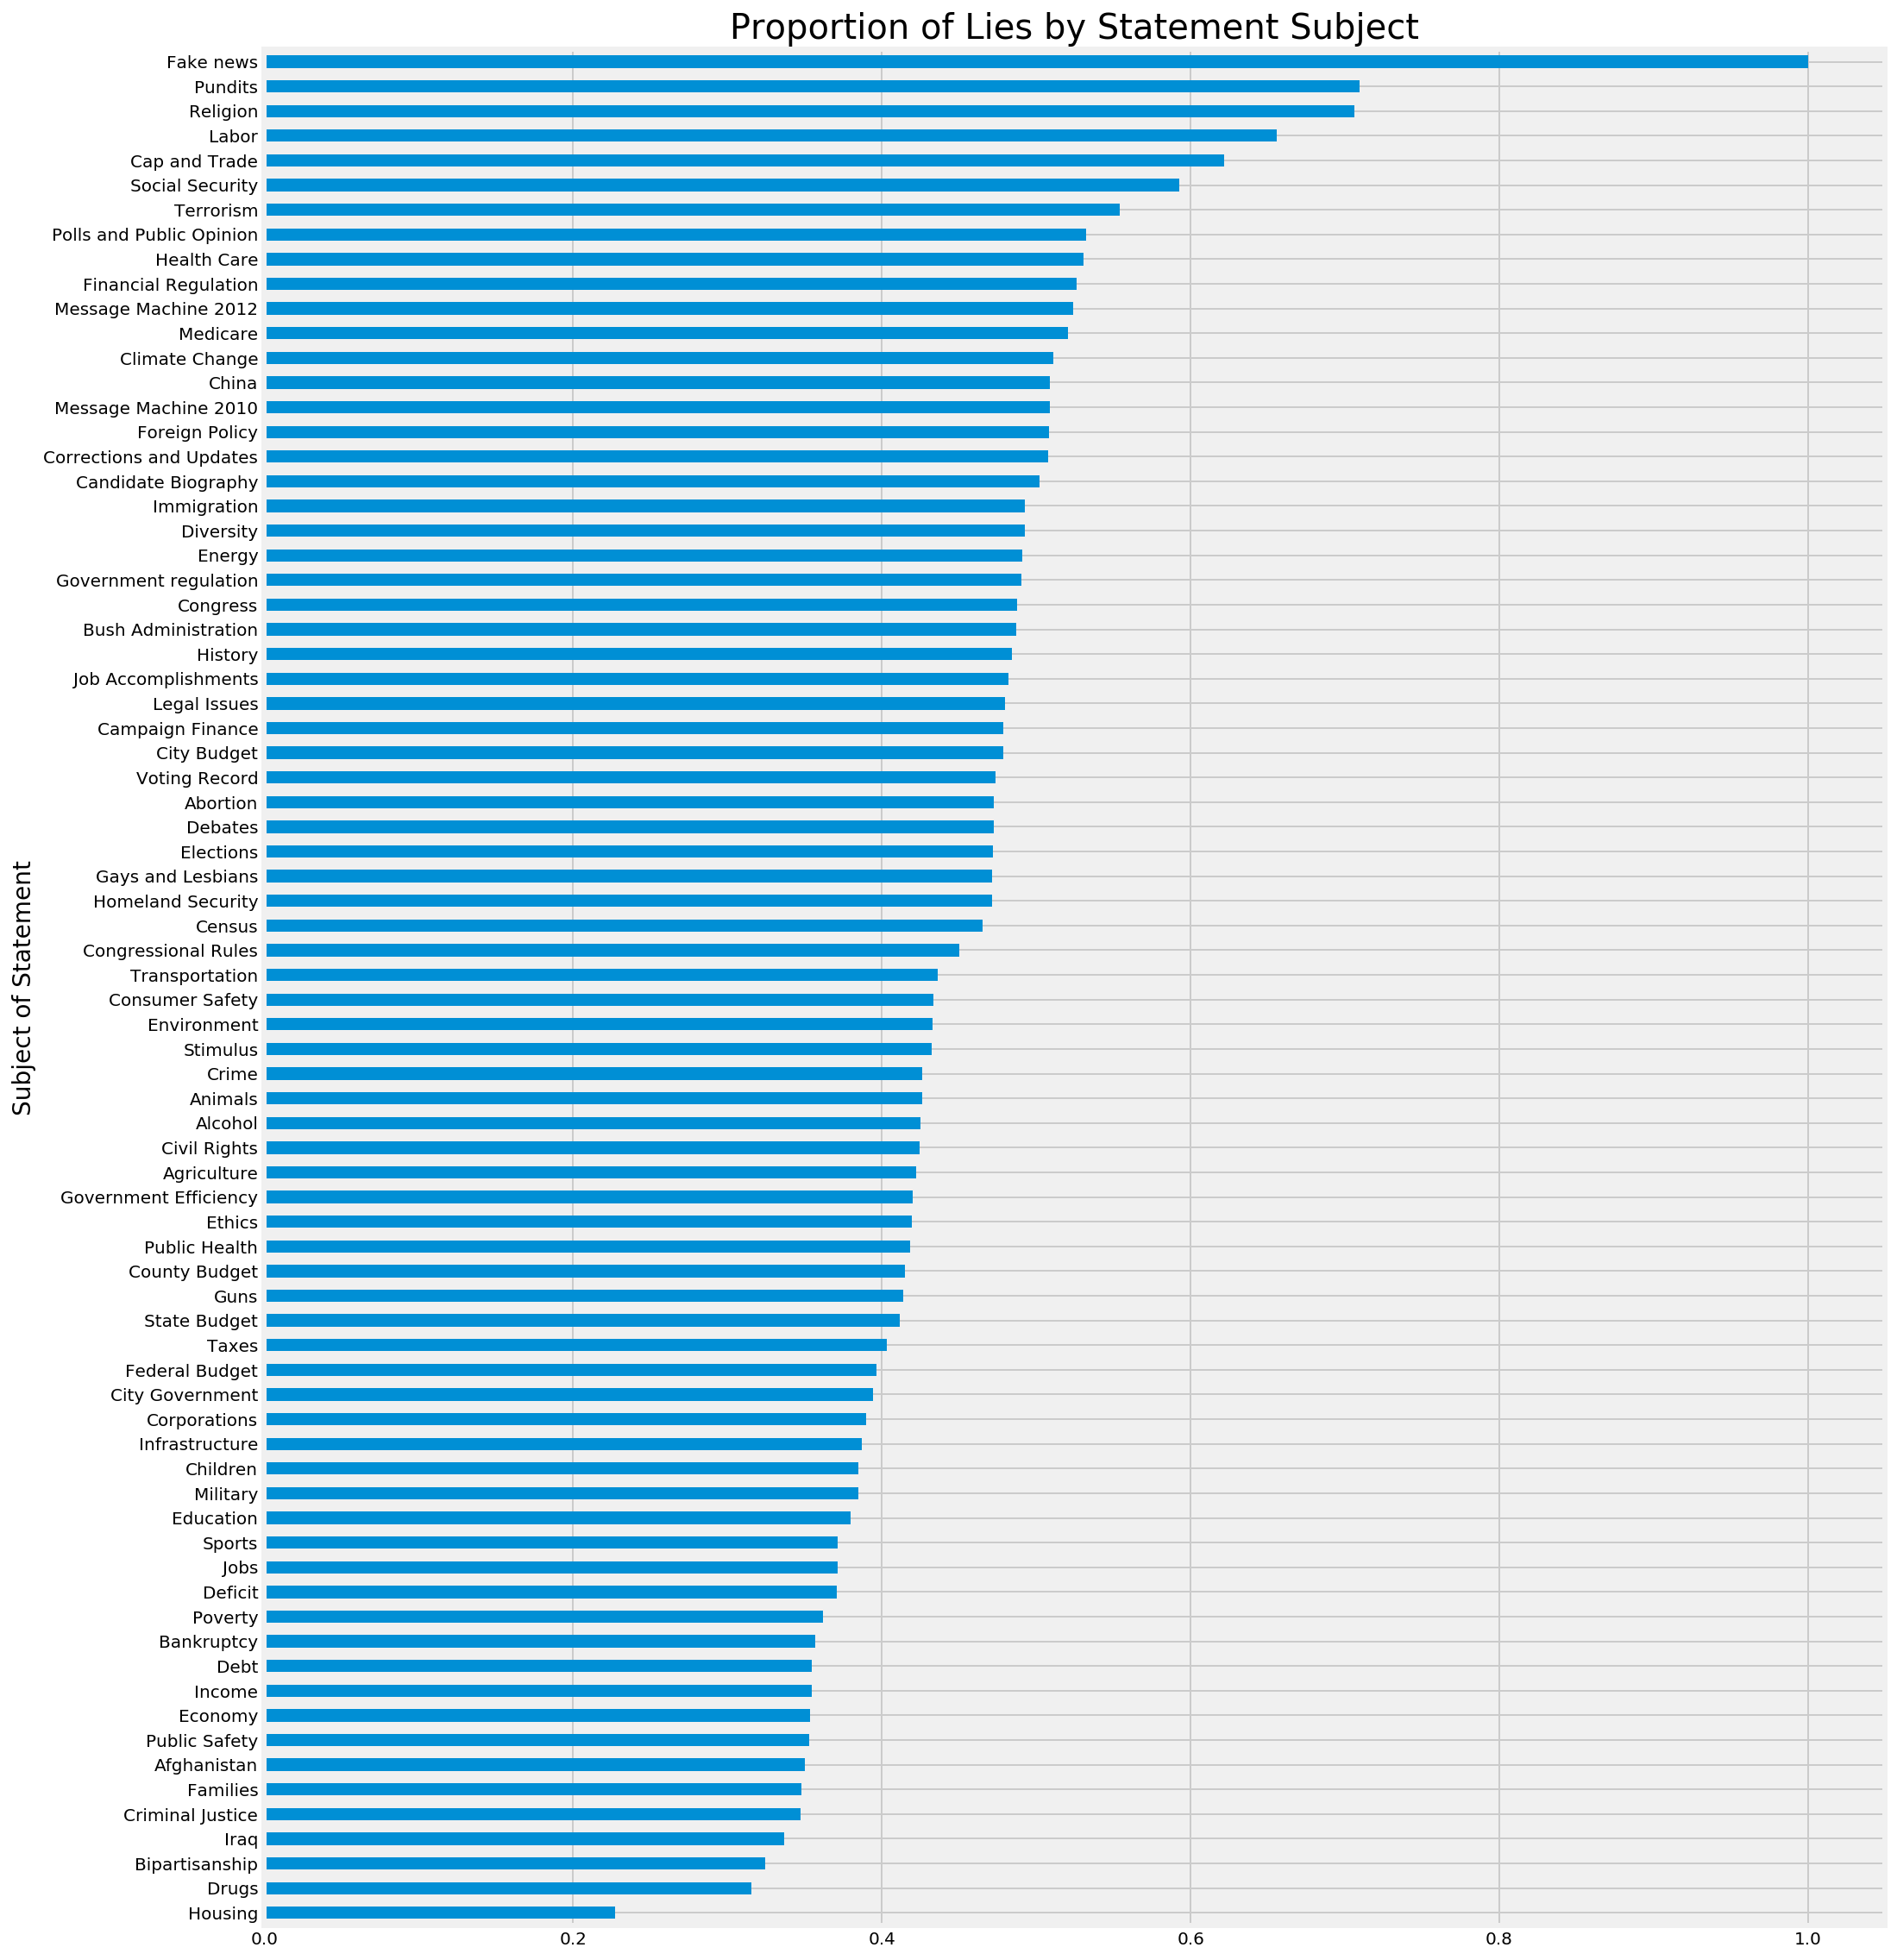

In [659]:
subject_stats.sort_values('mean',inplace=True,ascending=True)
subject_stats['mean'].plot.barh(figsize=(15,20))
plt.ylabel('Subject of Statement', fontsize=14)
plt.title('Proportion of Lies by Statement Subject',fontsize=20)
plt.show()

<span style="color: red">OH NO I HAVE MADE A TERRIBLE MISTAKE</span>

I've just done a little bit of investigation and realized that subjects are actually often lists on politifact, and in every case I've only pulled the first topic by alphabetical order!  This explains for example why 'Science' and 'Weather' seem to come up surprisingly infrequently (they don't! they just almost always have other tags that begin with letters earlier in the alphabet than 'S' and 'W').  I'm going to have to fix this before I can really come to grips with the 'subject' category.  

#### Investigating simple_context and simple_job

Neither simple_context nor simple_job are features that I'm necessarily happy with, because there are far too many unique entries in each one.  Nevertheless, I'm going to restrict them both down to those for which I have at least thirty observations and see what insights, if any, I can find.

In [660]:
#I just noticed that we have both chain e-mails and chain emails, so I want to clean that
df['simple_context'] = df['simple_context'].map(lambda x: 'a chain e-mail' if x=='a chain email' else x)

In [661]:
contextdf = morethanthirty(df,'simple_context')
jobdf = morethanthirty(df,'simple_job')

In [662]:
#unfortunately, this gets rid of an awful lot of observations:
print contextdf.shape
print jobdf.shape

(8143, 16)
(6823, 16)


In [663]:
#for the binary variable 'lie':
context_stats = contextdf.groupby('simple_context').agg({'lie':['count','mean','median',mode,'std']})
context_stats.columns = context_stats.columns.get_level_values(1)
context_stats

count      mean  median  mode       std
simple_context                                                        
Internet posts                    47  0.978723       1     1  0.145865
a Facebook post                  104  0.576923       1     1  0.496440
a TV ad                          394  0.461929       0     0  0.499182
a Web ad                          38  0.473684       0     0  0.506009
a blog post                       61  0.754098       1     1  0.434194
a campaign ad                    208  0.524038       1     1  0.500627
a campaign commercial             93  0.408602       0     0  0.494240
a campaign mailer                 48  0.625000       1     1  0.489246
a campaign video                  33  0.333333       0     0  0.478714
a chain e-mail                    89  0.921348       1     1  0.270720
a debate                         960  0.429167       0     0  0.495215
a headline                       100  0.990000       1     1  0.100000
a news conference                354  0.392655       0     0  0.489032
a news release                   903  0.436323       0     0  0.496204
a radio ad                        60  0.583333       1     1  0.497167
a speech                        1404  0.361111       0     0  0.480494
a statement                       41  0.292683       0     0  0.460646
a television ad                  163  0.484663       0     0  0.501305
a tweet                          317  0.498423       0     0  0.500788
a video                           30  0.366667       0     0  0.490133
an ad                             41  0.317073       0     0  0.471117
an article                        33  0.363636       0     0  0.488504
an email                          31  0.612903       1     1  0.495138
an interview                    2329  0.446544       0     0  0.497241
an op-ed                         182  0.340659       0     0  0.475238
comments on "Fox News Sunday"     35  0.400000       0     0  0.497050
comments on ABC's "This Week"     45  0.377778       0     0  0.490310

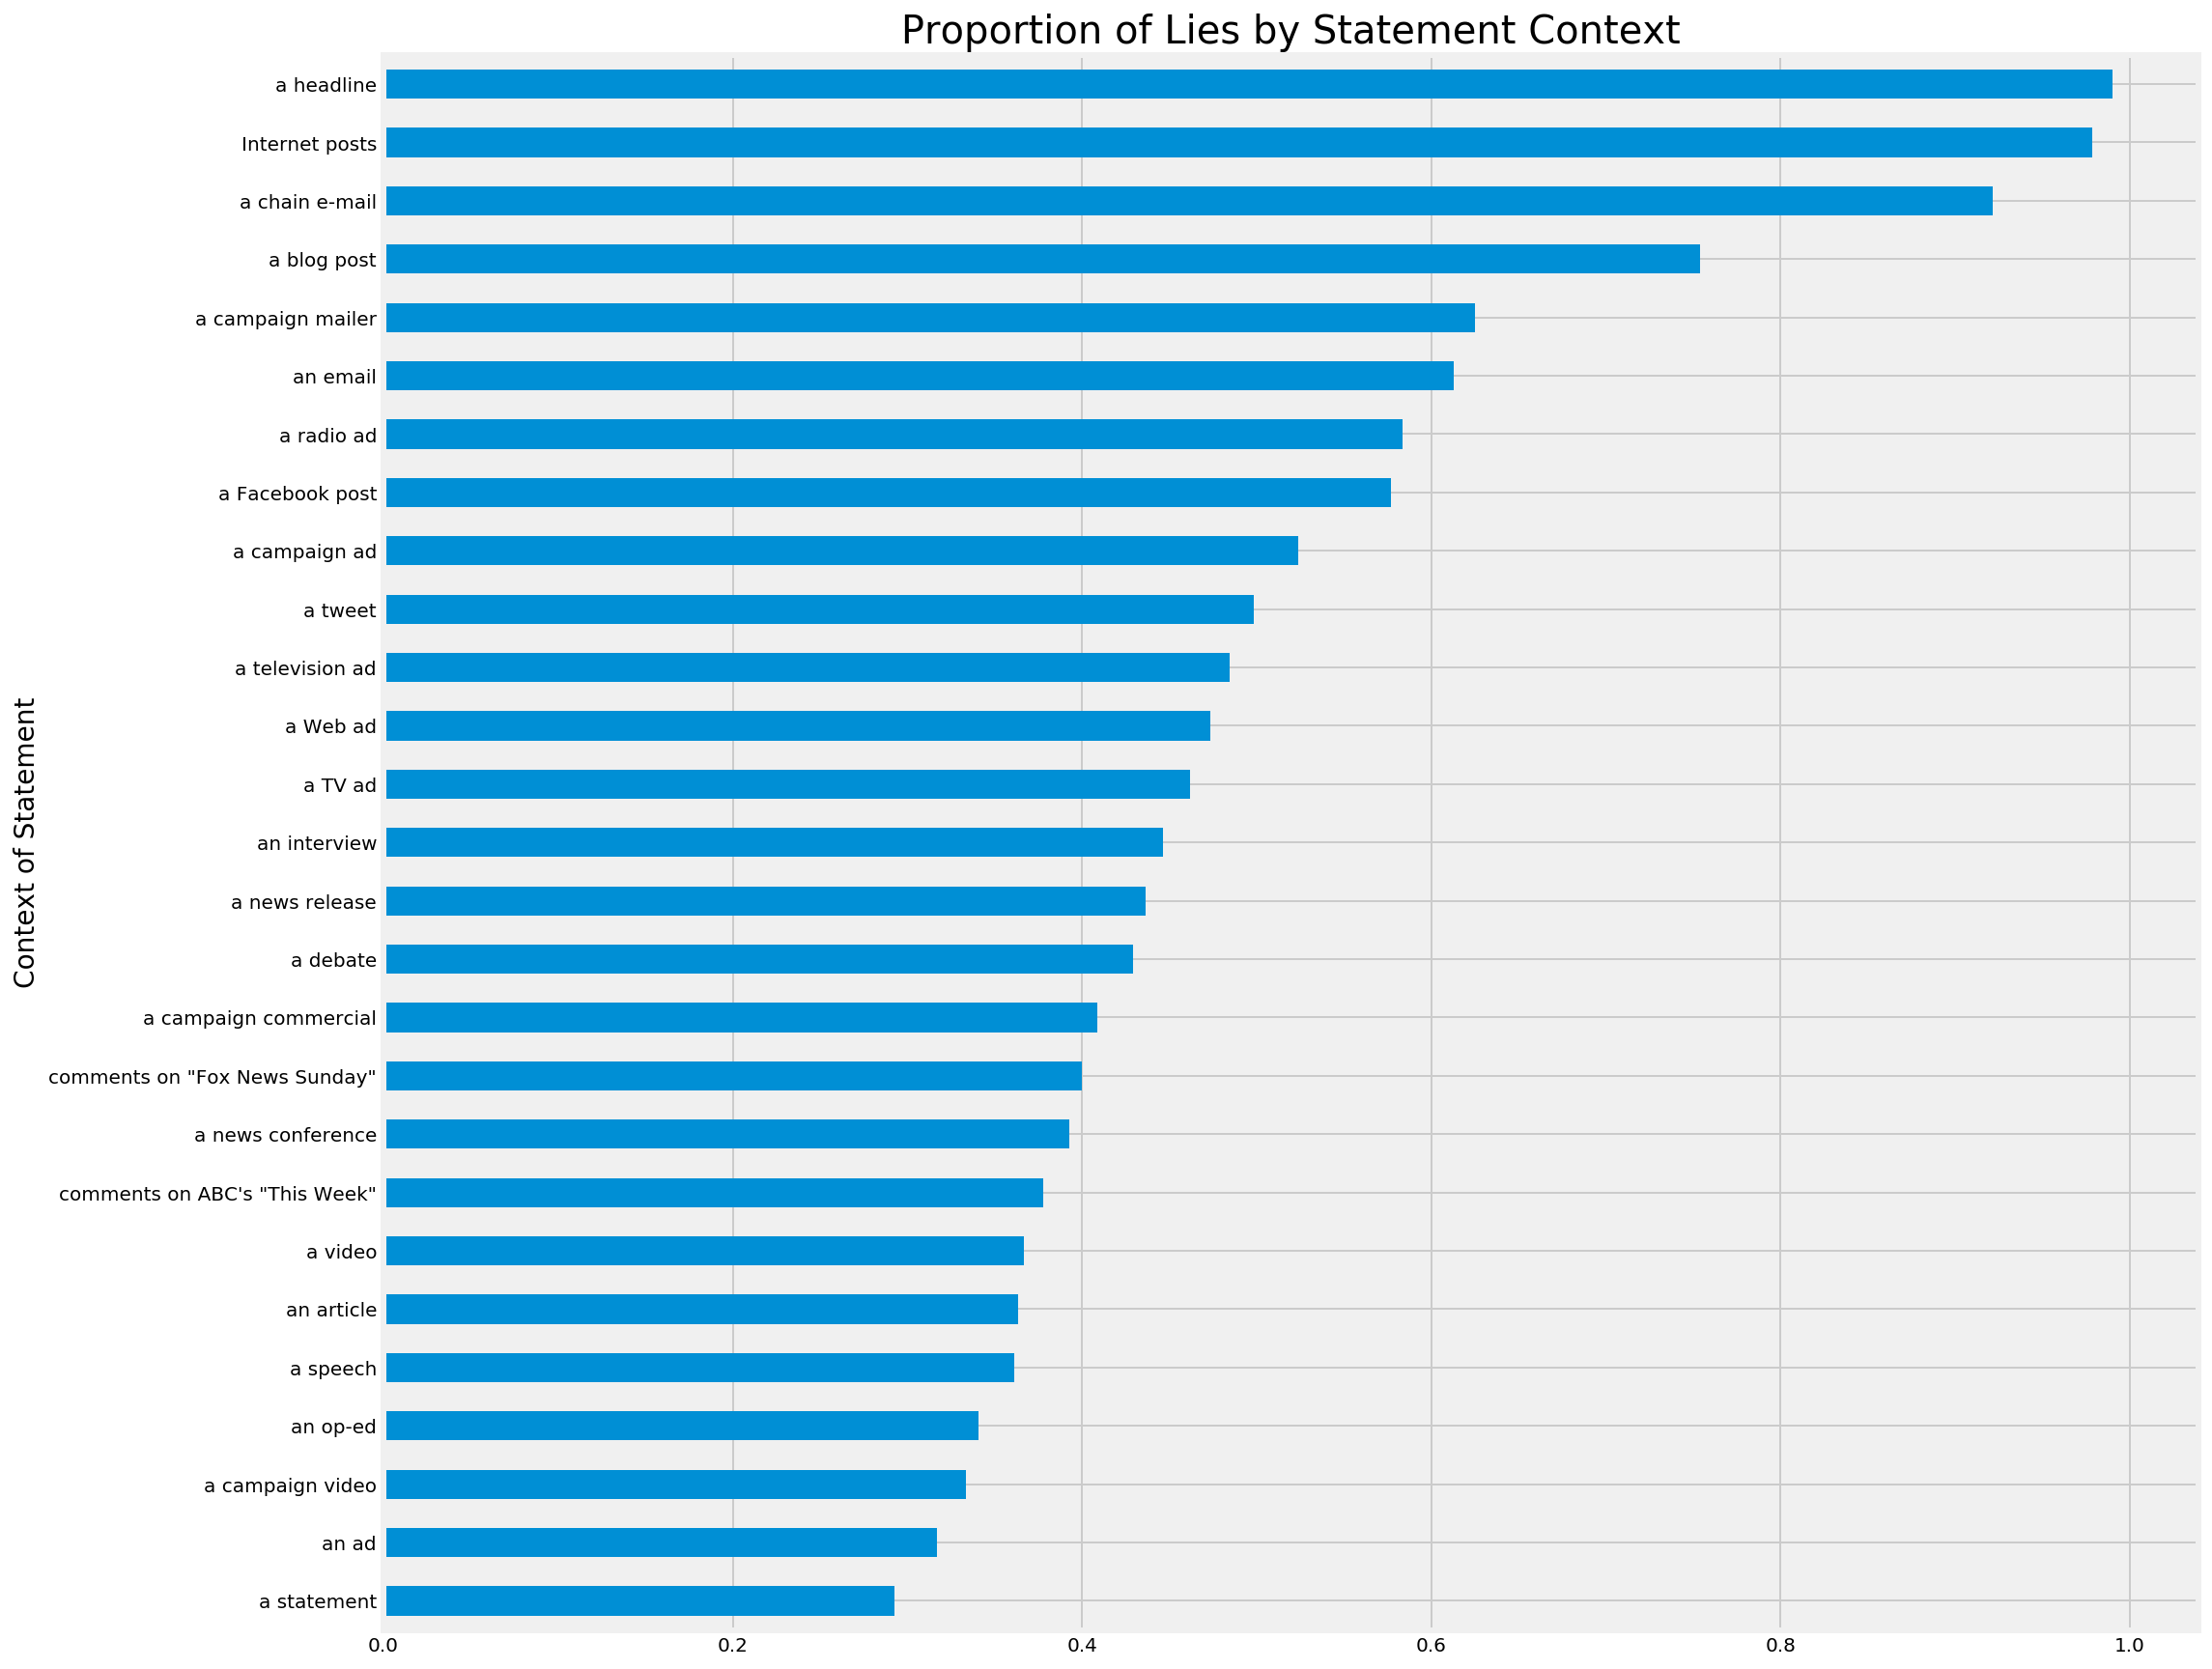

In [664]:
context_stats.sort_values('mean',inplace=True,ascending=True)
context_stats['mean'].plot.barh(figsize=(15,15))
plt.ylabel('Context of Statement', fontsize=14)
plt.title('Proportion of Lies by Statement Context',fontsize=20)
plt.show()

In [665]:
#for number_ruling, from 0 to 5
context_stats2 = contextdf.groupby('simple_context').agg({'number_ruling':['count','mean','median',mode,'std','min','max']})
context_stats2.columns = context_stats2.columns.get_level_values(1)
context_stats2

count      mean  median  mode       std  min  \
simple_context                                                                
Internet posts                    47  4.744681       5     5  0.820076    0   
a Facebook post                  104  2.836538       3     3  1.507976    0   
a TV ad                          394  2.360406       2     2  1.448718    0   
a Web ad                          38  2.631579       2     2  1.496321    0   
a blog post                       61  3.622951       4     5  1.684873    0   
a campaign ad                    208  2.461538       3     3  1.354349    0   
a campaign commercial             93  2.247312       2     2  1.364582    0   
a campaign mailer                 48  2.854167       3     3  1.288073    0   
a campaign video                  33  1.818182       2     1  1.445998    0   
a chain e-mail                    89  4.303371       5     5  1.059636    0   
a debate                         960  2.227083       2     2  1.510649    0   
a headline                       100  4.770000       5     5  0.617178    1   
a news conference                354  2.124294       2     1  1.543084    0   
a news release                   903  2.191584       2     2  1.548140    0   
a radio ad                        60  2.533333       3     3  1.213856    0   
a speech                        1404  2.027778       2     1  1.520100    0   
a statement                       41  1.804878       2     1  1.364176    0   
a television ad                  163  2.527607       2     2  1.343998    0   
a tweet                          317  2.397476       2     4  1.577049    0   
a video                           30  2.066667       2     1  1.362891    0   
an ad                             41  2.097561       2     2  1.157689    0   
an article                        33  1.939394       2     0  1.712808    0   
an email                          31  3.032258       4     4  1.702623    0   
an interview                    2329  2.286818       2     4  1.527301    0   
an op-ed                         182  1.884615       2     1  1.407511    0   
comments on "Fox News Sunday"     35  2.200000       2     1  1.410048    0   
comments on ABC's "This Week"     45  1.977778       2     2  1.373266    0   

                               max  
simple_context                      
Internet posts                   5  
a Facebook post                  5  
a TV ad                          5  
a Web ad                         5  
a blog post                      5  
a campaign ad                    5  
a campaign commercial            5  
a campaign mailer                5  
a campaign video                 5  
a chain e-mail                   5  
a debate                         5  
a headline                       5  
a news conference                5  
a news release                   5  
a radio ad                       5  
a speech                         5  
a statement                      4  
a television ad                  5  
a tweet                          5  
a video                          5  
an ad                            5  
an article                       5  
an email                         5  
an interview                     5  
an op-ed                         5  
comments on "Fox News Sunday"    5  
comments on ABC's "This Week"    4

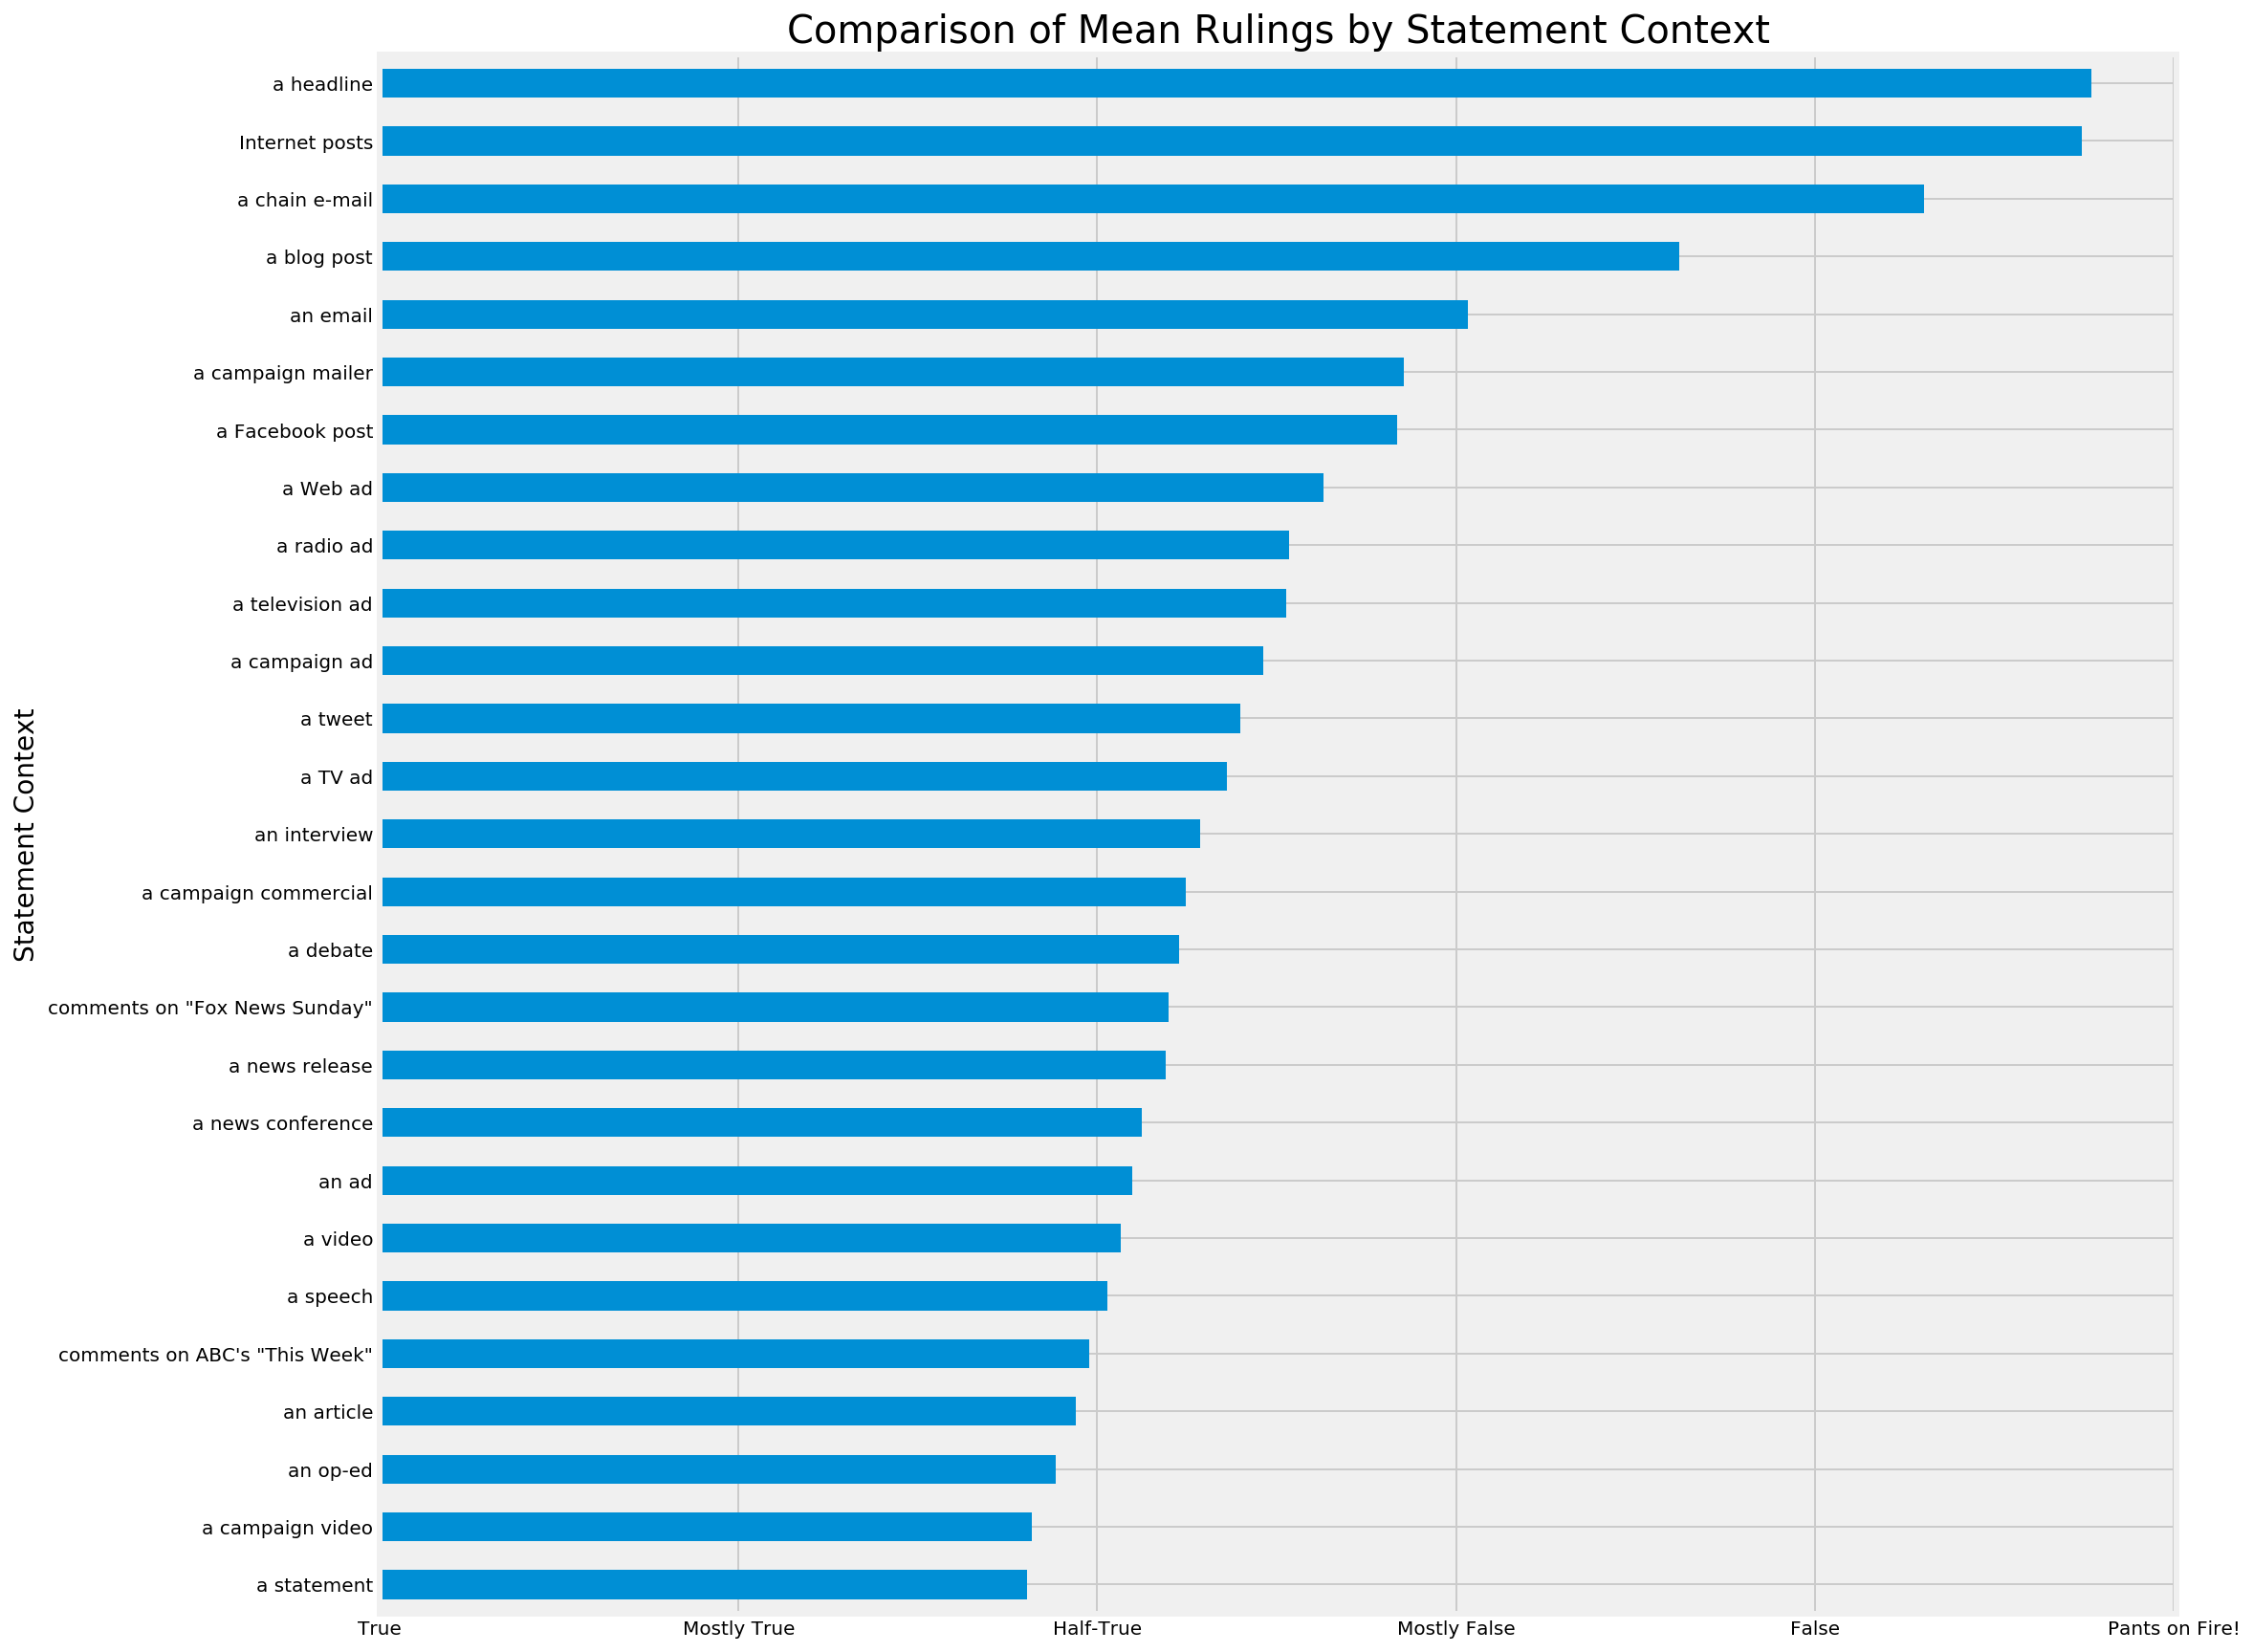

In [666]:
context_stats2.sort_values('mean',inplace=True,ascending=True)
context_stats2['mean'].plot.barh(figsize=(15,15))
plt.ylabel('Statement Context', fontsize=14)
plt.title('Comparison of Mean Rulings by Statement Context', fontsize=20)
plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

Context takeaways:

- Don't trust headlines, internet posts, chain e-mails, and blog posts
- Put a bit more trust in statements, op-eds, articles, campaign videos, and speeches
- Even after I've cleaned this, I'm still very not happy with this feature.  For instance, what does 'an ad' mean?  Is it a television ad? Radio ad? Web ad?  It's really frustrating that there wasn't consistency in the recording of these contexts.
- On the other hand, there are massive differences between the different statement contexts, so if I could achieve a bit more consistency, I think that it might end up being really helpful.

Investigating the speaker job:

In [667]:
#for the binary variable 'lie':
job_stats = jobdf.groupby('simple_job').agg({'lie':['count','mean','median',mode,'std']})
job_stats.columns = job_stats.columns.get_level_values(1)
job_stats

count      mean  median  mode  \
simple_job                                                               
Attorney                                   110  0.500000     0.5     1   
Attorney General                            33  0.393939     0.0     0   
Businessman                                 45  0.466667     0.0     0   
Candidate for U.S. Senate and physician     55  0.345455     0.0     0   
Chairman, Republican National Committee     30  0.566667     1.0     1   
Columnist                                   35  0.428571     0.0     0   
Governor                                  1018  0.397839     0.0     0   
House Majority Leader                       43  0.488372     0.0     0   
House Minority Leader                       37  0.432432     0.0     0   
Lawyer                                      67  0.477612     0.0     0   
Madison school board member                 34  0.382353     0.0     0   
Milwaukee County Executive                 182  0.456044     0.0     0   
Ohio treasurer                              31  0.516129     1.0     1   
Political Action Committee                  59  0.491525     0.0     0   
President                                 1084  0.446494     0.0     0   
Presidential candidate                     312  0.266026     0.0     0   
Radio host                                  40  0.825000     1.0     1   
Secretary of State                          37  0.486486     0.0     0   
Senate minority leader                      30  0.433333     0.0     0   
Social media posting                        99  0.676768     1.0     1   
Speaker of the House of Representatives     73  0.547945     1.0     1   
State Assembly Member                       96  0.406250     0.0     0   
State Representative                       271  0.464945     0.0     0   
State Senator                              330  0.393939     0.0     0   
U.S. Energy Secretary                      171  0.461988     0.0     0   
U.S. Representative                       1135  0.453744     0.0     0   
U.S. Senator                              1246  0.356340     0.0     0   
author                                      44  0.545455     1.0     1   
consultant                                  35  0.400000     0.0     0   
former president                            41  0.219512     0.0     0   

                                              std  
simple_job                                         
Attorney                                 0.502288  
Attorney General                         0.496198  
Businessman                              0.504525  
Candidate for U.S. Senate and physician  0.479899  
Chairman, Republican National Committee  0.504007  
Columnist                                0.502096  
Governor                                 0.489692  
House Majority Leader                    0.505781  
House Minority Leader                    0.502247  
Lawyer                                   0.503268  
Madison school board member              0.493270  
Milwaukee County Executive               0.499438  
Ohio treasurer                           0.508001  
Political Action Committee               0.504219  
President                                0.497358  
Presidential candidate                   0.442588  
Radio host                               0.384808  
Secretary of State                       0.506712  
Senate minority leader                   0.504007  
Social media posting                     0.470091  
Speaker of the House of Representatives  0.501140  
State Assembly Member                    0.493710  
State Representative                     0.499692  
State Senator                            0.489364  
U.S. Energy Secretary                    0.500017  
U.S. Representative                      0.498075  
U.S. Senator                             0.479110  
author                                   0.503686  
consultant                               0.497050  
former president                         0.419058

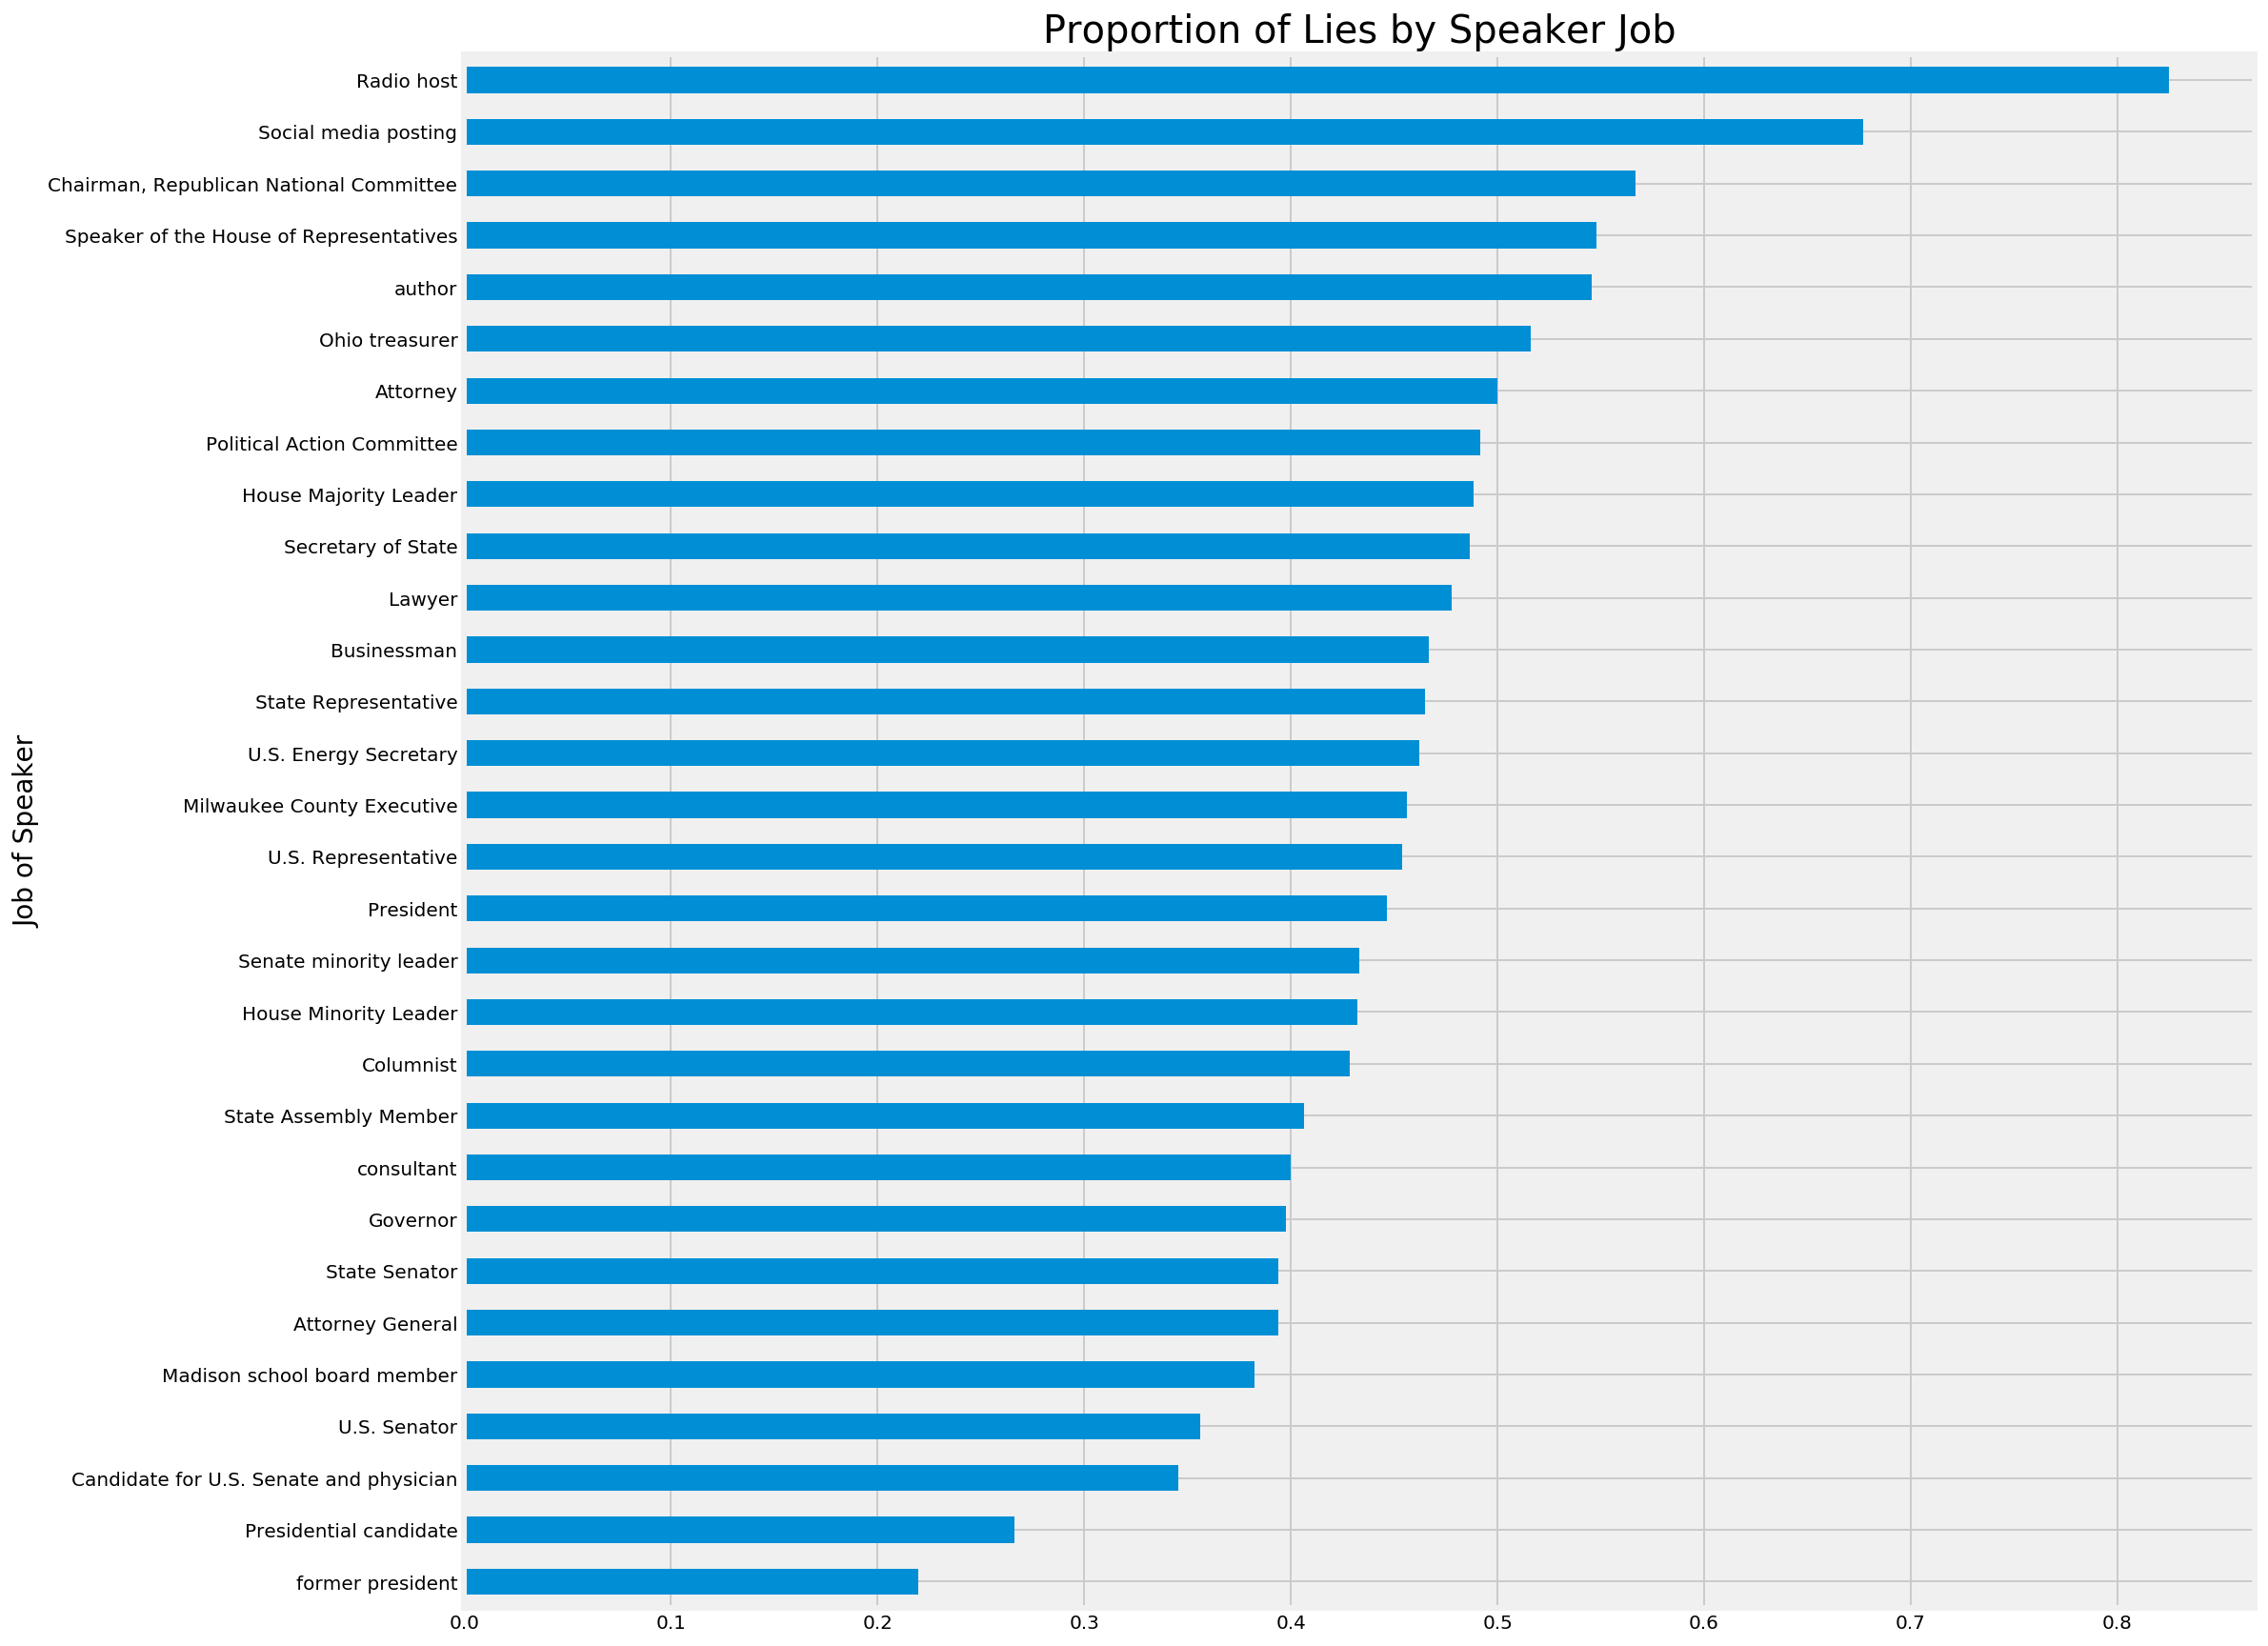

In [668]:
job_stats.sort_values('mean',inplace=True,ascending=True)
job_stats['mean'].plot.barh(figsize=(15,15))
plt.ylabel('Job of Speaker', fontsize=14)
plt.title('Proportion of Lies by Speaker Job',fontsize=20)
plt.show()

In [669]:
#for number_ruling, from 0 to 5

def unique(x): #to find, for example, how many unique speakers there were associated with each job
    return len(x.unique())

job_stats2 = jobdf.groupby('simple_job').agg({'number_ruling':['count','mean','median',mode,'std','min','max'],'speaker':[unique]})
job_stats2.columns = job_stats2.columns.get_level_values(1)
job_stats2

count      mean  median  mode  \
simple_job                                                               
Attorney                                   110  2.472727     2.5     4   
Attorney General                            33  2.181818     2.0     4   
Businessman                                 45  2.222222     2.0     3   
Candidate for U.S. Senate and physician     55  1.963636     2.0     2   
Chairman, Republican National Committee     30  2.933333     3.5     4   
Columnist                                   35  1.942857     2.0     0   
Governor                                  1018  2.186640     2.0     2   
House Majority Leader                       43  2.348837     2.0     3   
House Minority Leader                       37  2.405405     2.0     2   
Lawyer                                      67  2.358209     2.0     0   
Madison school board member                 34  2.352941     2.0     2   
Milwaukee County Executive                 182  2.313187     2.0     4   
Ohio treasurer                              31  2.580645     3.0     5   
Political Action Committee                  59  2.559322     2.0     2   
President                                 1084  2.336716     2.0     4   
Presidential candidate                     312  1.685897     2.0     1   
Radio host                                  40  3.650000     4.0     5   
Secretary of State                          37  2.189189     2.0     3   
Senate minority leader                      30  2.100000     2.0     1   
Social media posting                        99  3.353535     4.0     5   
Speaker of the House of Representatives     73  2.410959     3.0     4   
State Assembly Member                       96  1.979167     2.0     1   
State Representative                       271  2.261993     2.0     4   
State Senator                              330  2.103030     2.0     2   
U.S. Energy Secretary                      171  2.409357     2.0     2   
U.S. Representative                       1135  2.303965     2.0     4   
U.S. Senator                              1246  1.942215     2.0     1   
author                                      44  2.500000     3.0     3   
consultant                                  35  2.057143     2.0     0   
former president                            41  1.707317     2.0     2   

                                              std  min  max  unique  
simple_job                                                           
Attorney                                 1.488236    0    5      37  
Attorney General                         1.590097    0    5       6  
Businessman                              1.636083    0    5      22  
Candidate for U.S. Senate and physician  1.551148    0    5       1  
Chairman, Republican National Committee  1.284747    0    5       1  
Columnist                                1.625945    0    5       3  
Governor                                 1.496156    0    5      67  
House Majority Leader                    1.601840    0    5       3  
House Minority Leader                    1.480605    0    5       1  
Lawyer                                   1.746872    0    5      39  
Madison school board member              1.390059    0    5       1  
Milwaukee County Executive               1.510823    0    5       1  
Ohio treasurer                           1.875708    0    5       2  
Political Action Committee               1.477080    0    5      30  
President                                1.523621    0    5       4  
Presidential candidate                   1.367065    0    5       2  
Radio host                               1.188621    1    5       2  
Secretary of State                       1.411025    0    4       9  
Senate minority leader                   1.373392    0    4       1  
Social media posting                     1.637028    0    5       1  
Speaker of the House of Representatives  1.614480    0    5       2  
State Assembly Member                    1.589301    0    5   

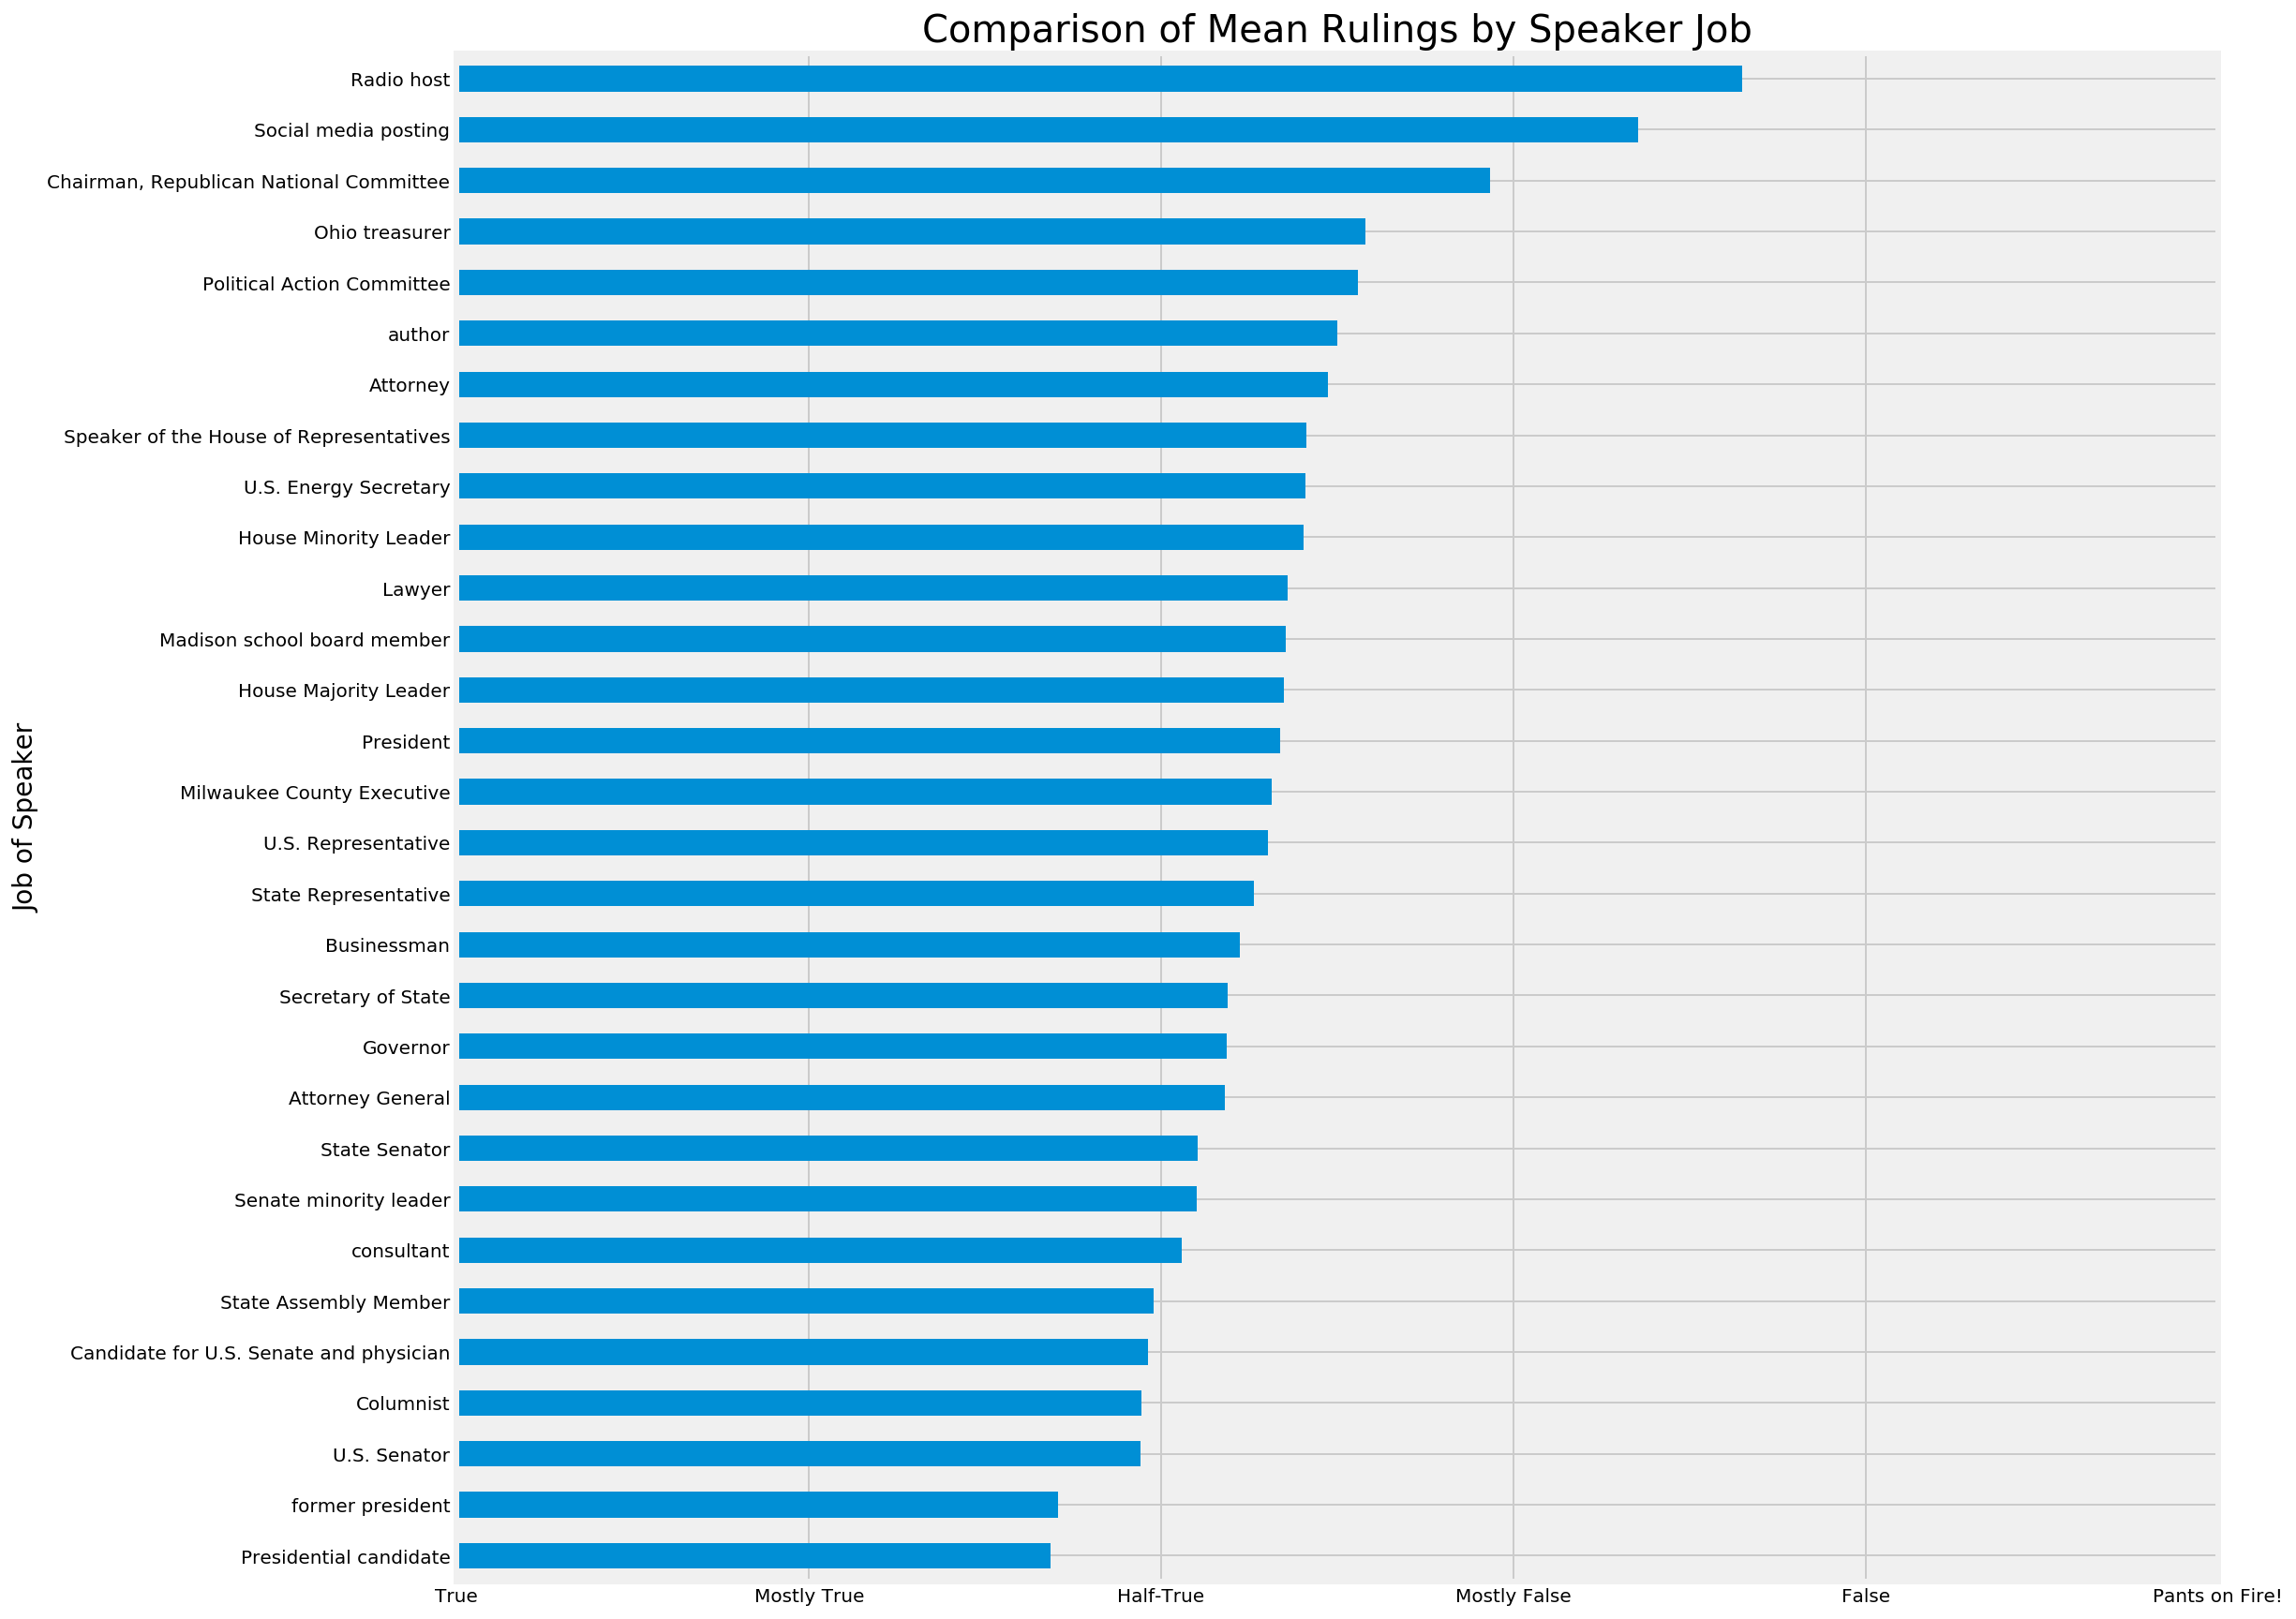

In [670]:
job_stats2.sort_values('mean',inplace=True,ascending=True)
job_stats2['mean'].plot.barh(figsize=(15,15))
plt.ylabel('Job of Speaker', fontsize=14)
plt.title('Comparison of Mean Rulings by Speaker Job', fontsize=20)
plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

Reflections on simple_job:

Some of these jobs seem a lot more potentially helpful than others.  For example, I think it's quite interesting that US Senators seem to be generally slightly more truthful than US Representatives.  (One hypothesis: maybe because they have much longer terms -- 6 years versus 2 years -- so they don't have to stir up their base quite as often to win elections?)  On the other hand, as seen in the table above, an awful lot of these jobs are actually associated with only one or two people ('former president' and 'Radio host' for example).  I'm going to just compare those groups that are actually associated with more than a handful of people:

/Users/eleanorkoller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


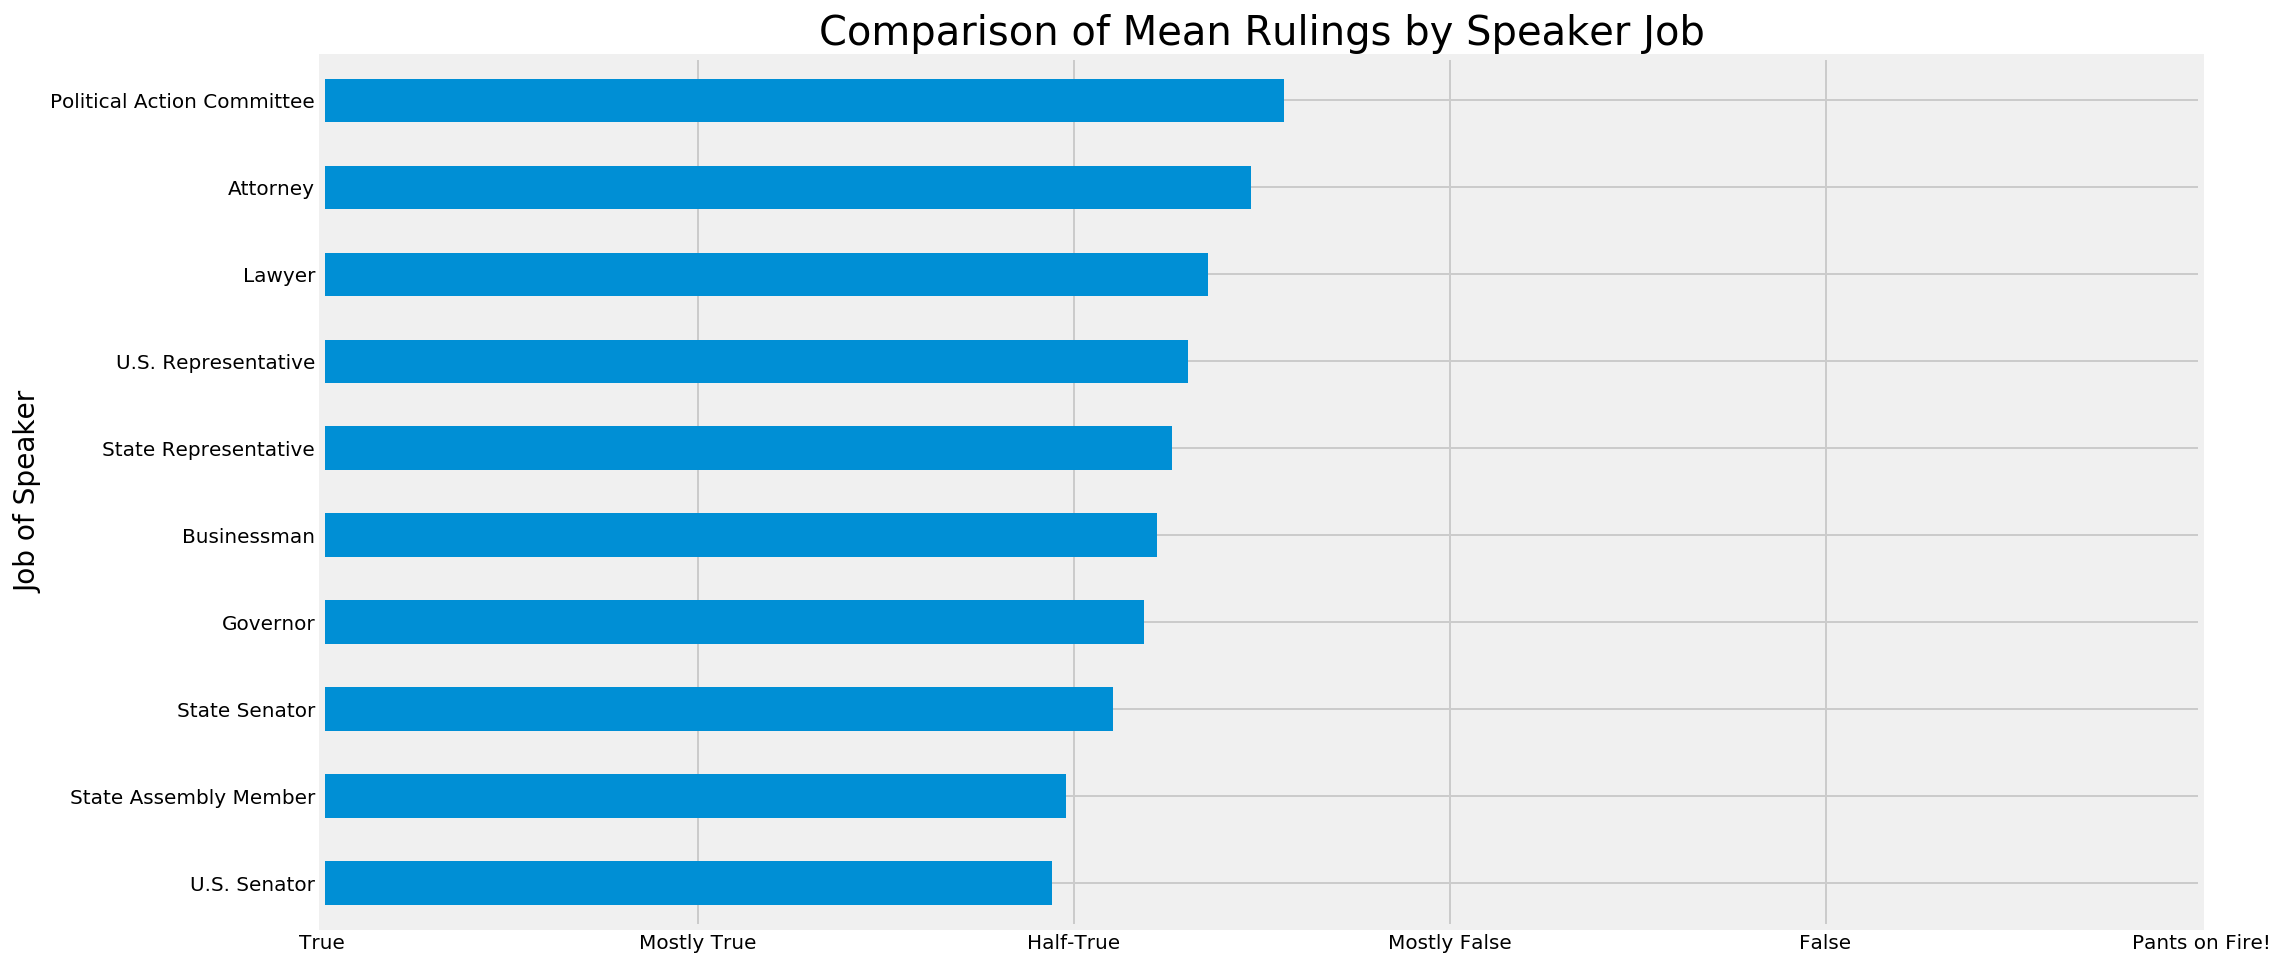

In [671]:
job_stats2 = job_stats2.loc[job_stats2['unique']>=20]
job_stats2.sort_values('mean',inplace=True,ascending=True)
job_stats2['mean'].plot.barh(figsize=(15,8))
plt.ylabel('Job of Speaker', fontsize=14)
plt.title('Comparison of Mean Rulings by Speaker Job', fontsize=20)
plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

Once we take out the jobs that are actually just one person or a handful of people, we're left with some differences, but they're not that pronounced.  Political Action Committees and lawyers/attorneys seem to be less trustworthy, and Senators, State Assembly Members, and State Senators seem to be more trustworthy, but the differences are not huge, and almost all of these groups edge slightly more towards truth-telling (but only slightly, and not PACs or attorneys).

Overall, I'm not sure that this is the most helpful feature for predicting lies.  It isn't revealing as dramatic differences as the other features that we've looked at so far.

#### Investigating speaker:

I think it's quite likely that the speaker is a pretty strong determinant of truthfulness for some statements, but I also think that there are probably QUITE a lot of speakers that don't have very many observations associated with them, so it won't necessarily be helpful across the board.  Let's see!

In [672]:
speakerdf = morethanthirty(df,'speaker')

In [673]:
speakerdf.shape #this gets rid of more than half of our observations!

(5293, 16)

In [674]:
#for the binary variable 'lie':
speaker_stats = speakerdf.groupby('speaker').agg({'lie':['count','mean','median',mode,'std']})
speaker_stats.columns = speaker_stats.columns.get_level_values(1)
speaker_stats

count      mean  median  mode  \
speaker                                                                       
 Bloggers                                       238  0.949580       1     1   
 Chain email                                    180  0.894444       1     1   
 Democratic Congressional Campaign Committee     34  0.823529       1     1   
 Democratic National Committee                   35  0.285714       0     0   
 Facebook posts                                  99  0.676768       1     1   
 National Republican Congressional Committee     53  0.679245       1     1   
 National Republican Senatorial Committee        32  0.718750       1     1   
 Republican National Committee                   34  0.411765       0     0   
 Republican Party of Florida                     34  0.588235       1     1   
 Viral image                                     33  0.909091       1     1   
Alan Grayson                                     33  0.363636       0     0   
Barack Obama                                    598  0.250836       0     0   
Bernie Sanders                                  118  0.279661       0     0   
Bill Clinton                                     41  0.219512       0     0   
Bob McDonnell                                    35  0.400000       0     0   
Charlie Crist                                    80  0.325000       0     0   
Chris Christie                                  102  0.343137       0     0   
David Dewhurst                                   40  0.525000       1     1   
Debbie Wasserman Schultz                         48  0.395833       0     0   
Donald Trump                                    481  0.692308       1     1   
Eric Cantor                                      34  0.558824       1     1   
George Will                                      33  0.454545       0     0   
Glenn Beck                                       31  0.580645       1     1   
Greg Abbott                                      50  0.480000       0     0   
Hillary Clinton                                 295  0.264407       0     0   
Jeb Bush                                         80  0.312500       0     0   
Joe Biden                                        75  0.333333       0     0   
John Boehner                                     69  0.536232       1     1   
John Kasich                                      64  0.312500       0     0   
John McCain                                     184  0.429348       0     0   
Marco Rubio                                     154  0.422078       0     0   
Mary Burke                                       34  0.382353       0     0   
Michele Bachmann                                 61  0.754098       1     1   
Mike Huckabee                                    41  0.512195       1     1   
Mike Pence                                       44  0.477273       0     0   
Mitch McConnell                                  30  0.433333       0     0   
Mitt Romney                                     206  0.412621       0     0   
Nancy  Pelosi                                    37  0.432432       0     0   
Nathan Deal                                      49  0.285714       0     0   
Newt Gingrich                                    82  0.524390       1     1   
Paul Ryan                                        83  0.421687       0     0   
Rand Paul                                        55  0.345455       0     0   
Reince Priebus                                   30  0.566667       1     1   
Rick Perry                                      171  0.461988       0     0   
Rick Santorum                                    61  0.557377       1     1   
Rick Scott                                      148  0.405405       0     0   
Rob Portman                                      48  0.187500       0     0   
Ron Johnson                                      51  0.450980       0     0   
Ron Paul                                         40  0.400000       0     0   
Rudy Giuliani    

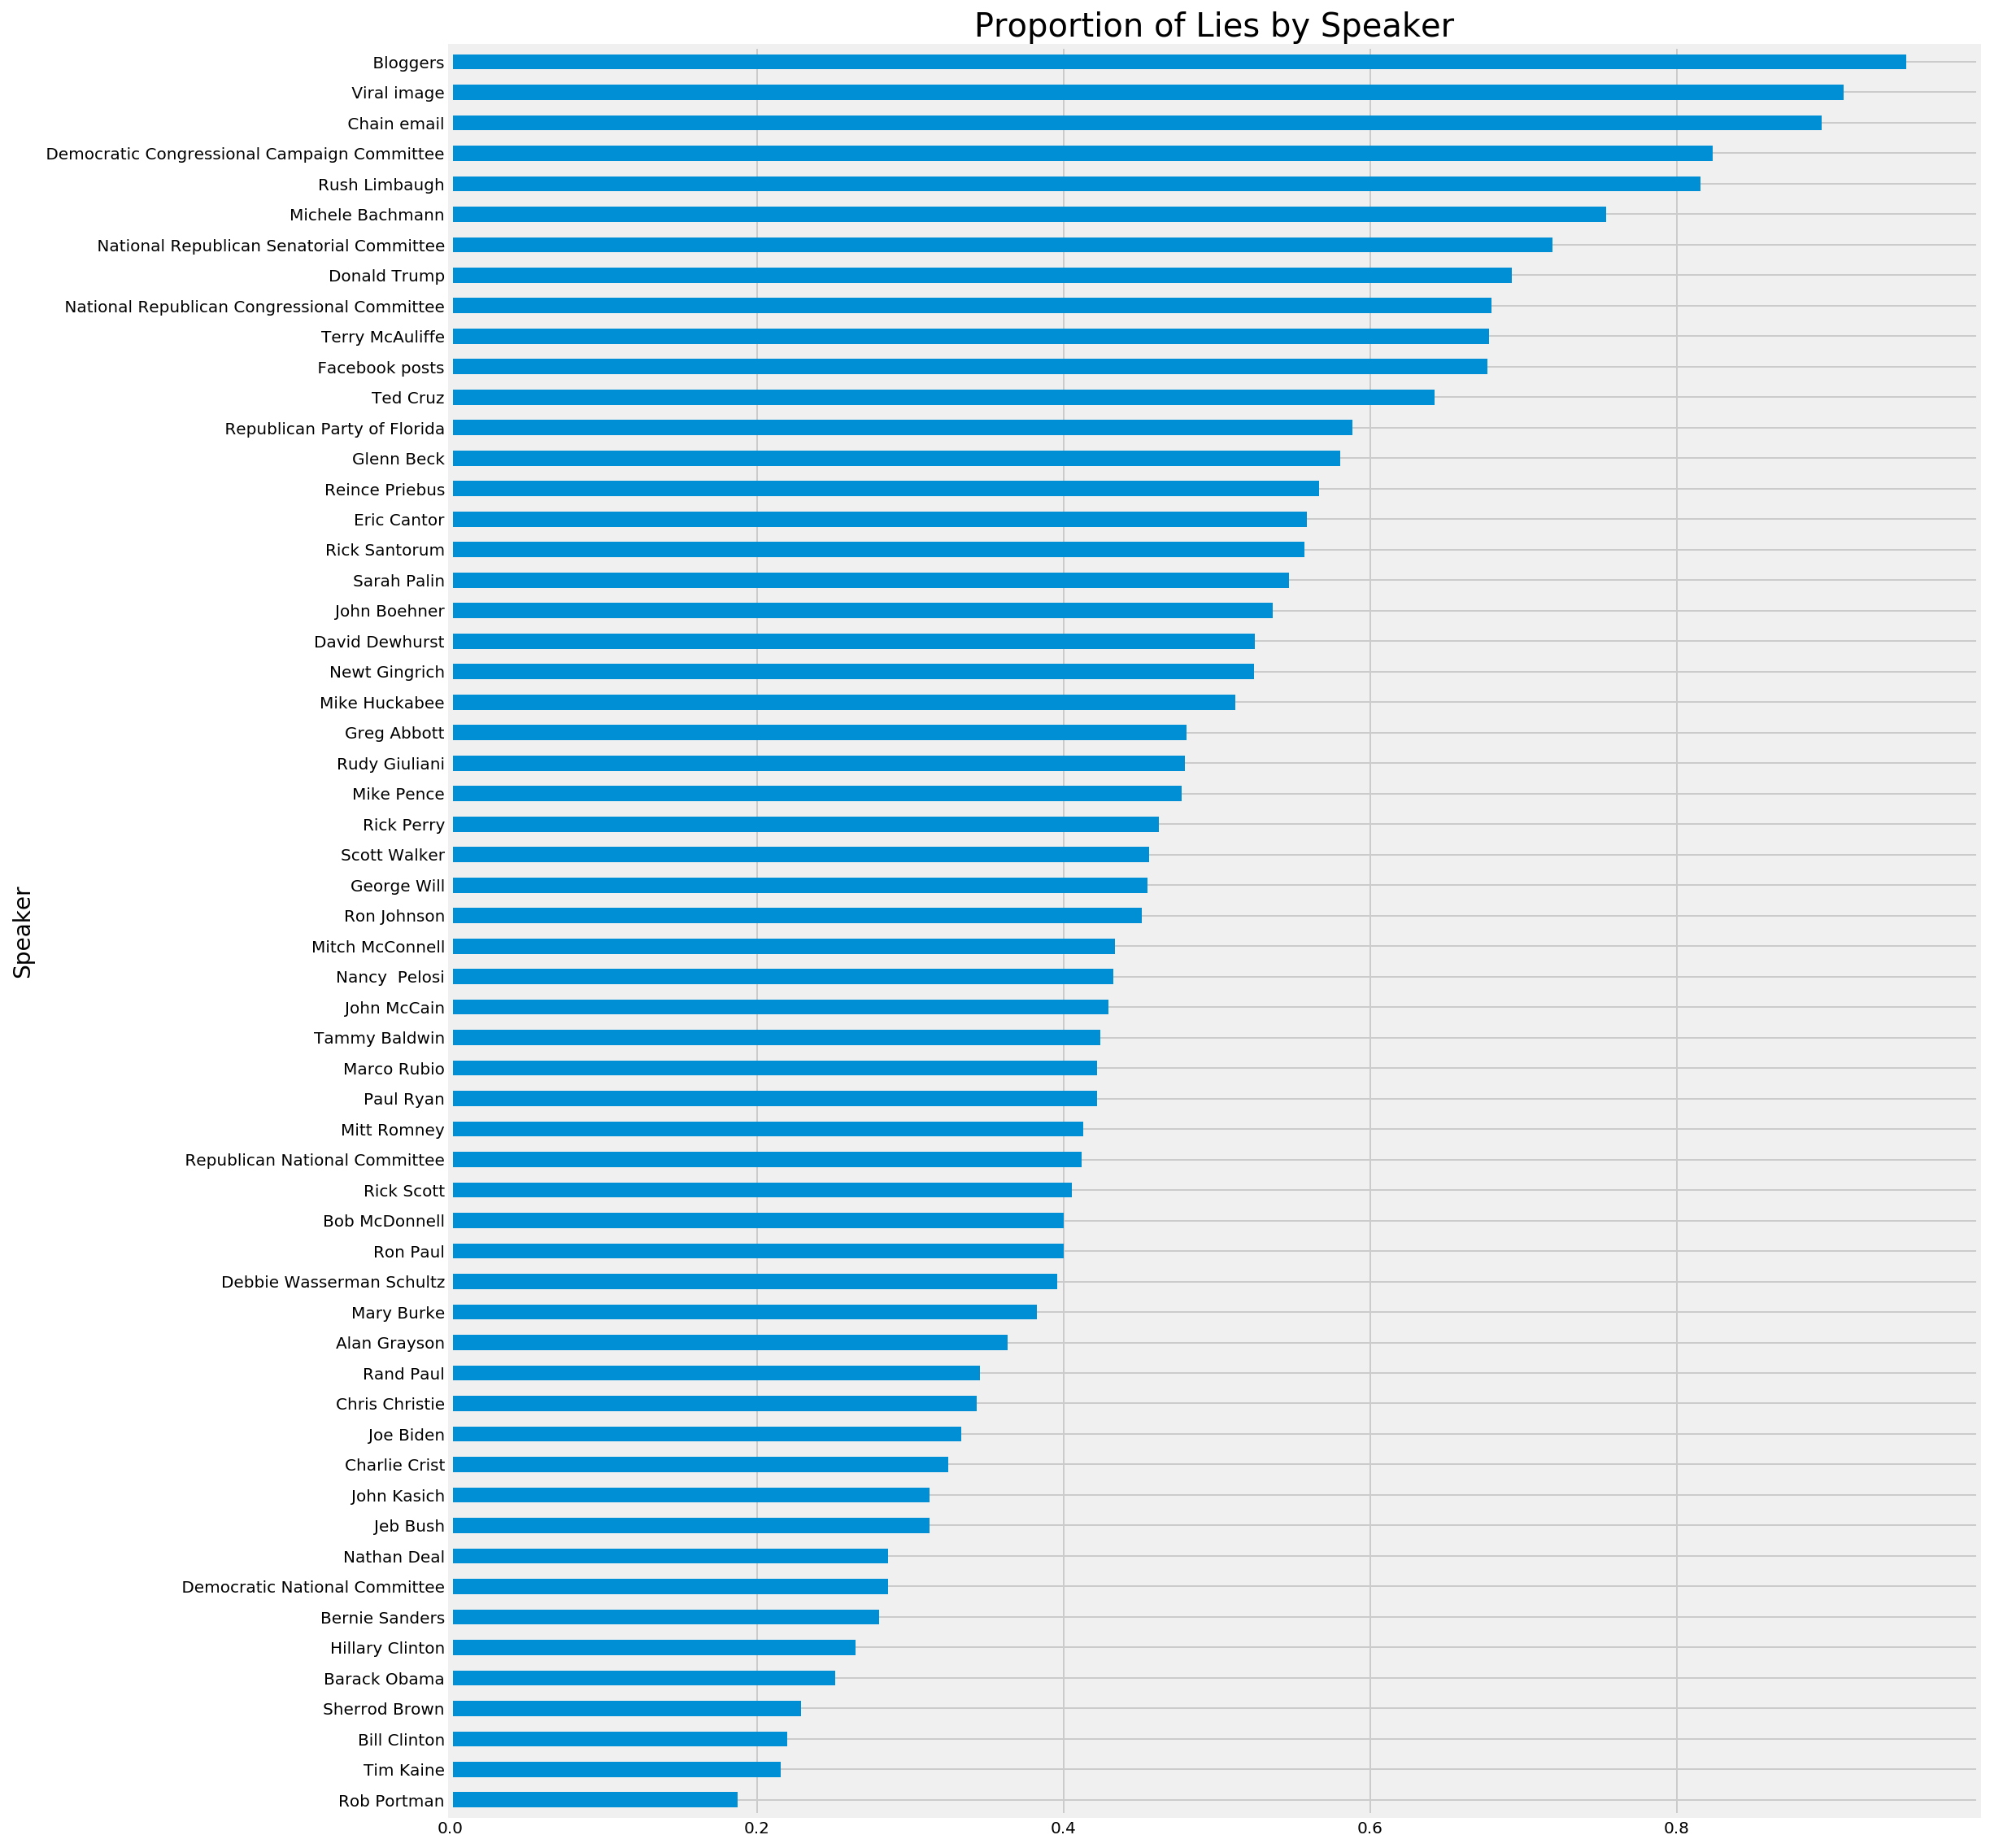

In [675]:
speaker_stats.sort_values('mean',inplace=True,ascending=True)
speaker_stats['mean'].plot.barh(figsize=(15,20))
plt.ylabel('Speaker', fontsize=14)
plt.title('Proportion of Lies by Speaker',fontsize=20)
plt.show()

In [676]:
#for number_ruling, from 0 to 5:
speaker_stats2 = speakerdf.groupby('speaker').agg({'number_ruling':['count','mean','median',mode,'std','min','max']})
speaker_stats2.columns = speaker_stats2.columns.get_level_values(1)
speaker_stats2

count      mean  median  mode  \
speaker                                                                       
 Bloggers                                       238  4.563025     5.0     5   
 Chain email                                    180  4.222222     5.0     5   
 Democratic Congressional Campaign Committee     34  3.558824     3.5     3   
 Democratic National Committee                   35  1.714286     2.0     2   
 Facebook posts                                  99  3.353535     4.0     5   
 National Republican Congressional Committee     53  2.924528     3.0     3   
 National Republican Senatorial Committee        32  3.187500     3.0     3   
 Republican National Committee                   34  2.323529     2.0     2   
 Republican Party of Florida                     34  2.705882     3.0     3   
 Viral image                                     33  3.969697     4.0     5   
Alan Grayson                                     33  1.848485     1.0     1   
Barack Obama                                    598  1.712375     2.0     1   
Bernie Sanders                                  118  1.779661     1.5     1   
Bill Clinton                                     41  1.707317     2.0     2   
Bob McDonnell                                    35  2.085714     2.0     0   
Charlie Crist                                    80  1.875000     2.0     2   
Chris Christie                                  102  2.068627     2.0     2   
David Dewhurst                                   40  2.650000     3.0     2   
Debbie Wasserman Schultz                         48  2.145833     2.0     1   
Donald Trump                                    481  3.120582     3.0     4   
Eric Cantor                                      34  2.441176     3.0     3   
George Will                                      33  1.969697     2.0     0   
Glenn Beck                                       31  2.870968     3.0     4   
Greg Abbott                                      50  2.300000     2.0     3   
Hillary Clinton                                 295  1.671186     1.0     1   
Jeb Bush                                         80  1.775000     2.0     1   
Joe Biden                                        75  2.013333     2.0     2   
John Boehner                                     69  2.362319     3.0     4   
John Kasich                                      64  1.750000     1.0     1   
John McCain                                     184  2.125000     2.0     4   
Marco Rubio                                     154  2.162338     2.0     1   
Mary Burke                                       34  2.352941     2.0     2   
Michele Bachmann                                 61  3.409836     4.0     4   
Mike Huckabee                                    41  2.365854     3.0     3   
Mike Pence                                       44  2.477273     2.0     2   
Mitch McConnell                                  30  2.100000     2.0     1   
Mitt Romney                                     206  2.300971     2.0     2   
Nancy  Pelosi                                    37  2.405405     2.0     2   
Nathan Deal                                      49  1.632653     2.0     0   
Newt Gingrich                                    82  2.695122     3.0     2   
Paul Ryan                                        83  2.192771     2.0     3   
Rand Paul                                        55  1.963636     2.0     2   
Reince Priebus                                   30  2.933333     3.5     4   
Rick Perry                                      171  2.409357     2.0     2   
Rick Santorum                                    61  2.688525     3.0     4   
Rick Scott                                      148  2.216216     2.0     2   
Rob Portman                                      48  1.395833     1.0     0   
Ron Johnson                                      51  2.176471     2.0     3   
Ron Paul                                         40  2.150000     2.0     4   
Rudy Giuliani    

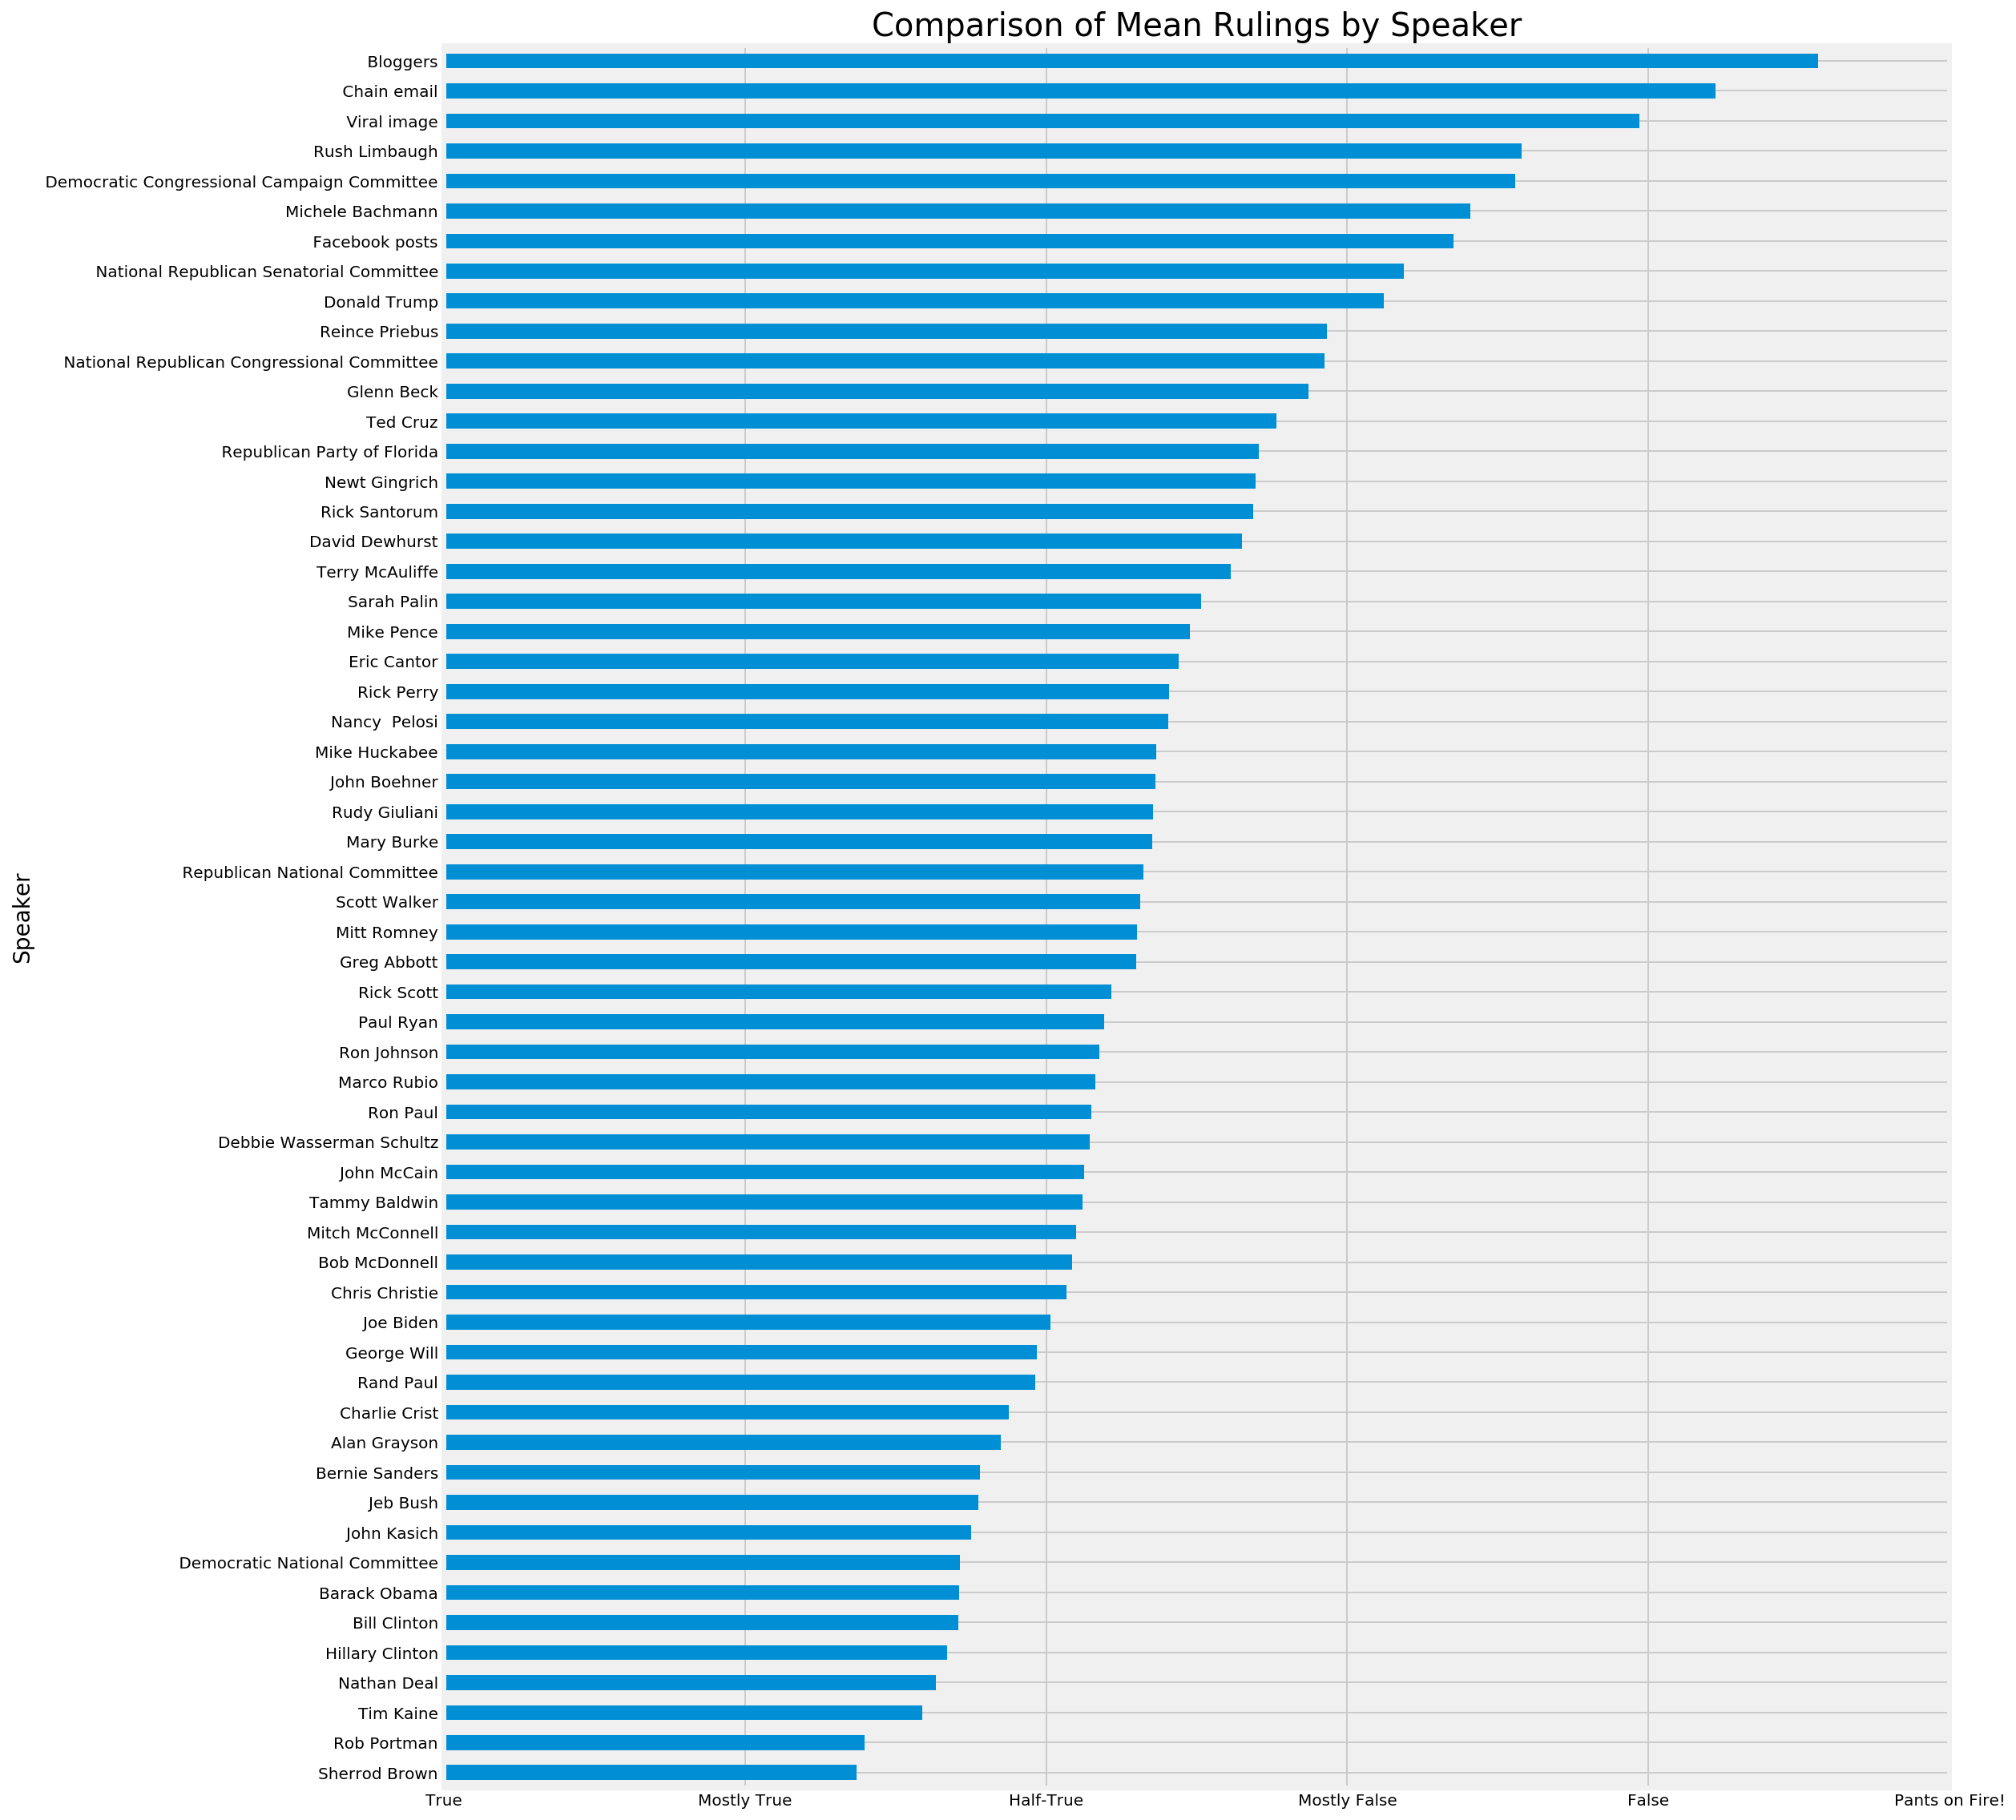

In [677]:
speaker_stats2.sort_values('mean',inplace=True,ascending=True)
speaker_stats2['mean'].plot.barh(figsize=(15,20))
plt.ylabel('Speaker', fontsize=14)
plt.title('Comparison of Mean Rulings by Speaker', fontsize=20)
plt.xticks([0,1,2,3,4,5],['True','Mostly True','Half-True','Mostly False','False','Pants on Fire!'])
plt.show()

Observations about speaker:

It looks like anonymous speakers like bloggers, chain e-mails, and viral images are much more likely to be lying than people who we can identify. 

There are huge discrepancies between speakers at the bottom of the graph above -- like Rob Portman (Republican Senator from OH), Sherrod Brown (Democratic Senator from OH), Tim Kaine (Democratic VP candidate and Democratic Senator from VA), and Nathan Deal (Republican Governor of GA) -- and speakers at the top of the graph above, like Rush Limbaugh (Republican radio host), Michelle Bachman (Representative from MN), and Donald Trump. This is one of the most dramatic differences that we've seen, which does make a lot of sense. 

I'm a little bit torn about whether or not I want to include this as a feature for my analysis.  In some ways, I would kind of like to be able to detect a lie without necessarily knowing the exact identity of the person speaking? In particular, with the 2018 elections coming up next year, there will be a whole new group of politicians potentially coming to national prominence, and I would like my model to work with new politicians or politicians that have only come up a few times in the past. At the very least, though, I can include bloggers, chain e-mails, viral images, and then everyone else as one category.

Investigating date:

A lot of thinkpieces have proposed that politics has become less fact-based in the last few years.  Does our data indicate that at all? 

In [678]:
df['month'] = df['date'].map(lambda x: x.month)
df['year'] = df['date'].map(lambda x: x.year)
df['quarter'] = df['date'].map(lambda x: x.quarter)

In [679]:
date_stats = df.groupby(['year','month']).agg({'lie':['count','mean','median',mode,'std']})
date_stats.columns = date_stats.columns.get_level_values(1)
#there are only two observations before 2007, so I'm getting rid of them
date_stats = date_stats.iloc[2:,:]
date_stats.reset_index(inplace=True)
date_stats

year  month  count      mean  median  mode       std
0    2007      3      1  0.000000     0.0     0       NaN
1    2007      4      3  0.000000     0.0     0  0.000000
2    2007      5     13  0.153846     0.0     0  0.375534
3    2007      6      9  0.333333     0.0     0  0.500000
4    2007      7      8  0.250000     0.0     0  0.462910
5    2007      8     18  0.166667     0.0     0  0.383482
6    2007      9     57  0.245614     0.0     0  0.434277
7    2007     10     55  0.363636     0.0     0  0.485479
8    2007     11     49  0.326531     0.0     0  0.473804
9    2007     12     36  0.361111     0.0     0  0.487136
10   2008      1     78  0.358974     0.0     0  0.482805
11   2008      2     48  0.395833     0.0     0  0.494204
12   2008      3     32  0.500000     0.5     1  0.508001
13   2008      4     52  0.365385     0.0     0  0.486236
14   2008      5     36  0.500000     0.5     1  0.507093
15   2008      6     43  0.348837     0.0     0  0.482243
16   2008      7     44  0.477273     0.0     0  0.505258
17   2008      8     76  0.368421     0.0     0  0.485582
18   2008      9     70  0.471429     0.0     0  0.502787
19   2008     10     74  0.459459     0.0     0  0.501756
20   2008     11      1  1.000000     1.0     1       NaN
21   2008     12      4  0.500000     0.5     1  0.577350
22   2009      1     21  0.476190     0.0     0  0.511766
23   2009      2     23  0.347826     0.0     0  0.486985
24   2009      3     32  0.406250     0.0     0  0.498991
25   2009      4     21  0.571429     1.0     1  0.507093
26   2009      5     31  0.354839     0.0     0  0.486373
27   2009      6     32  0.531250     1.0     1  0.507007
28   2009      7     40  0.525000     1.0     1  0.505736
29   2009      8     53  0.603774     1.0     1  0.493793
30   2009      9     55  0.490909     0.0     0  0.504525
31   2009     10     54  0.555556     1.0     1  0.501570
32   2009     11     56  0.535714     1.0     1  0.503236
33   2009     12     31  0.451613     0.0     0  0.505879
34   2010      1     77  0.415584     0.0     0  0.496054
35   2010      2     85  0.376471     0.0     0  0.487376
36   2010      3    111  0.432432     0.0     0  0.497660
37   2010      4    100  0.460000     0.0     0  0.500908
38   2010      5     85  0.329412     0.0     0  0.472789
39   2010      6    166  0.409639     0.0     0  0.493255
40   2010      7    165  0.430303     0.0     0  0.496626
41   2010      8    145  0.427586     0.0     0  0.496443
42   2010      9    186  0.548387     1.0     1  0.498996
43   2010     10    205  0.507317     1.0     1  0.501170
44   2010     11    146  0.390411     0.0     0  0.489522
45   2010     12    105  0.457143     0.0     0  0.500549
46   2011      1    153  0.450980     0.0     0  0.499225
47   2011      2    187  0.417112     0.0     0  0.494405
48   2011      3    161  0.459627     0.0     0  0.499922
49   2011      4    152  0.434211     0.0     0  0.497291
50   2011      5    173  0.439306     0.0     0  0.497743
51   2011      6    190  0.526316     1.0     1  0.500626
52   2011      7    151  0.417219     0.0     0  0.494741
53   2011      8    141  0.439716     0.0     0  0.498122
54   2011      9    162  0.395062     0.0     0  0.490380
55   2011     10    173  0.468208     0.0     0  0.500437
56   2011     11    150  0.406667     0.0     0  0.492857
57   2011     12    133  0.473684     0.0     0  0.501195
58   2012      1    205  0.404878     0.0     0  0.492070
59   2012      2    174  0.408046     0.0     0  0.492890
60   2012      3    151  0.437086     0.0     0  0.497677
61   2012      4    175  0.480000     0.0     0  0.501033
62   2012      5    152  0.539474     1.0     1  0.500087
63   2012      6    168  0.529762     1.0     1  0.500606
64   2012      7    173  0.514451     1.0     1  0.501242
65   2012      8    191  0.376963     0.0     0  0.485899
66   2012      9    196  0.479592     0.0     0  0.500863
67   2012     10    209  0.425837     0.0     0  0.495657
68 

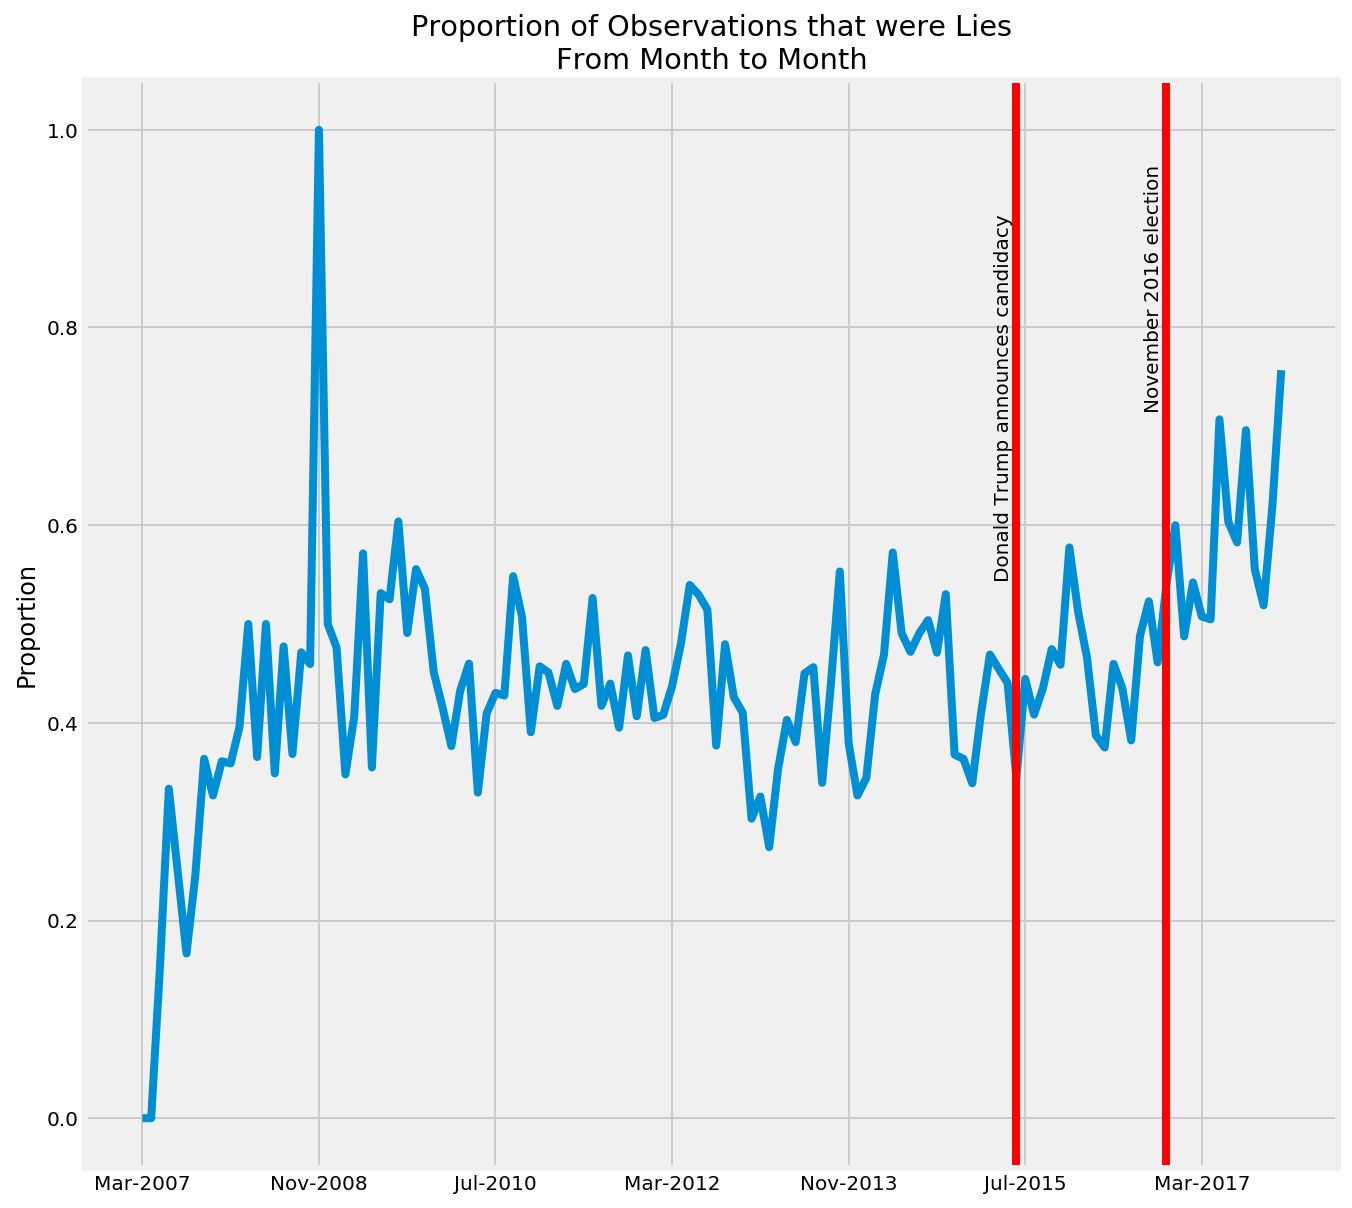

In [680]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.plot(date_stats['mean'])
plt.xticks([0,20,40,60,80,100,120],['Mar-2007','Nov-2008','Jul-2010','Mar-2012','Nov-2013','Jul-2015','Mar-2017'])
plt.axvline(99,c='r')
plt.text(96.5,0.9,'Donald Trump announces candidacy',rotation=90)
plt.axvline(116,c='r')
plt.text(113.5,0.95, 'November 2016 election', rotation=90)
plt.title('Proportion of Observations that were Lies\nFrom Month to Month')
plt.ylabel('Proportion')
plt.show()

The spike at November 2008 is due to just a single data point -- which is quite weird?  But starting from around 2010, all months have at least 50 observations (most of them have much more).  There does seem to be a slow upwards crawl starting from July 2015 through to the most recent data, indicating that there may have been an increase in falsehoods in the last two and a half years. (Donald Trump announced his candidacy for president in June of 2015, and that was probably the definitive start of the primary campaigns, so I thought it was useful to show that date on the graph, as well as the November 2016 election, just to provide some context.)

In [681]:
date_stats = df.groupby(['year']).agg({'lie':['count','mean','median',mode,'std']})
date_stats.columns = date_stats.columns.get_level_values(1)
#there are only two observations before 2007, so I'm getting rid of them
date_stats = date_stats.iloc[2:,:]
date_stats

count      mean  median  mode       std
year                                         
2007    249  0.293173       0     0  0.456134
2008    558  0.419355       0     0  0.493896
2009    449  0.501114       1     1  0.500556
2010   1576  0.442893       0     0  0.496886
2011   1926  0.444964       0     0  0.497091
2012   1938  0.449432       0     0  0.497565
2013   1415  0.392226       0     0  0.488419
2014   1546  0.466365       0     0  0.499029
2015   1283  0.431800       0     0  0.495520
2016   1745  0.457307       0     0  0.498317
2017   1218  0.577176       1     1  0.494211

Looking at the yearly stats above, it does look like 2017 was characterized by more lying than previous years, with a fairly significant jump from 46% of statements characterized as lies to 58%.  That's the biggest jump since the very first year that Politifact was operating (which might well have had more to do with growing pains for Politifact than an enormous increase in falsehoods between 2007 and 2008).

#### Investigating the language of the statement


In [682]:
truths = df.loc[df['lie']==0]
lies = df.loc[df['lie']==1]

In [683]:
from sklearn.feature_extraction.text import CountVectorizer
truthcvec = CountVectorizer(stop_words='english',ngram_range=(1,2))
truthcvec.fit(truths['statement'])
truthtext = truthcvec.transform(truths['statement'])
truthtext = pd.DataFrame(truthtext.todense(),columns=truthcvec.get_feature_names())
truthtext.sum().sort_values(ascending=False)[:20]

says         1610
percent      1141
state         742
000           640
year          550
tax           544
years         511
obama         502
million       486
people        481
div           460
states        420
new           413
health        401
jobs          391
president     390
style         359
texas         334
billion       316
font          314
dtype: int64

In [684]:
liecvec = CountVectorizer(stop_words='english',ngram_range=(1,2))
liecvec.fit(lies['statement'])
lietext = liecvec.transform(lies['statement'])
lietext = pd.DataFrame(lietext.todense(),columns=liecvec.get_feature_names())
lietext.sum().sort_values(ascending=False)[:20]

says            1649
obama            683
percent          494
state            481
president        478
health           437
div              412
tax              410
care             398
people           367
000              359
health care      319
years            316
new              313
year             311
barack           283
barack obama     277
said             264
million          263
font             254
dtype: int64

Well, clearly, I did not get rid of all of my 'div's!  I want to investigate what's going on with those and also all those 000 (I think those are probably numbers? Like 13,000? But I'm not sure. Let's see!)

In [685]:
#I just want to get a look at where 'div' is turning up
for i in range(2000):
    try:
        stmnt = df.loc[i,'statement']
        if 'div' in stmnt: print stmnt
    except: continue

"Bill Clinton's peace dividend . . . cut the military 25 and 30 percent."
Hillary Clinton and Barack Obama want to raise taxes on dividends, a move that would crash the stock market. 
Obama "voted against critical resources: no to individual body armor, no to helicopters, no to ammunition, no to aircraft."
"He voted twice for a budget resolution that increases the taxes on individuals making $42,000 a year."
"Nothing in any of the Democrat bills would require individuals to verify their citizenship or identity prior to receiving taxpayer-subsidized benefits."
The Democrats' health care bill "gives a new Health Choices Commissioner the right to look at an individual's tax return to determine what medical benefits or subsidies that person qualifies for."
Health care reform "establishes a new board of federal bureaucrats (the 'Health Benefits Advisory Committee') to dictate the health plans that all individuals must purchase."
	Uses headlines to portray Gov. Rick Perry as beholden to spec

In [686]:
import regex as re

def cleandivs(x):
    cleaned = re.sub('<.+?>','',x)
    return cleaned

In [687]:
df['statement'] = df['statement'].map(cleandivs)

for i in range(2000):
    try:
        stmnt = df.loc[i,'statement']
        if 'div' in stmnt: print stmnt
    except: continue

"Bill Clinton's peace dividend . . . cut the military 25 and 30 percent."
Hillary Clinton and Barack Obama want to raise taxes on dividends, a move that would crash the stock market. 
Obama "voted against critical resources: no to individual body armor, no to helicopters, no to ammunition, no to aircraft."
"He voted twice for a budget resolution that increases the taxes on individuals making $42,000 a year."
"Nothing in any of the Democrat bills would require individuals to verify their citizenship or identity prior to receiving taxpayer-subsidized benefits."
The Democrats' health care bill "gives a new Health Choices Commissioner the right to look at an individual's tax return to determine what medical benefits or subsidies that person qualifies for."
Health care reform "establishes a new board of federal bureaucrats (the 'Health Benefits Advisory Committee') to dictate the health plans that all individuals must purchase."
The CBO found that the House Republican health care plan would

In [688]:
#that's looking a lot better!
#now, I want to see what the deal is with the 000s
for i in range(1000):
    try: 
        stmnt = df.loc[i,'statement']
        if '000' in stmnt: print stmnt
    except: continue

"I used tax cuts to help create over 80,000 jobs in New Mexico."
"In 1972, we had a 179,000 human beings in jail in this country. Today, it's 2.3-million, and 70 percent of them are black, African-American."
"Let's pay attention to kids who are not going to college, which ends up being about 60 percent of the kids... and get them trained for the jobs that are there. Because, you know, there are auto mechanic jobs paying $50,000, $60,000 that they can't get filled. There are airline mechanic jobs paying a lot of money that can't get filled." Remarks at AFSCME forum 6/19/2007
"You know we can't just pull out now... The truth of the matter is: If we started today, it would take one year, one year to get 160,000 troops physically out of Iraq, logistically."
 "Bill Richardson passed the first law in the nation giving National Guard soldiers $400,000 in life insurance."
"We've lost over 5,000 Americans over there in Afghanistan, in Iraq, and plus the civilians killed."
"Each year, 18,000 peo

In [689]:
def numbersnocommas(x):
    bignumbers = re.findall(',\d{3}',x)  #find a comma followed by three digits
    if len(bignumbers)>0:
        for number in bignumbers:
            nocomma = number.replace(',','')
            cleaned = x.replace(number,nocomma)
    else: cleaned = x
    return cleaned

df['statement'] = df['statement'].map(numbersnocommas)

In [690]:
for i in range(1000):
    try: 
        stmnt = df.loc[i,'statement']
        if '000' in stmnt: print stmnt
    except: continue

"I used tax cuts to help create over 80000 jobs in New Mexico."
"In 1972, we had a 179000 human beings in jail in this country. Today, it's 2.3-million, and 70 percent of them are black, African-American."
"Let's pay attention to kids who are not going to college, which ends up being about 60 percent of the kids... and get them trained for the jobs that are there. Because, you know, there are auto mechanic jobs paying $50000, $60000 that they can't get filled. There are airline mechanic jobs paying a lot of money that can't get filled." Remarks at AFSCME forum 6/19/2007
"You know we can't just pull out now... The truth of the matter is: If we started today, it would take one year, one year to get 160000 troops physically out of Iraq, logistically."
 "Bill Richardson passed the first law in the nation giving National Guard soldiers $400000 in life insurance."
"We've lost over 5000 Americans over there in Afghanistan, in Iraq, and plus the civilians killed."
"Each year, 18000 people die 

In [691]:
#just noticed an emdash in there that I want to clean up:

df['statement'] = df['statement'].map(lambda x: x.replace('&mdash;','-'))

In [692]:
for i in range(16000):
    try:
        stmnt = df.loc[i,'statement']
        if '&' in stmnt: print stmnt
    except:continue

"Tommy Thompson created the first school choice program in the nation, giving thousands of Milwaukee students the choice of where they go to school &ndash; no matter where they live or how much money their parents make."
"There was a report that came out from the FBI &ndash; a warning, not a report ... saying that, in fact, al-Qaida was planning to attack malls during the Christmas holidays."
"Clinton aides admit it (a gas tax holiday) won't do much for you &ndash; but would help her politically."
"I've supported every investigation (into Hurricane Katrina) and ways of finding out how &ndash; what caused the tragedy. I've met with people on the ground. I've met with the governor."
"The Iranians continue &ndash; in the view of every objective observer &ndash; continue to pursue the acquisition of nuclear weapons."
Health care reform legislation is &ldquo;likely to mandate free 'sex change' surgeries.&rdquo;
"It's a plan that incorporates ideas from many of the people in this room tonigh

Maryland is "creating jobs at 2 &frac12; times the rate that Virginia is."
"Shelby County donated &ndash; I'm sorry, gave &ndash; 44 schools to the city of Memphis."
The U.S. has a "record number of oil rigs operating right now &ndash; more working oil and gas rigs than the rest of the world combined."
"Every time the weight of that vehicle is reduced by a hundred pounds, your chances of dying are going to go up by about 5 percent. Peel three hundred pounds off &ndash; you're 15 percent more likely to die in that car."
"Mitt Romney's pledged to protect (oil companies') record profits &ndash; and their billions in special tax breaks, too."		
"In 2011, NJ economy ranked 47th--at the bottom with Alabama, Mississippi &amp; Wyoming. Under Christie, NJ is falling behind."
"When I was governor, not only did test scores improve &ndash; we also narrowed the achievement gap."
Says Gov. Jeb Bush vetoed the "Qui&ntilde;ones Plan" because it was "taxation without representation on a large scale."
"

In [693]:
df['statement'] = df['statement'].map(lambda x: x.replace('&ldquo;','"'))
df['statement'] = df['statement'].map(lambda x: x.replace('&rdquo;','"'))
df['statement'] = df['statement'].map(lambda x: x.replace('&ndash;',"-"))
df['statement'] = df['statement'].map(lambda x: x.replace('&amp;',''))
df['statement'] = df['statement'].map(lambda x: x.replace('#&lrm;',''))
df['statement'] = df['statement'].map(lambda x: x.replace('&aacute;','a'))
df['statement'] = df['statement'].map(lambda x: x.replace('&oacute;','o'))
df['statement'] = df['statement'].map(lambda x: x.replace('&uacute;','u'))
df['statement'] = df['statement'].map(lambda x: x.replace('&eacute;','e'))
df['statement'] = df['statement'].map(lambda x: x.replace('&ntilde;','n'))

In [694]:
#running cvec again now that I've cleaned it up a bit
truths = df.loc[df['lie']==0]
lies = df.loc[df['lie']==1]

truthcvec = CountVectorizer(stop_words='english',ngram_range=(1,2))
truthcvec.fit(truths['statement'])
truthtext = truthcvec.transform(truths['statement'])
truthtext = pd.DataFrame(truthtext.todense(),columns=truthcvec.get_feature_names())
top20truth = truthtext.sum().sort_values(ascending=False)[:20]
top20truth

says         1610
percent      1141
state         742
year          550
tax           544
years         511
obama         501
million       486
people        481
states        420
health        401
jobs          391
president     390
new           374
texas         334
billion       316
country       306
care          306
federal       288
taxes         287
dtype: int64

In [695]:
liecvec = CountVectorizer(stop_words='english',ngram_range=(1,2))
liecvec.fit(lies['statement'])
lietext = liecvec.transform(lies['statement'])
lietext = pd.DataFrame(lietext.todense(),columns=liecvec.get_feature_names())
top20lie = lietext.sum().sort_values(ascending=False)[:20]
top20lie

says            1646
obama            683
percent          494
state            481
president        478
health           437
tax              410
care             398
people           367
health care      319
years            316
year             311
new              287
barack           283
barack obama     278
said             264
million          263
jobs             250
government       247
voted            234
dtype: int64

Preliminary observations:

There's nothing too interesting here - most of the top 20 words feature in both the lies and the truths.  However, to speculate: 
- 'obama' ranks higher on the 'lie' list than it does on the 'truth' list, suggesting that claims or attacks about Barack Obama may be more likely to be lies? This is also supported by the fact that 'barack' and 'barack obama' are also on the top 20 words for lies, whereas those don't turn up on the 'truth' list.  Given how much of a polarizing figure Obama was (and how many attacks against him were demonstrably false, like his not being American, or not being Christian), this isn't surprising.
- Similarly, 'health' and 'health care' are more prominent in the lie list -- again, given how polarizing the health care debate has become, this makes sense.
- 'said' turning up in the lie list but not the truth list might suggest that people making claims about what other people have said are more likely to be lying
- 'voted' turning up in the lie list but not the truth list might reflect the controversy over (debunked) claims of voter fraud in the last election

In [696]:
#what about the top 20 word features for 0s and 5s (ie True and Pants on Fire!)?

def topwordfeatures(numberlist,ngram,topn):
    
    restricteddf = df.loc[df['number_ruling'].isin(numberlist)]
    
    cvec = CountVectorizer(stop_words='english',ngram_range=ngram)
    cvec.fit(restricteddf['statement'])
    text = cvec.transform(restricteddf['statement'])
    text = pd.DataFrame(text.todense(),columns=cvec.get_feature_names())
    topnfeatures = text.sum().sort_values(ascending=False)[:topn]
    
    return topnfeatures

top20zeros = topwordfeatures([0],(1,2),20)
top20fives = topwordfeatures([5],(1,2),20)
top20zerosones = topwordfeatures([0,1],(1,2),20)
top20foursfives = topwordfeatures([4,5],(1,2),20)
top20zeros2 = topwordfeatures([0],(2,2),20)
top20fives2 = topwordfeatures([5],(2,2),20)
top20zeros3 = topwordfeatures([0],(3,3),20)
top20fives3 = topwordfeatures([5],(3,3),20)

top20df = pd.DataFrame(columns=['zeros','fives','zeros_ones','fours_fives','zeros_ngram2','fives_ngram2','zeros_ngram3','fives_ngram3','lies','truths'])
top20lists = [top20zeros,top20fives,top20zerosones,top20foursfives,top20zeros2,top20fives2,top20zeros3,top20fives3,top20lie,top20truth]
for top20,col in zip(top20lists,top20df.columns):
    top20 = pd.DataFrame(top20)
    top20.reset_index(inplace=True)
    top20df[col] = top20['index']

In [697]:
top20df

zeros         fives zeros_ones   fours_fives        zeros_ngram2  \
0        says          says       says          says         health care   
1     percent         obama    percent         obama       united states   
2       state     president      state     president        barack obama   
3       years        barack       year         state        donald trump   
4        year  barack obama        tax        health        rhode island   
5         tax        health      years       percent    health insurance   
6       obama          said     people           tax          new jersey   
7      states          care    million          care         mitt romney   
8      health         trump      obama        people            new york   
9     million           tax     states   health care         john mccain   
10        new         state     health        barack     president obama   
11     people        people        new  barack obama           years ago   
12  president           new  president           new     social security   
13      texas   health care      texas         years  federal government   
14       jobs       percent       jobs          said       national debt   
15    federal         years    country          year       supreme court   
16    country       clinton    federal    government     hillary clinton   
17       care    government       care       million      private sector   
18   american       million     budget          jobs    african american   
19     budget           law      taxes     wisconsin          40 percent   

          fives_ngram2            zeros_ngram3                fives_ngram3  \
0         barack obama       says donald trump      president barack obama   
1          health care  president barack obama           says barack obama   
2      hillary clinton        says mitt romney             health care law   
3     president barack            world war ii            gov scott walker   
4         donald trump          new york state       says president barack   
5        united states        health care plan        says hillary clinton   
6       says president     private sector jobs      president donald trump   
7      president obama       says barack obama               says ted cruz   
8         scott walker          rainy day fund         affordable care act   
9          says barack         health care law             new health care   
10         white house     romney flip flopped           says donald trump   
11            care law           bush tax cuts           obama health care   
12           gov scott          trump tax plan        tax increase history   
13        says hillary   percent americans pay         wisconsin gov scott   
14     social security       says scott walker            says mitt romney   
15  illegal immigrants        pay income taxes  government takeover health   
16          rick perry   flip flopped abortion          health care reform   
17    president donald        john mccain said       michele bachmann said   
18        tax increase        mitt romney flip           sen sherrod brown   
19            says rep    says hillary clinton        largest tax increase   

            lies     truths  
0           says       says  
1          obama    percent  
2        percent      state  
3          state       year  
4      president        tax  
5         health      years  
6            tax      obama  
7           care    million  
8         people     people  
9    health care     states  
10         years     health  
11          year       jobs  
12           new  president  
13        barack        new  
14  barack obama      texas  
15          said    billion  
16       million    country  
17          jobs       care  
18    government    federal  
19         voted      taxes

In [698]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

In [699]:
text = ''
for stmnt in lies['statement']:
    text = text + stmnt

cross_mask = np.array(Image.open(('cross.png')))

stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white", max_words=2000, mask=cross_mask,
               colormap='YlOrRd',stopwords=stopwords)
wc.generate(text)
wc.to_file('liesWC.png')

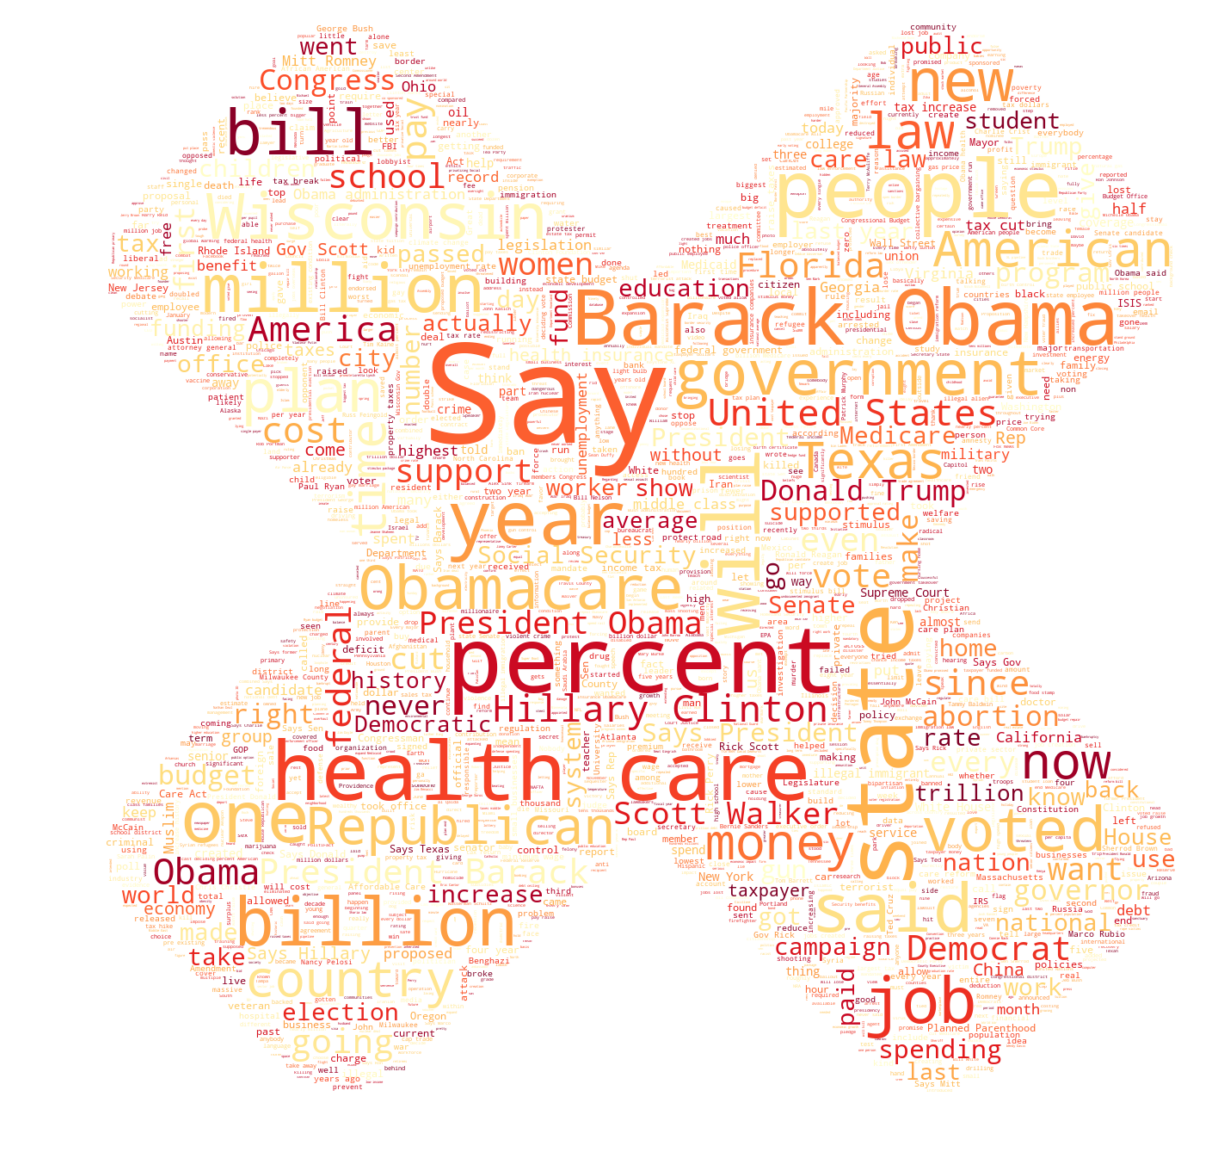

In [700]:
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

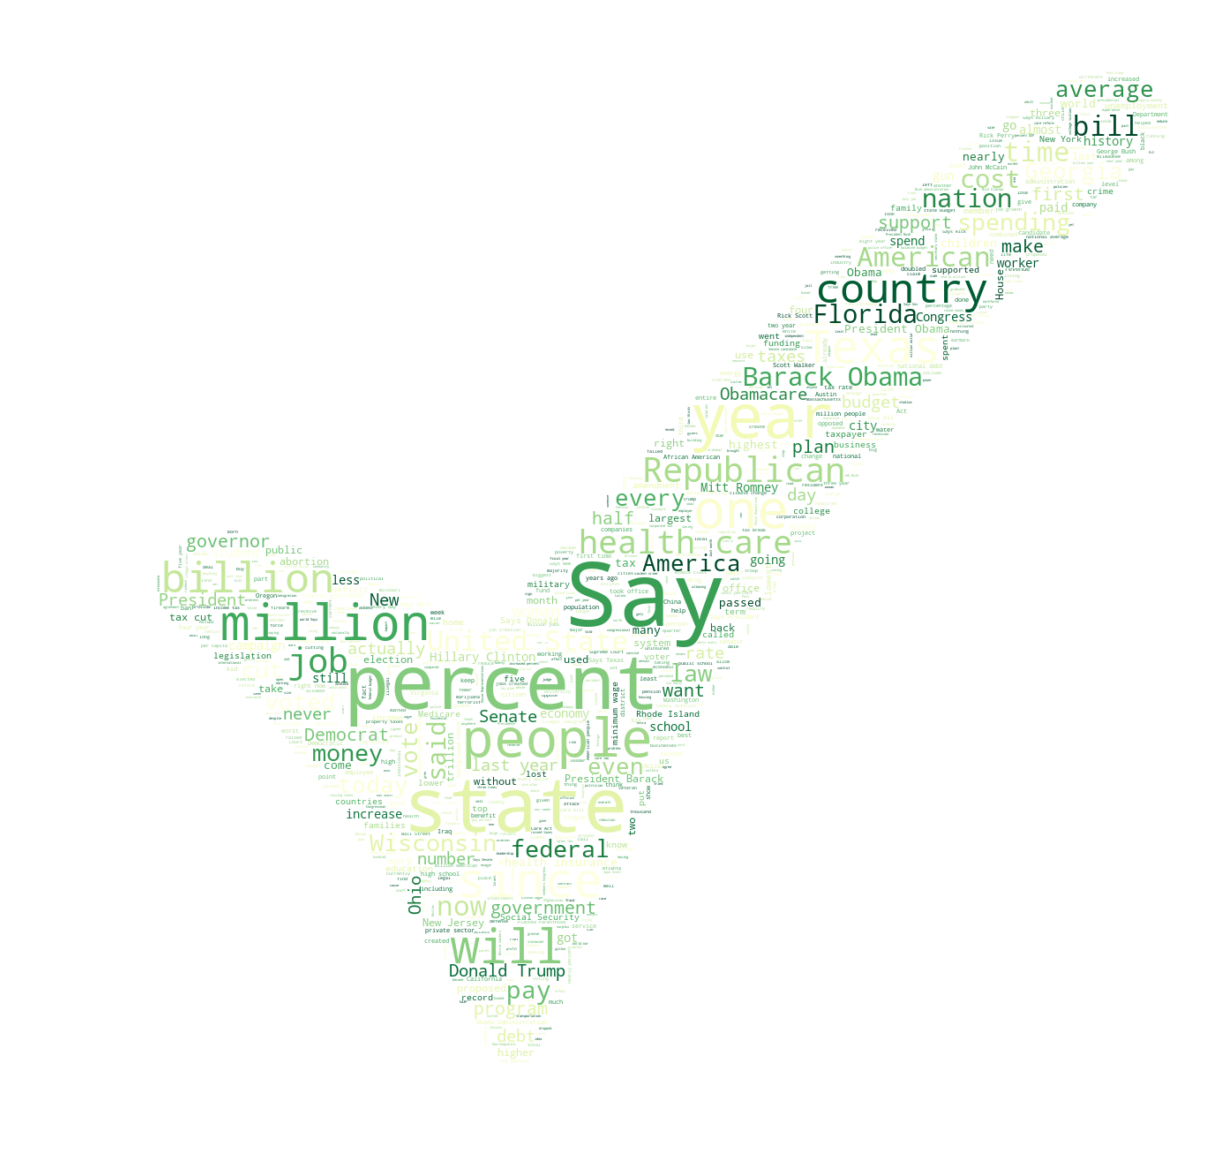

In [701]:
tick_mask = np.array(Image.open(('tick.png')))

wc2 = WordCloud(background_color='white',max_words=2000,mask=tick_mask,colormap='YlGn',stopwords=stopwords).generate(' '.join(truths['statement']))

wc2.to_file('truthsWC.png')

plt.figure(figsize=[10,10])
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.show()

In [702]:
#hmmm.... why is 'says' so prominent?
for i in range(1000):
    try:
        stmnt = df.loc[i,'statement']
        if 'says' in stmnt: print stmnt
    except: continue

Sen. Clinton said "the surge of troops in Iraq was 'working.' Now.... Sen. Clinton says the surge 'has failed' and that we should 'begin the immediate withdrawal of U.S. troops.'"
"I would love to see us have in this country what I helped lead in Arkansas...Amendment 65 (which) says that we believe life begins at conception, and that we ought to do everything in the world possible to protect it until its natural conclusion."
"What happens is people like Warren Buffett - and he says this himself...pay 15 percent on the millions of dollars that they earn from wealth income... while their secretary is paying a higher rate on her work income. It's not right."
"First, he said he would leave residual forces in Iraq, and now he says he wouldn't."
Obama spokesman Bill Burton says Clinton gave Bush "a blank check on a critical foreign policy issue."
Edwards says if Congress won't pass universal health care, he'll tell Congress: "I'm going to use my power as president to take your health care aw

I have a bit of a problem with the way that politifact deals with the statements, which is revealed by the prominence of the word 'says' for both the true statements and the lies.  Essentially, there are a few different formats of statements that Politifact seems to use:

- The most common format is just a direct quote from the speaker, ie: "Kermit the Frog says that apples are purple" --Miss Piggy ...so, is Miss Piggy lying about him saying that?

- Sometimes, part of it (or, more rarely, all of it) is paraphrased, but it still reads essentially as a direct quote, ie: Kermit the Frog "says that apples are purple" --Miss Piggy ...again, is Miss Piggy lying about him saying that?
 
- Sometimes, though, they've put the speaker at the front of the quote for some frustrating reason, ie: Kermit the Frog says that "apples are purple" --Kermit the Frog ...so, this time, even though the words are exactly the same, this is different! This time we're asking, is Kermit the Frog lying about apples being purple? 

To use examples from above:

- Obama says Clinton in 2002 suggested there was a connection between al-Qaida and the Iraqi government.  (That's Politifact paraphrasing Obama, so the speaker is Obama, and 'says' is not really part of the statement.  So, Politifact's not assessing whether it's true that Obama said that about Clinton, Politifact's assessing whether Obama's claim is correct.)

- Sen. Clinton said "the surge of troops in Iraq was 'working.' Now.... Sen. Clinton says the surge 'has failed' and that we should 'begin the immediate withdrawal of U.S. troops.'" (That's actually a statement from John McCain, not Clinton, but Politifact just paraphrased slightly at the beginning for clarity. So, this time, Politifact is assessing whether it's true that Clinton ever said that about the surge.)

Basically, this poses a problem for our natural language analysis, because some of the statements are not really direct quotes, or at least not all of it is.  At the same time, not all of the direct quotes (or close enough to direct quotes) are actually enclosed in quotation marks.  (For example, in the statement 'Fully inflating tires is "a step that every expert says would absolutely reduce our oil consumption by 3 to 4 percent."', the first part isn't in quotes, but it's essentially the same as what Obama said, just slightly edited and condensed to make a single sentence. Or, with 'Obama "says he'll raise taxes on electricity."', the fact that Obama was the target of that attack is important, and absolutely was in the actual statement, just the actual quote was longer: "With gas prices soaring, Barack Obama says no to offshore drilling. And, says he'll raise taxes on electricity.")

I don't know whether it might be better though, to be on the safe side, to eliminate anything that isn't in between quotation marks.  

In [703]:
#I just want to have a look at what the first 100 or so statements look like
for i in range(100):
    try:
        stmnt = df.loc[i,'statement']
        print stmnt
    except: continue

"The attorney general requires that rape victims pay for the rape kit."
President Clinton "reduced the scale of our military dramatically."
"New Mexico was 46th in teacher pay (when he was elected), now we're 29th."
"I used tax cuts to help create over 80000 jobs in New Mexico."
New Mexico moved "up to" sixth in the nation in job growth.
"Barack Obama and Hillary Clinton have changed their positions (on the Iraq war withdrawal) to follow Chris Dodd."
"Corporate profits are up, CEO pay is up, but average wages of Americans are flat."
"For every single scientist that tells you (global warming is) happening and that it's our fault...I can stack up another group of reports that say just the opposite."
"We now have the greatest income inequality since the Great Depression."
"I'll tell you what I can tell this country: If they want a president who doesn't believe in God, there's probably plenty of choices."
"(McCain) was opposed to ethanol. Now he's for it."
"Senator McCain voted against the

In [704]:
#I spotted something above that I don't like!  I'm going to have a look and fix it 
for i in range(16000):
    try:
        stmnt = df.loc[i,'statement']
        if '\\' in stmnt: print stmnt
    except: continue

 \u201CThirty-four percent of Hispanics don\u2019t have any health care at all, don\u2019t have any health insurance.\u201D


In [705]:
def fixingbackslash201(x):
    x = x.replace('\u201C','"')
    x = x.replace('\u201D','"')
    x = x.replace('\u2019',"'")
    return x

df['statement'] = df['statement'].map(fixingbackslash201)

In [706]:
#now, I'm going to have a look at statements that don't start with a quotation mark
for i in range(100):
    try:
        stmnt = df.loc[i,'statement']
        if stmnt[0]!='"': print stmnt
    except: continue

President Clinton "reduced the scale of our military dramatically."
New Mexico moved "up to" sixth in the nation in job growth.
An estimated 56 million Americans don't have bank accounts.
Barack Obama supported keeping troops in Iraq, but now he wants a "precipitous withdrawal" regardless of "conditions on the ground" or "consequences of a defeat for the United States," an RNC radio ad.
Hillary Clinton was against setting a deadline for withdrawal, but now she wants a "precipitous withdrawal" regardless of "conditions on the ground" or "consequences of a defeat for the United States," an RNC radio ad.
Sen. Clinton said "the surge of troops in Iraq was 'working.' Now.... Sen. Clinton says the surge 'has failed' and that we should 'begin the immediate withdrawal of U.S. troops.'"
We live in "a time of historically low violent crime rates and historically high gun ownership rates nationally." 
English "is our national language...if it becomes official, that means in a place like New York 

In [707]:
#I'm going to try to fix some of the problems outlined above by seeing if the speaker
#is mentioned before 'says' when 'says' is before a quotation mark,
#then I'm going to just keep everything after 'says' in that case

#before I write my function, I'm going to play around below to figure out how to do it 

for i in range(5000):
    try:
        speaker = df.loc[i,'speaker']
        stmnt = df.loc[i,'statement']
        stmntpieces = stmnt.split('"')
        firstpiece = stmntpieces[0]
        if 'say' in firstpiece: 
            print speaker
            print stmnt
            speakersurname = speaker.split(' ')[-1]
            beforesay = firstpiece.split('say')[0]
            if speakersurname in beforesay:
                print 'reject'
                print stmnt.split('says',1)[-1],'\n'
            else:
                print 'keep\n'
    except: continue

Barack Obama
Obama spokesman Bill Burton says Clinton gave Bush "a blank check on a critical foreign policy issue."
reject
 Clinton gave Bush "a blank check on a critical foreign policy issue." 

John Edwards
Edwards says if Congress won't pass universal health care, he'll tell Congress: "I'm going to use my power as president to take your health care away from you."
reject
 if Congress won't pass universal health care, he'll tell Congress: "I'm going to use my power as president to take your health care away from you." 

Barack Obama
Obama says his health care plan is "universal."
reject
 his health care plan is "universal." 

 Chain email
An anonymous e-mail says that Hillary Clinton advocates communism. 
keep

Mitt Romney
Former business partner Robert Gay says: "The man who helped save my daughter was Mitt Romney."
keep

 Democratic National Committee
The DNC says McCain flip-flopped on whether the Iraq War would be easy.
keep

Barack Obama
Obama says Clinton in 2002 suggested ther

In [708]:
def fewersays(row):
        speaker = row['speaker']
        stmnt = row['statement']
        stmntpieces = stmnt.split('"')
        firstpiece = stmntpieces[0]
        if 'says' in firstpiece:
            speakersurname = speaker.split(' ')[-1]
            beforesay = firstpiece.split('says')[0]
            if speakersurname in beforesay:
                newstmnt = stmnt.split('says',1)[-1]
            else:
                newstmnt = stmnt
        else:
            newstmnt = stmnt
        return newstmnt

In [709]:
df['new_statement'] = df.apply(fewersays, axis=1)
df.head(2)

edition                                          statement statement_type  \
0     Texas  "The attorney general requires that rape victi...          Claim   
1  National  President Clinton "reduced the scale of our mi...          Claim   

                      statement_context                speaker speaker_party  \
0                   in a Web site video  Barbara Ann Radnofsky      Democrat   
1  a Republican debate in Orlando, Fla.            Mitt Romney    Republican   

       speaker_job   subject          ruling       date edition_type  \
0              NaN     Crime  Pants on Fire! 2009-10-22        State   
1  Former governor  Military       Half-True 2007-10-21     National   

  binary_ruling       simple_context simple_job  number_ruling  lie  month  \
0         False  in a Web site video        NaN              5    1     10   
1          True             a debate   Governor              2    0     10   

   year  quarter                                      new_statement  
0  2009        4  "The attorney general requires that rape victi...  
1  2007        4  President Clinton "reduced the scale of our mi...

In [710]:
#just taking a look to see if that worked the way I wanted it to!
for i in range(1000):
    try:
        stmnt = df.loc[i,'statement']
        if 'says' in stmnt: 
            print stmnt
            print df.loc[i,'new_statement']
            print '\n'
    except: continue

Sen. Clinton said "the surge of troops in Iraq was 'working.' Now.... Sen. Clinton says the surge 'has failed' and that we should 'begin the immediate withdrawal of U.S. troops.'"
Sen. Clinton said "the surge of troops in Iraq was 'working.' Now.... Sen. Clinton says the surge 'has failed' and that we should 'begin the immediate withdrawal of U.S. troops.'"


"I would love to see us have in this country what I helped lead in Arkansas...Amendment 65 (which) says that we believe life begins at conception, and that we ought to do everything in the world possible to protect it until its natural conclusion."
"I would love to see us have in this country what I helped lead in Arkansas...Amendment 65 (which) says that we believe life begins at conception, and that we ought to do everything in the world possible to protect it until its natural conclusion."


"What happens is people like Warren Buffett - and he says this himself...pay 15 percent on the millions of dollars that they earn from wea

In [711]:
#finding the top word features with our newer cleaner statements
def topwordfeatures(numberlist,ngram,topn):
    
    restricteddf = df.loc[df['number_ruling'].isin(numberlist)]
    
    cvec = CountVectorizer(stop_words='english',ngram_range=ngram)
    cvec.fit(restricteddf['new_statement'])
    text = cvec.transform(restricteddf['new_statement'])
    text = pd.DataFrame(text.todense(),columns=cvec.get_feature_names())
    topnfeatures = text.sum().sort_values(ascending=False)[:topn]
    
    return topnfeatures

top20zeros = topwordfeatures([0],(1,2),20)
top20fives = topwordfeatures([5],(1,2),20)
top20zerosones = topwordfeatures([0,1],(1,2),20)
top20foursfives = topwordfeatures([4,5],(1,2),20)
top20zeros2 = topwordfeatures([0],(2,2),20)
top20fives2 = topwordfeatures([5],(2,2),20)
top20zeros3 = topwordfeatures([0],(3,3),20)
top20fives3 = topwordfeatures([5],(3,3),20)
top20lie = topwordfeatures([3,4,5],(1,2),20)
top20truth = topwordfeatures([0,1,2],(1,2),20)

top20df = pd.DataFrame(columns=['zeros','fives','zeros_ones','fours_fives','zeros_ngram2','fives_ngram2','zeros_ngram3','fives_ngram3','lies','truths'])
top20lists = [top20zeros,top20fives,top20zerosones,top20foursfives,top20zeros2,top20fives2,top20zeros3,top20fives3,top20lie,top20truth]
for top20,col in zip(top20lists,top20df.columns):
    top20 = pd.DataFrame(top20)
    top20.reset_index(inplace=True)
    top20df[col] = top20['index']

In [712]:
top20df

zeros         fives zeros_ones   fours_fives        zeros_ngram2  \
0        says          says       says          says         health care   
1     percent         obama    percent         obama       united states   
2       state     president      state     president        barack obama   
3       years        barack       year         state        donald trump   
4        year  barack obama        tax        health        rhode island   
5         tax        health      years       percent    health insurance   
6       obama          said     people           tax          new jersey   
7      states          care    million          care         mitt romney   
8      health         trump      obama        people     president obama   
9     million           tax     states   health care         john mccain   
10        new         state     health        barack            new york   
11     people        people        new  barack obama           years ago   
12  president           new  president           new  federal government   
13      texas   health care      texas         years     social security   
14       jobs       percent       jobs          said       supreme court   
15    federal         years    country          year       national debt   
16    country       clinton    federal    government     hillary clinton   
17       care    government       care       million      private sector   
18   american       million     budget          jobs          40 percent   
19       said           law      taxes     wisconsin    african american   

          fives_ngram2            zeros_ngram3                fives_ngram3  \
0         barack obama  president barack obama      president barack obama   
1          health care       says donald trump           says barack obama   
2      hillary clinton        says mitt romney             health care law   
3     president barack            world war ii            gov scott walker   
4         donald trump          new york state       says president barack   
5        united states       says barack obama        says hillary clinton   
6       says president        health care plan      president donald trump   
7      president obama     private sector jobs               says ted cruz   
8         scott walker          rainy day fund           says donald trump   
9          says barack         health care law         wisconsin gov scott   
10         white house           bush tax cuts             new health care   
11            care law     romney flip flopped           obama health care   
12           gov scott  percent income earners         affordable care act   
13     social security        mitt romney flip        tax increase history   
14        says hillary        john mccain said  government takeover health   
15          rick perry       says scott walker          health care reform   
16            says rep        gov scott walker            says mitt romney   
17        nancy pelosi   percent americans pay           sen sherrod brown   
18  illegal immigrants    says hillary clinton     openly serving congress   
19        tax increase   united states america        largest tax increase   

            lies     truths  
0           says       says  
1          obama    percent  
2        percent      state  
3          state       year  
4      president        tax  
5         health      years  
6            tax      obama  
7           care    million  
8         people     people  
9    health care     states  
10         years     health  
11          year       jobs  
12           new  president  
13        barack        new  
14  barack obama      texas  
15          said    billion  
16       million       care  
17          jobs    country  
18    government    federal  
19         voted      taxes

In [713]:
#there's still so many says!  and also, lots of 'says barack' or 'says president'
#what is actually going on there?

for i in range(5000):
    try:
        stmnt = df.loc[i,'new_statement']
        if 'says president' in stmnt.lower(): print stmnt
    except: continue

Says President Obama was wrong "about Muslims' historical contributions to mankind, such as algebra (actually that was the ancient Babylonians), the compass (that was the Chinese), pens (the Chinese again) and medical discoveries."
Says President Barack Obama initially said the national health-care mandate isn't a tax, but his administration now says it is a tax.
Says President Obama has grown the federal government payroll by 141000 workers and wants to add 125000 more.
Says President Barack Obama revealed in his State of the Union address that he "now is against earmarks."
Says President Obama's "grandmother in Kenya said he was born in Kenya and she was there and witnessed the birth."
Says President Franklin Delano Roosevelt sent his advisers to study socialism with Soviet dictator Josef Stalin so the president could replicate it in the United States.
Says President Barack Obama's debt commission recommended converting Medicare "to a system where Medicare participants are given a vo

In [714]:
#in all the cases above 
#(and in others I've investigated with this same pattern, like 'says donald'),
#the statement is actually everything after 'Says'
#we want to keep everything after 'says', but I don't think we want the word 'says' itself.

def nomoresays(x):
    if x.split(' ')[0]=='Says':
        x = ' '.join(x.split(' ')[1:])
    else:
        x = x
    return x

nomoresays('Says President Barack Obama failed "to stand up for the bipartisan debt solutions of the Simpson-Bowles Commission."')

'President Barack Obama failed "to stand up for the bipartisan debt solutions of the Simpson-Bowles Commission."'

In [715]:
df['new_statement'] = df['new_statement'].map(nomoresays)

In [716]:
#alright, let's try this again...
def topwordfeatures(numberlist,ngram,topn):
    
    restricteddf = df.loc[df['number_ruling'].isin(numberlist)]
    
    cvec = CountVectorizer(stop_words='english',ngram_range=ngram)
    cvec.fit(restricteddf['new_statement'])
    text = cvec.transform(restricteddf['new_statement'])
    text = pd.DataFrame(text.todense(),columns=cvec.get_feature_names())
    topnfeatures = text.sum().sort_values(ascending=False)[:topn]
    
    return topnfeatures

top20zeros = topwordfeatures([0],(1,2),20)
top20fives = topwordfeatures([5],(1,2),20)
top20zerosones = topwordfeatures([0,1],(1,2),20)
top20foursfives = topwordfeatures([4,5],(1,2),20)
top20zeros2 = topwordfeatures([0],(2,2),20)
top20fives2 = topwordfeatures([5],(2,2),20)
top20zeros3 = topwordfeatures([0],(3,3),20)
top20fives3 = topwordfeatures([5],(3,3),20)
top20lie = topwordfeatures([3,4,5],(1,2),20)
top20truth = topwordfeatures([0,1,2],(1,2),20)

top20df = pd.DataFrame(columns=['zeros','fives','zeros_ones','fours_fives','zeros_ngram2','fives_ngram2','zeros_ngram3','fives_ngram3','lies','truths'])
top20lists = [top20zeros,top20fives,top20zerosones,top20foursfives,top20zeros2,top20fives2,top20zeros3,top20fives3,top20lie,top20truth]
for top20,col in zip(top20lists,top20df.columns):
    top20 = pd.DataFrame(top20)
    top20.reset_index(inplace=True)
    top20df[col] = top20['index']

In [717]:
top20df

zeros         fives zeros_ones   fours_fives        zeros_ngram2  \
0     percent         obama    percent         obama         health care   
1       state     president      state     president       united states   
2       years        barack       year         state        barack obama   
3        year  barack obama        tax        health        donald trump   
4         tax        health      years       percent        rhode island   
5       obama          said     people           tax    health insurance   
6      states          care    million          care          new jersey   
7     million         trump      obama        people         mitt romney   
8      health           tax     states   health care            new york   
9         new         state     health        barack         john mccain   
10     people        people        new  barack obama     president obama   
11      texas           new  president           new           years ago   
12  president   health care      texas         years  federal government   
13       jobs       percent       jobs          said     social security   
14    federal         years    country          year       national debt   
15    country       clinton    federal    government       supreme court   
16       care    government       care       million     hillary clinton   
17   american       million     budget          jobs      private sector   
18       said           law      taxes     wisconsin          40 percent   
19     budget     wisconsin    billion        states    african american   

          fives_ngram2            zeros_ngram3                fives_ngram3  \
0         barack obama  president barack obama      president barack obama   
1          health care            world war ii             health care law   
2      hillary clinton          new york state            gov scott walker   
3     president barack        health care plan      president donald trump   
4         donald trump     private sector jobs         wisconsin gov scott   
5        united states         health care law        tax increase history   
6      president obama          rainy day fund         affordable care act   
7         scott walker           bush tax cuts           obama health care   
8             care law     romney flip flopped             new health care   
9          white house     affordable care act  government takeover health   
10           gov scott        john mccain said          health care reform   
11     social security   flip flopped abortion           sen sherrod brown   
12  illegal immigrants          trump tax plan     openly serving congress   
13    president donald        donald trump tax        takeover health care   
14        tax increase   united states america   socialists openly serving   
15        nancy pelosi  percent income earners        largest tax increase   
16          rick perry        pay income taxes       michele bachmann said   
17  planned parenthood        gov scott walker            health care life   
18        rhode island   universal health care      obama began presidency   
19            ted cruz   percent americans pay               ted cruz said   

            lies     truths  
0          obama    percent  
1        percent      state  
2          state       year  
3      president        tax  
4         health      years  
5            tax      obama  
6           care    million  
7         people     people  
8    health care     states  
9          years     health  
10          year       jobs  
11           new  president  
12        barack        new  
13  barack obama      texas  
14          said    billion  
15       million    country  
16          jobs       care  
17    government    federal  
18         voted      taxes  
19       billion     budget

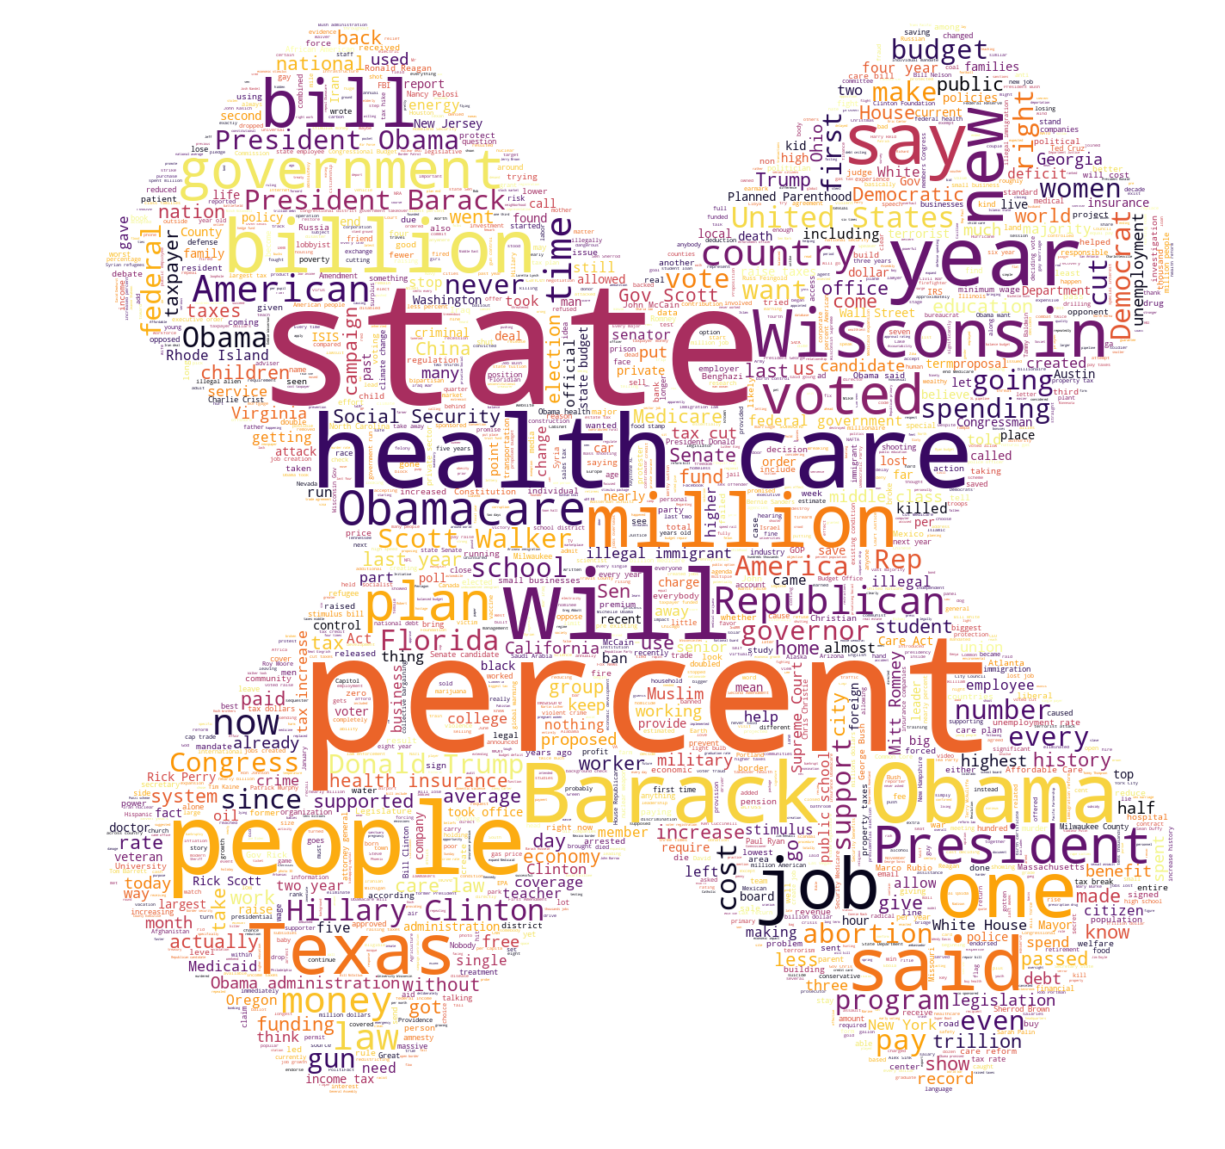

In [718]:
lies = df.loc[df['lie']==1]

wc = WordCloud(background_color='white',max_words=2000,mask=cross_mask,colormap='inferno',stopwords=stopwords).generate(' '.join(lies['new_statement']))

wc.to_file('liesWC.png')

plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

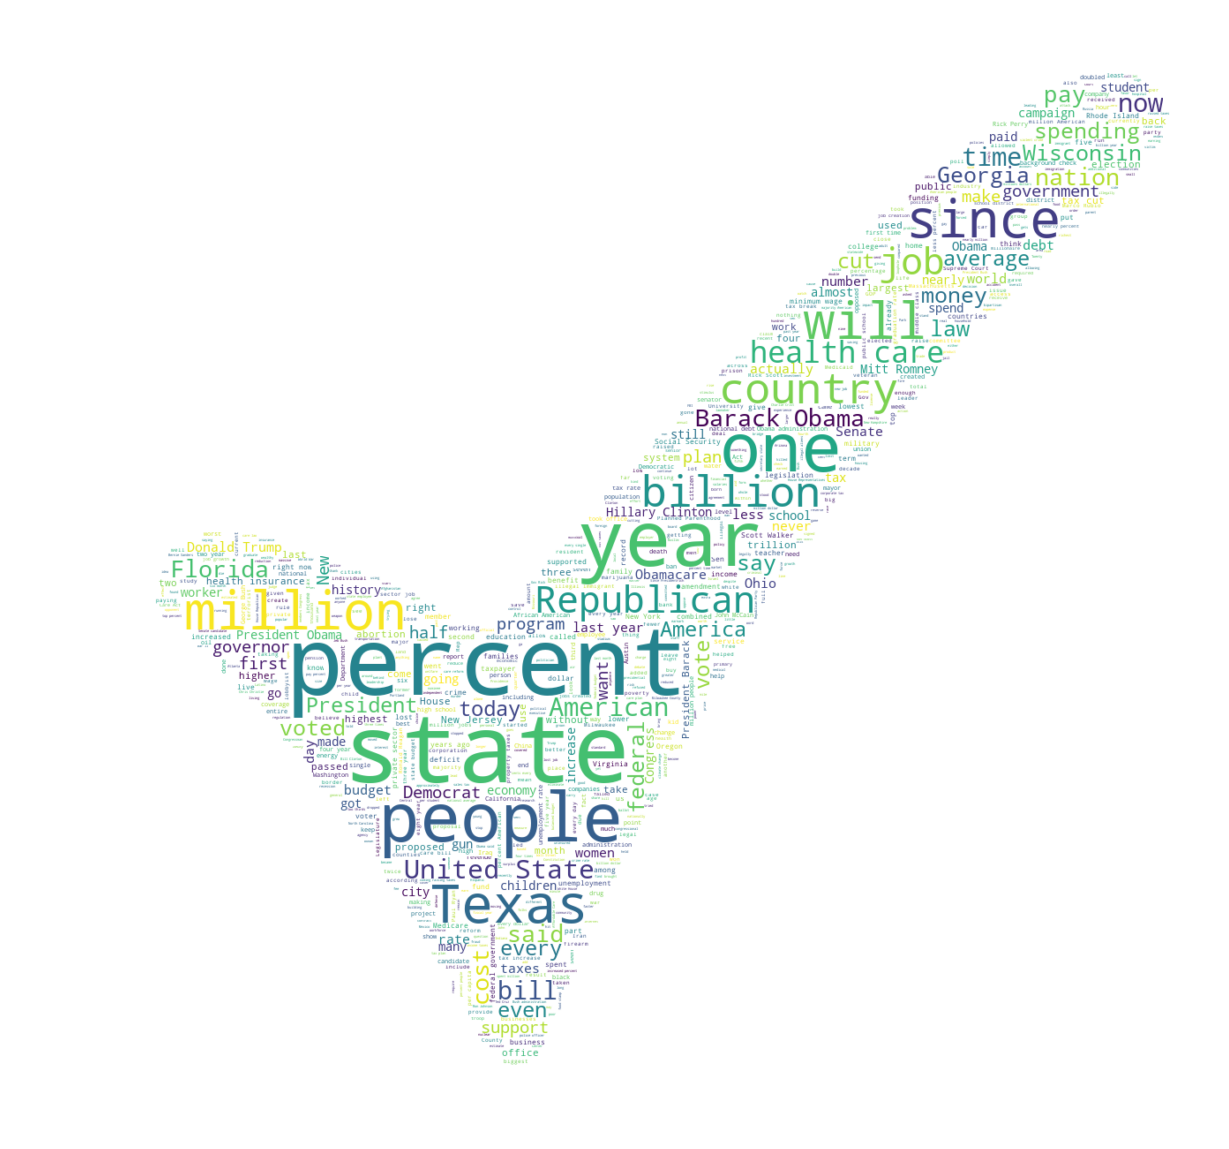

In [719]:
truths = df.loc[df['lie']==0]

wc2 = WordCloud(background_color='white',max_words=2000,mask=tick_mask,colormap='viridis',stopwords=stopwords).generate(' '.join(truths['new_statement']))

wc2.to_file('truthsWC.png')

plt.figure(figsize=[10,10])
plt.imshow(wc2, interpolation='bilinear')
plt.axis("off")
plt.show()

Obviously, a lot of the words are in common still between the lies and the truths.  

That being said, there are some observations we can pull out:
- Some of the top features in the 'true' statements are a little bit more technical sounding than their counterparts in the 'lie' statements: for example, 'federal', 'budget', 'supreme court', 'national debt', 'federal government', 'african american', 'private sector jobs','percent income earners','universal healthcare'
- Some of the top features in the 'lie' statements seem a little more emotional or focused on different topics -- healthcare comes up a lot in both, but seems to feature more prominently in untrue statements.  Features that come up in lies but not really in truths include 'tax increase', 'illegal immigrants','government takeover health','barack hussein obama', and 'socialists openly serving'.
- Some people turn up more in the lies - there are an awful lot of untrue statements about Barack Obama for example (along with lots of true ones), and Clinton turns up more prominently in the lie statements (ie there are a lot of false statements about Clinton).

In [720]:
#a lot of the above words are actually the same, like 'state' and 'states'
#I'm going to try a stemmer to fix that
from nltk.stem.snowball import SnowballStemmer

def stemmed(x):
    stemmer = SnowballStemmer("english")
    try: 
        stemmed = ' '.join([stemmer.stem(word) for word in x.split(' ')])
    except:
        stemmed = x
    return stemmed

df['new_stemmed'] = df['new_statement'].map(stemmed)

In [721]:
df.head(2)

edition                                          statement statement_type  \
0     Texas  "The attorney general requires that rape victi...          Claim   
1  National  President Clinton "reduced the scale of our mi...          Claim   

                      statement_context                speaker speaker_party  \
0                   in a Web site video  Barbara Ann Radnofsky      Democrat   
1  a Republican debate in Orlando, Fla.            Mitt Romney    Republican   

       speaker_job   subject          ruling       date edition_type  \
0              NaN     Crime  Pants on Fire! 2009-10-22        State   
1  Former governor  Military       Half-True 2007-10-21     National   

  binary_ruling       simple_context simple_job  number_ruling  lie  month  \
0         False  in a Web site video        NaN              5    1     10   
1          True             a debate   Governor              2    0     10   

   year  quarter                                      new_statement  \
0  2009        4  "The attorney general requires that rape victi...   
1  2007        4  President Clinton "reduced the scale of our mi...   

                                         new_stemmed  
0  "the attorney general requir that rape victim ...  
1  presid clinton "reduc the scale of our militar...

In [722]:
def topwordfeatures(numberlist,ngram,topn):
    
    restricteddf = df.loc[df['number_ruling'].isin(numberlist)]
    
    cvec = CountVectorizer(stop_words='english',ngram_range=ngram)
    cvec.fit(restricteddf['new_stemmed'])
    text = cvec.transform(restricteddf['new_stemmed'])
    text = pd.DataFrame(text.todense(),columns=cvec.get_feature_names())
    topnfeatures = text.sum().sort_values(ascending=False)[:topn]
    
    return topnfeatures

top20zeros = topwordfeatures([0],(1,2),20)
top20fives = topwordfeatures([5],(1,2),20)
top20zerosones = topwordfeatures([0,1],(1,2),20)
top20foursfives = topwordfeatures([4,5],(1,2),20)
top20zeros2 = topwordfeatures([0],(2,2),20)
top20fives2 = topwordfeatures([5],(2,2),20)
top20zeros3 = topwordfeatures([0],(3,3),20)
top20fives3 = topwordfeatures([5],(3,3),20)
top20lie = topwordfeatures([3,4,5],(1,2),20)
top20truth = topwordfeatures([0,1,2],(1,2),20)

top20df = pd.DataFrame(columns=['zeros','fives','zeros_ones','fours_fives','zeros_ngram2','fives_ngram2','zeros_ngram3','fives_ngram3','lies','truths'])
top20lists = [top20zeros,top20fives,top20zerosones,top20foursfives,top20zeros2,top20fives2,top20zeros3,top20fives3,top20lie,top20truth]
for top20,col in zip(top20lists,top20df.columns):
    top20 = pd.DataFrame(top20)
    top20.reset_index(inplace=True)
    top20df[col] = top20['index']

top20df

zeros         fives zeros_ones   fours_fives      zeros_ngram2  \
0    percent         obama    percent         obama       health care   
1      state        presid      state         state        unit state   
2       year         state       year           tax      barack obama   
3        tax           tax        tax        presid      donald trump   
4    million        barack    million        health      rhode island   
5       vote  barack obama      obama       percent        new jersey   
6      obama        health       vote          year       mitt romney   
7   american          said      peopl          care       john mccain   
8     nation          care   american          vote          new york   
9     health         trump     nation         peopl      presid obama   
10      sinc          vote     health        barack          year ago   
11       new          year        new   health care  african american   
12       job           new        job  barack obama       nation debt   
13     everi   health care       sinc           new      health insur   
14     peopl       million       rate       million      suprem court   
15      rate         peopl     presid          said   hillari clinton   
16      onli       percent      everi           job         incom tax   
17     feder           say       time          plan      feder govern   
18    presid          plan       onli           law        40 percent   
19       pay       clinton        pay     wisconsin      social secur   

       fives_ngram2         zeros_ngram3              fives_ngram3  \
0      barack obama  presid barack obama       presid barack obama   
1       health care         world war ii           health care law   
2   hillari clinton       new york state          gov scott walker   
3     presid barack     health care plan       presid donald trump   
4      donald trump      health care law           afford care act   
5      presid obama    cent everi dollar       wisconsin gov scott   
6      scott walker       raini day fund           new health care   
7        unit state     romney flip flop        health care reform   
8          care law    presid georg bush         obama health care   
9         gov scott     cut deficit half      govern takeov health   
10       white hous     mitt romney flip       socialist open serv   
11     nanci pelosi  univers health care         sen sherrod brown   
12    presid donald       don ani health        open serv congress   
13      tax increas    privat sector job       largest tax increas   
14      unit states       trump tax plan        takeov health care   
15         year old     john mccain said      michel bachmann said   
16    public school   unit state america    group fund congressman   
17     rhode island     gov scott walker       tax increas history   
18       rick perri     john mccain vote  foreign chines prostitut   
19         ted cruz     donald trump tax       presid obama health   

            lies    truths  
0          obama   percent  
1          state     state  
2            tax      year  
3        percent       tax  
4           year   million  
5         presid     obama  
6         health     peopl  
7           care  american  
8           vote      vote  
9          peopl       job  
10       million    health  
11   health care       new  
12           new    presid  
13        barack      rate  
14  barack obama      sinc  
15          plan    nation  
16          said   billion  
17       billion      time  
18           job     everi  
19           law       cut

I don't think this stemmer has been super useful -- also, why is it turning 'y's to 'i's? I don't understand that behaviour!

In [723]:
#finally, using TextBlob's sentiment analysis to create two new features: 'polarity' and 'subjectivity'
from textblob import TextBlob

def polarity(x):
    x = x.decode('utf-8')
    return TextBlob(x).sentiment.polarity

def subjectivity(x):
    x = x.decode('utf-8')
    return TextBlob(x).sentiment.subjectivity

df['polarity'] = df['new_statement'].map(polarity)
df['subjectivity'] = df['new_statement'].map(subjectivity)

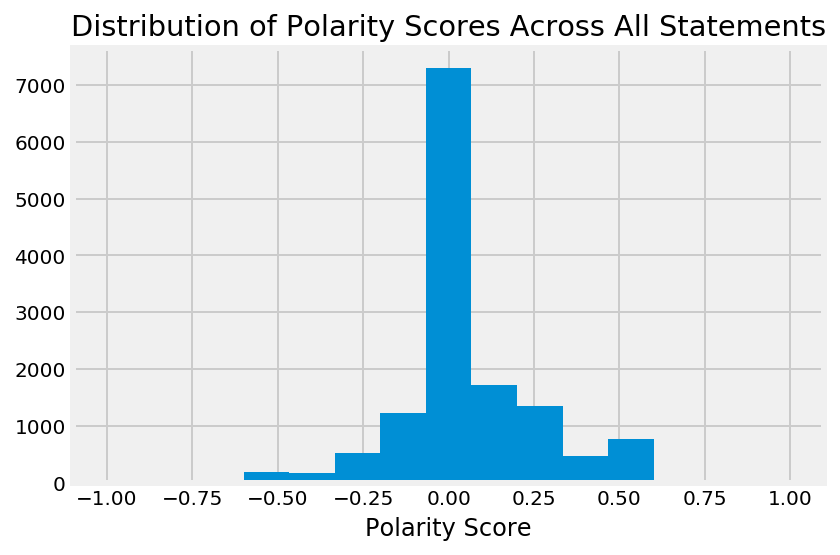

Percentage of Observations with Positive Polarity:  0.363466379
Percentage of Observations with Negative Polarity:  0.191801510248




In [724]:
df.hist('polarity', bins=15)
plt.title('Distribution of Polarity Scores Across All Statements')
plt.xlabel('Polarity Score')
plt.show()
print "Percentage of Observations with Positive Polarity: ", float(len(df.loc[df['polarity']>0.0]))/len(df)
print "Percentage of Observations with Negative Polarity: ", float(len(df.loc[df['polarity']<0.0]))/len(df)
print '\n'

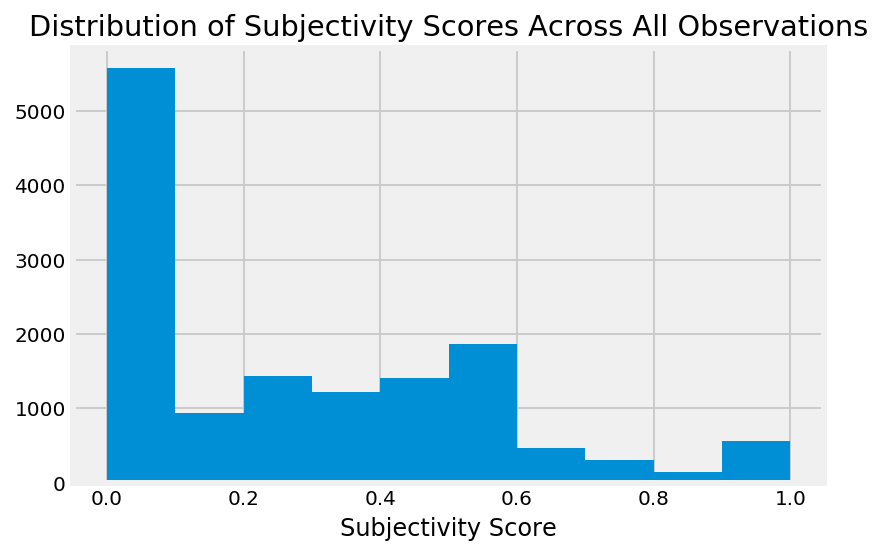

Percentage of Observations with Positive Subjectivity:  0.642502696872


In [725]:
df.hist('subjectivity')
plt.title('Distribution of Subjectivity Scores Across All Observations')
plt.xlabel('Subjectivity Score')
plt.show()
print "Percentage of Observations with Positive Subjectivity: ", float(len(df.loc[df['subjectivity']>0.0]))/len(df)


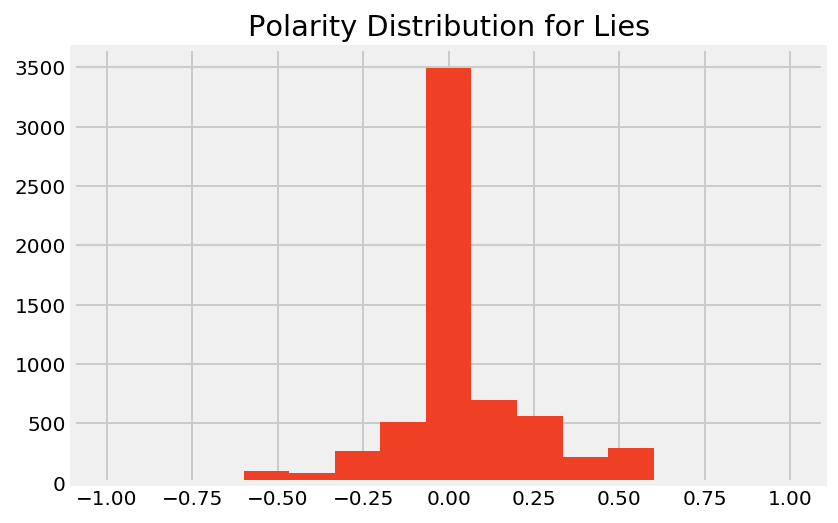

Percentage of Observations with Positive Polarity:  0.330154188523
Percentage of Observations with Negative Polarity:  0.18979494516


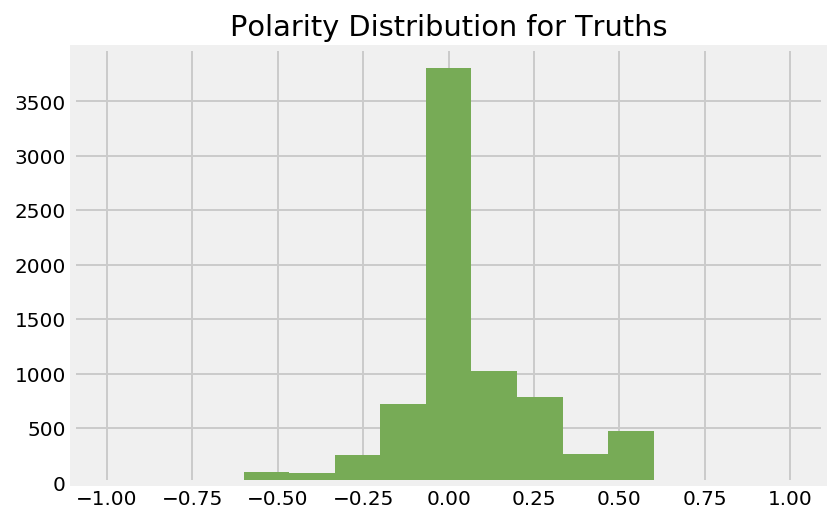

Percentage of Observations with Positive Polarity:  0.390990281061
Percentage of Observations with Negative Polarity:  0.193459416864


In [726]:
lies = df.loc[df['lie']==1]
truths = df.loc[df['lie']==0]

_=lies.hist('polarity',color='xkcd:tomato',bins=15)
plt.title('Polarity Distribution for Lies')
plt.show()
print "Percentage of Observations with Positive Polarity: ", float(len(lies.loc[lies['polarity']>0.0]))/len(lies)
print "Percentage of Observations with Negative Polarity: ", float(len(lies.loc[lies['polarity']<0.0]))/len(lies)


_=truths.hist('polarity',color='xkcd:asparagus',bins=15)
plt.title('Polarity Distribution for Truths')
plt.show()
print "Percentage of Observations with Positive Polarity: ", float(len(truths.loc[truths['polarity']>0.0]))/len(truths)
print "Percentage of Observations with Negative Polarity: ", float(len(truths.loc[truths['polarity']<0.0]))/len(truths)

There aren't any huge differences here?  True statements are slightly more likely to have a positive polarity, but otherwise they're very similar.

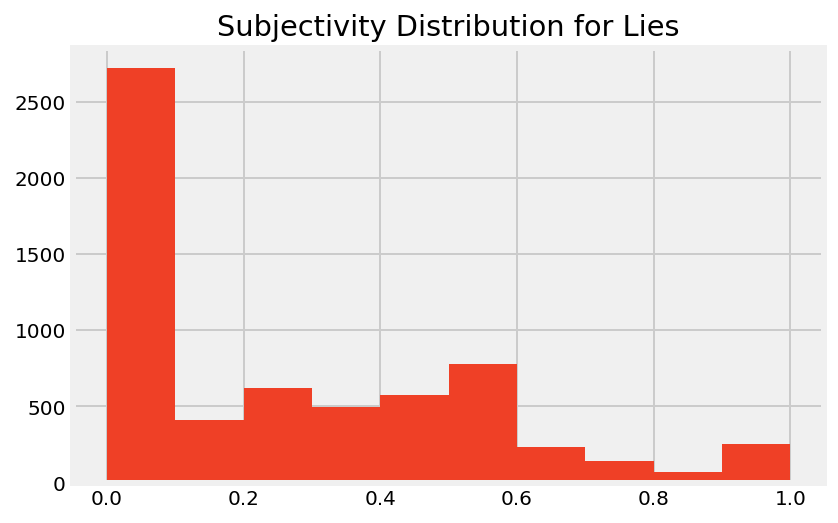

Percentage of Observations with Positive Subjectivity:  0.611031632491




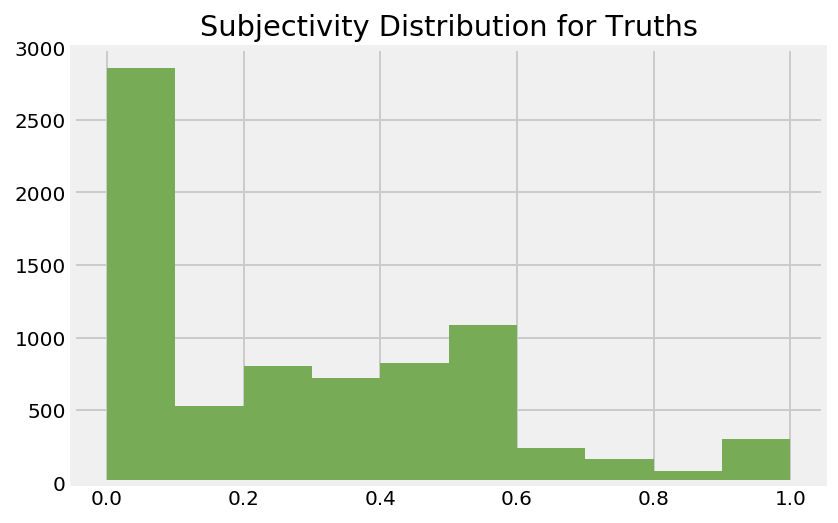

Percentage of Observations with Positive Subjectivity:  0.668505384817


In [727]:
_=lies.hist('subjectivity',color='xkcd:tomato')
plt.title('Subjectivity Distribution for Lies')
plt.show()
print "Percentage of Observations with Positive Subjectivity: ", float(len(lies.loc[lies['subjectivity']>0.0]))/len(lies)
print '\n'
_=truths.hist('subjectivity',color='xkcd:asparagus')
plt.title('Subjectivity Distribution for Truths')
plt.show()
print "Percentage of Observations with Positive Subjectivity: ", float(len(truths.loc[truths['subjectivity']>0.0]))/len(truths)

Truths are somewhat more likely to be subjective than lies?  Which is a little surprising, although I suppose that the more objective a statement is, the more likely it is to be easily identified as a lie or a truth.

In [728]:
df[['subjectivity','number_ruling']].corr(method='spearman')

subjectivity  number_ruling
subjectivity       1.000000      -0.050924
number_ruling     -0.050924       1.000000

In [729]:
df[['polarity','number_ruling']].corr(method='spearman')

polarity  number_ruling
polarity         1.0000        -0.0464
number_ruling   -0.0464         1.0000

The correlation coefficients certainly don't seem to reveal anything particularly interesting.

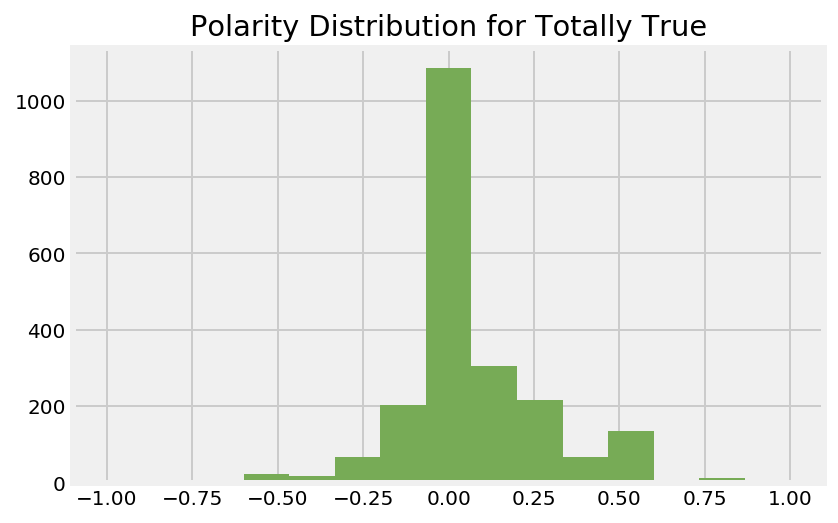

Percentage of Observations with Positive Polarity:  0.399255467659
Percentage of Observations with Negative Polarity:  0.18194509074




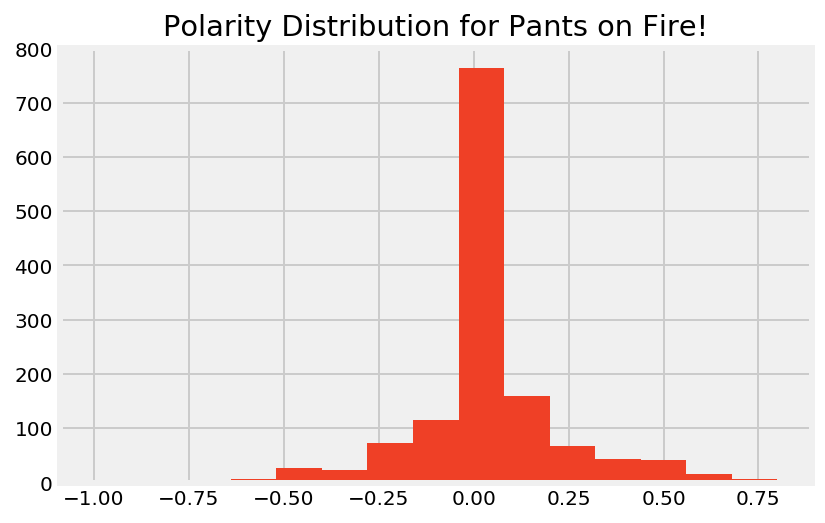

Percentage of Observations with Positive Polarity:  0.296296296296
Percentage of Observations with Negative Polarity:  0.195555555556




In [730]:
zeros = df.loc[df['number_ruling']==0]
fives = df.loc[df['number_ruling']==5]

_=zeros.hist('polarity',bins=15,color='xkcd:asparagus')
plt.title('Polarity Distribution for Totally True')
plt.show()
print "Percentage of Observations with Positive Polarity: ", float(len(zeros.loc[zeros['polarity']>0.0]))/len(zeros)
print "Percentage of Observations with Negative Polarity: ", float(len(zeros.loc[zeros['polarity']<0.0]))/len(zeros)
print '\n'

_=fives.hist('polarity',bins=15,color='xkcd:tomato')
plt.title('Polarity Distribution for Pants on Fire!')
plt.show()
print "Percentage of Observations with Positive Polarity: ", float(len(fives.loc[fives['polarity']>0.0]))/len(fives)
print "Percentage of Observations with Negative Polarity: ", float(len(fives.loc[fives['polarity']<0.0]))/len(fives)
print '\n'

The differences in the distributions are a little bit more dramatic when you look at just the 0s and 5s (the totally True statements versus the Pants on Fire! statements).

True statements are somewhat more likely to have a positive polarity than Pants on Fire statements.

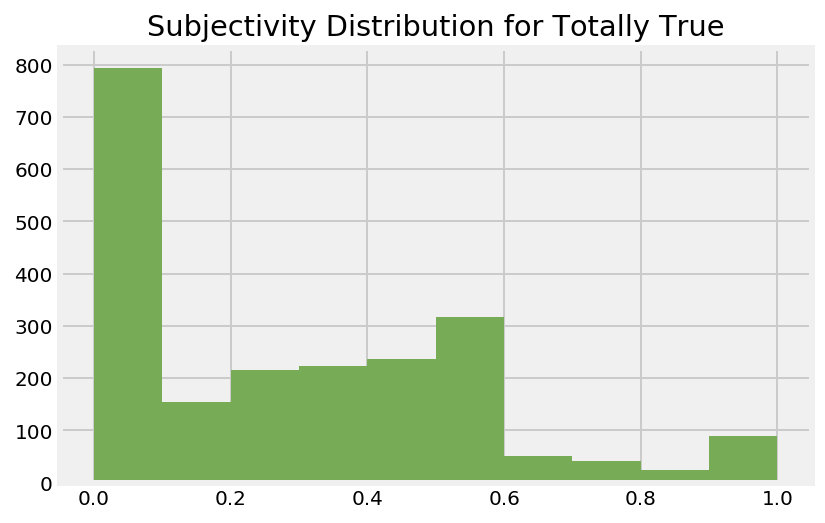

Percentage of Observations with Positive Subjectivity:  0.668683108423




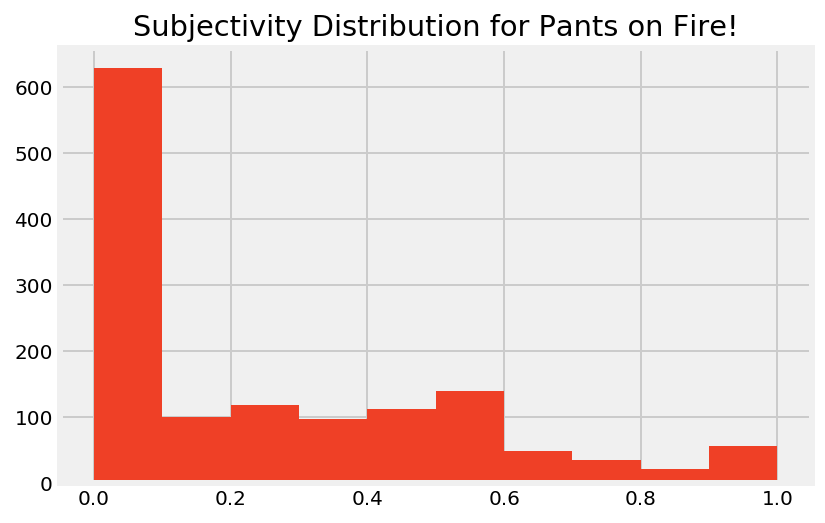

Percentage of Observations with Positive Subjectivity:  0.568148148148


In [731]:
_=zeros.hist('subjectivity',color='xkcd:asparagus')
plt.title('Subjectivity Distribution for Totally True')
plt.show()
print "Percentage of Observations with Positive Subjectivity: ", float(len(zeros.loc[zeros['subjectivity']>0.0]))/len(zeros)
print '\n'

_=fives.hist('subjectivity',color='xkcd:tomato')
plt.title('Subjectivity Distribution for Pants on Fire!')
plt.show()
print "Percentage of Observations with Positive Subjectivity: ", float(len(fives.loc[fives['subjectivity']>0.0]))/len(fives)


Again, the differences here are clearer: totally True statements are somewhat more likely to be subjective than Pants on Fire statements.

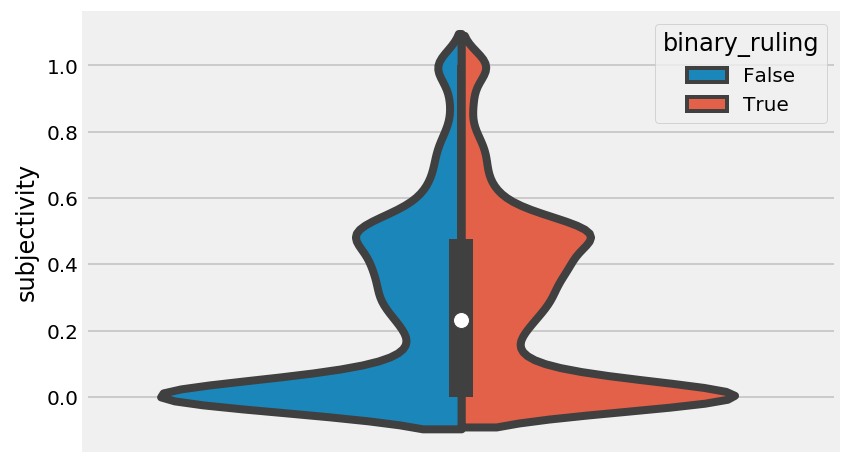

In [732]:
#just to compare the distributions for the binary false vs true
#we can see that side by side these distributions are tremendously similar
import seaborn as sns

df["all"] = ""
ax = sns.violinplot(x="all", y="subjectivity", hue="binary_ruling", data=df, split=True)
ax.set_xlabel("")
plt.show()

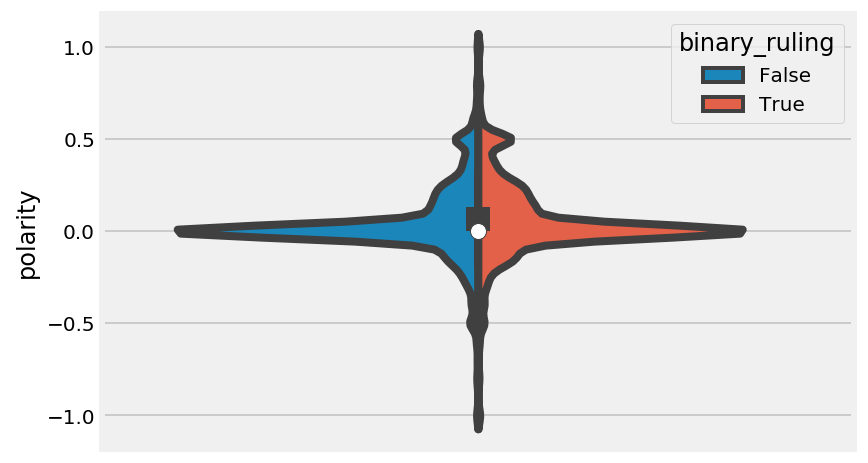

In [733]:
ax = sns.violinplot(x="all", y="polarity", hue="binary_ruling", data=df, split=True)
ax.set_xlabel("")
plt.show()

Finally, I just want to have a look at whether there are any relationships between the complexity of the statement (ie what grade level it is in terms of reading difficulty) and its truthfulness.  I'm not going to dive deep into this feature, but I just want to take a quick look to see if it might be valuable.

In [743]:
from textstat.textstat import textstat

def gradelevel(x):
    x = str(x)
    x = x.decode('unicode_escape').encode('ascii','ignore')
    try: y = textstat.flesch_kincaid_grade(x)
    except: y=np.nan
    return y

df['flesch_kincaid_grade'] = df['new_statement'].map(gradelevel)

def gradelevel2(x):
    x = str(x)
    x = x.decode('unicode_escape').encode('ascii','ignore')
    try: y = textstat.coleman_liau_index(x)
    except: y=np.nan
    return y

df['coleman_liau'] = df['new_statement'].map(gradelevel2)

def gradelevel3(x):
    x = str(x)
    x = x.decode('unicode_escape').encode('ascii','ignore')
    try: y = textstat.dale_chall_readability_score(x)
    except: y=np.nan
    return y

df['dc_readability'] = df['new_statement'].map(gradelevel3)

def gradelevel4(x):
    x = str(x)
    x = x.decode('unicode_escape').encode('ascii','ignore')
    try: y = textstat.automated_readability_index(x)
    except: y=np.nan
    return y

df['automated_readability'] = df['new_statement'].map(gradelevel4)


In [744]:
functionlist = ['mean','median']
trialdf = df.groupby('number_ruling').agg({'flesch_kincaid_grade':functionlist,
                                           'coleman_liau':functionlist,
                                           'dc_readability':functionlist,
                                           'automated_readability':functionlist})
trialdf

automated_readability        dc_readability        coleman_liau  \
                               mean median           mean median         mean   
number_ruling                                                                   
0                         10.549139   10.3       8.607110   8.50    11.797683   
1                         10.829375   10.5       8.699345   8.67    11.942863   
2                         11.194782   11.0       8.882800   8.84    12.235891   
3                         11.128252   10.9       9.040801   8.92    12.418945   
4                         10.887705   10.8       8.956380   8.87    12.347388   
5                         10.987630   10.6       9.257956   9.14    12.777770   

                      flesch_kincaid_grade         
               median                 mean median  
number_ruling                                      
0              11.430             8.214844    8.0  
1              11.580             8.462398    8.3  
2              12.010             8.665995    8.4  
3              12.155             8.582903    8.4  
4              12.010             8.390645    8.2  
5              12.360             8.303778    8.0

In [745]:
df[['number_ruling','flesch_kincaid_grade','coleman_liau','dc_readability','automated_readability']].corr(method='spearman')

number_ruling  flesch_kincaid_grade  coleman_liau  \
number_ruling               1.000000              0.005496      0.068160   
flesch_kincaid_grade        0.005496              1.000000      0.610163   
coleman_liau                0.068160              0.610163      1.000000   
dc_readability              0.082181              0.593636      0.725827   
automated_readability       0.029099              0.876022      0.782950   

                       dc_readability  automated_readability  
number_ruling                0.082181               0.029099  
flesch_kincaid_grade         0.593636               0.876022  
coleman_liau                 0.725827               0.782950  
dc_readability               1.000000               0.577650  
automated_readability        0.577650               1.000000

It's not a super strong correlation for any of these, but they all do use slightly different measures to evaluate text complexity, and all of them end up showing a slight positive correlation between the untruthfulness of a statement and its reading level.  The Dale-Chall readability score is the strongest relationship.  It uses a list of 3000 familiar English words that 80% or more of fourth-graders could reliably understand, and then uses sentence length and the proportion of words not on the list to make a determination about the difficulty of the sentence.

# Progress Report

## Summary of EDA Approach:

What did I do with my data in this notebook?

- Feature creation: I created a variety of new features from the ones that I had in order to facilitate analysis.  For example, I created a ‘number_ruling’ from the ruling feature, and I created new simplified features like ‘lie’ and ‘simplified_job’.  I also performed some NLP feature creation with my 'statement' field, for example evaluating polarity and subjectivity of each statement with TextBlob.

- After that, I performed a lot of comparisons of averages and distributions for number_ruling and lie.  The primary type of chart that I used for this was bar charts and histograms.  The fact that very nearly all of my data is qualitative limits the variety of visualisations and analysis that's possible (but I would love to know if I've missed any interesting approaches to qualitative EDA).

- A huge amount of time was spent really getting to grips with what’s going on in each of the features, especially the actual statements themselves, which turned out to still require quite a bit of cleaning.

## Summary of Findings:

What features look like they may be important for my model?

- Edition or edition_type is definitely a useful feature, if only for ‘Global’ and ‘Media’, but there are also a lot of differences between states. Some of these arise from small sample sizes, but not all of them (for instance, there are big differences between Georgia and Wisconsin, and both of them have over 800 observations).
- Statement_type is useful, too, with ‘Attack’ being clearly less truthful on average than ‘Claim’
- For speaker_party, I will probably just dummify the variable into ‘Republican’, ‘Democrat’, and ‘Other’, although I am dissatisfied with how many speakers have not been characterized by party.
- Statement_context does seem to be pretty important (anonymous things on the internet are WAY more associated with lies than articles or speeches, for example), but there’s such little consistency in the way that it’s been recorded that it won’t be that useful for a lot of the observations.   On the other hand, the issue of anonymity will probably be covered by using ‘speaker’ as a feature, since that also has bloggers, chain email, and facebook posts as options, so leaving out statement_context is probably not a disaster.
- Date doesn’t necessarily seem important until, possibly, the last couple of years; 2017 in particular seems to be characterized by a kind of post-truth environment that suggests we should be more sceptical of recent statements than older statements.  I think I will have a binary variable of ‘After 2016 Election’, or some other sensible cutoff point.
- From my exploration so far, it does seem that the language of the statements will be interesting and useful here, although polarity and subjectivity might not give me anything truly interesting unless I’m restricting my goals to just assessing whether it’s a 0 or a 5 (True or Pants on Fire!). I will also look at using the Dale-Chall readability score, since it seems like it does have some relationship with truthfulness of a sentence.  

## Concerns and Limitations:

A lot of the variables are less useful than they could be because of inconsistency in how the entries are defined (for example, with statement_context), and realistically I think it is going to be extremely time-consuming to fix that in any meaningful sense for most of the data.  I would be very interested in trying to make a ‘political_leaning’ feature for as many speakers as I can, though, but that will have to wait until I know I have several hours to kill on that.

I also still have concerns over the legitimacy of natural language processing when it’s actually a bit of a mix of statements and paraphrasing.  I think I may go back to play around with that if I have time, potentially getting rid of anything that isn't in between quotation marks.

## Next Steps:

The next three things that I need to do are:
- Create a working model from the features that I've identified as being potentially very helpful.  I still feel that I have more to do with my feature cleaning and EDA, but I feel like I've spent about half of my lifetime cleaning and exploring this data, and I want to make sure that my modeling is working before I do anything else.
- Pull ‘subject’ data from API (properly this time!), organize the data, and perform some EDA on it to see whether subject might be helpful.  From the EDA that we did above (and from commonsense), it does seem to make sense to me that some topics would be lightning-rods for lies more than others, so I do want to make sure that I spend time looking at this properly.
- Try to consolidate statement_context a little bit more, so that it can matter for more of the observations than it currently would (since there are way too many unique entries, and lots of different ways of expressing essentially the same thing, eg 'a television ad' versus 'a tv ad')

In terms of polishing my EDA for my final presentation and making it read nicely for anyone looking through my work:
- I'd like to try to use Tableau for some of these visualisations, especially for state differences.  I couldn't get it to work for me when I tried, and I don't want to prioritize it now, but I would like to get it working.
- Within this notebook, I’ve recreated a lot of the same code throughout, mostly for plotting various graphs -- it would be better to write a few different functions to do that (I’ve done that in places where I had the presence of mind to anticipate that I’d be doing the same thing over and over, but for a lot of them, once I’ve done a few of them manually, it seems like more work to go back and write a function instead; I think it would look nice to read though if I smoothed that out).
- EDA for word features was a little rushed (because I ended up finding out that there was still so much cleaning to do, and thinking about how to get around the problem in the way that statements are recorded by Politifact).  I think I should, for example, be using some type of plot to compare difference words’ prominence in different rulings, and I'd also like to use Tfidf Vectorizor in addition to Count Vectorizor to see if that yields any interesting results.
- This notebook represents the actual flow of my work, but that means it’s a little inefficient (so for example, I have two different sets of wordclouds, one set from before I did the cleaning up for ‘says’ and one after).  For clarity’s sake, I’ll want to streamline some of that.



In [746]:
df.drop('all',axis=1,inplace=True)

ValueError: labels ['all'] not contained in axis

In [747]:
df.to_csv('after_eda_df.csv')

## Investigating Subject Now That I Finally Have It!

In [3]:
import pandas as pd
import numpy as np

In [4]:
subjectdf = pd.read_csv('../part-02/df_with_subject',index_col=0)

In [5]:
subjectdf.head(2)

statement                speaker  \
0  "The attorney general requires that rape victi...  Barbara Ann Radnofsky   
1  President Clinton "reduced the scale of our mi...            Mitt Romney   

         date          ruling         subject  Crime  Women  Military  \
0  2009-10-22  Pants on Fire!  [Crime, Women]      1      1         0   
1  2007-10-21       Half-True      [Military]      0      0         1   

   Education  Taxes  ...   Fires  Nightlife  Death Penalty  Food  \
0          0      0  ...       0          0              0     0   
1          0      0  ...       0          0              0     0   

   workers' compensation  Automatic Voter Registration  \
0                      0                             0   
1                      0                             0   

   State government spending  Driver's licenses  Katrina  Iran  
0                          0                  0        0     0  
1                          0                  0        0     0  

[2 rows x 156 columns]

In [6]:
wholedf = pd.read_csv('../part-04/after_eda_df.csv',index_col=0)
wholedf.head()
wholedf.drop('subject',axis=1,inplace=True)

In [7]:
print wholedf.shape
print subjectdf.shape

(13902, 26)
(13902, 156)


In [8]:
bigdf = pd.merge(wholedf,subjectdf,how='inner',on=['statement','date','speaker','ruling'])

In [9]:
bigdf.head(2)

edition                                          statement statement_type  \
0     Texas  "The attorney general requires that rape victi...          Claim   
1  National  President Clinton "reduced the scale of our mi...          Claim   

                      statement_context                speaker speaker_party  \
0                   in a Web site video  Barbara Ann Radnofsky      Democrat   
1  a Republican debate in Orlando, Fla.            Mitt Romney    Republican   

       speaker_job          ruling        date edition_type ...   Fires  \
0              NaN  Pants on Fire!  2009-10-22        State ...       0   
1  Former governor       Half-True  2007-10-21     National ...       0   

  Nightlife Death Penalty  Food  workers' compensation  \
0         0             0     0                      0   
1         0             0     0                      0   

   Automatic Voter Registration  State government spending  Driver's licenses  \
0                             0                          0                  0   
1                             0                          0                  0   

  Katrina Iran  
0       0    0  
1       0    0  

[2 rows x 178 columns]

In [10]:
import string
capitalletters = string.ascii_uppercase

In [11]:
subjectlist = [col for col in bigdf.columns if col[0] in capitalletters]

In [12]:
rulingsbysubjectdf = pd.DataFrame(columns=['proportion_lie',
                                           'average_ruling', 
                                           'count',
                                           'proportion_0', 
                                           'proportion_1',
                                           'proportion_2',
                                           'proportion_3',
                                           'proportion_4',
                                           'proportion_5'])

In [13]:
def fillinrulingsbysubjectdf(subject):
    rulingsbysubjectdf.loc[subject,'proportion_lie'] = bigdf.groupby(subject)['lie'].mean()[1]
    rulingsbysubjectdf.loc[subject,'average_ruling'] = bigdf.groupby(subject)['number_ruling'].mean()[1]
    rulingsbysubjectdf.loc[subject,'count'] = bigdf.groupby(subject)['number_ruling'].count()[1]
    individualrulings = pd.DataFrame(bigdf.groupby(subject)['number_ruling'].value_counts())
    for i in range(0,6):
        try:
            frequency = float(individualrulings.loc[(1,i)][0])
        except:
            frequency = 0.0
        total = bigdf.groupby(subject)['number_ruling'].count()[1]
        proportion = frequency/total
        rulingsbysubjectdf.loc[subject,'proportion_{}'.format(i)] = proportion
    return rulingsbysubjectdf

In [14]:
for sub in subjectlist:
    rulingsbysubjectdf = fillinrulingsbysubjectdf(sub)

In [15]:
rulingsbysubjectdf

proportion_lie average_ruling count  \
Crime                                     0.437216        2.31467   661   
Women                                     0.416961        2.13428   283   
Military                                  0.426108        2.21675   406   
Education                                 0.381288         2.0996   994   
Taxes                                     0.432108        2.27307  1333   
Job Accomplishments                       0.428191        2.28191   376   
Iraq                                       0.38125        2.00625   160   
Economy                                   0.369087        2.06795  1501   
Climate Change                            0.518519        2.48677   189   
Environment                               0.464758        2.38326   454   
Religion                                    0.6875        3.29167   192   
Energy                                    0.478528        2.38855   489   
Abortion                                  0.472727        2.35455   330   
Bush Administration                            0.5        2.27273    44   
Candidate Biography                       0.501211        2.47942   826   
Federal Budget                            0.408996        2.16841   956   
Ethics                                    0.464912        2.41667   228   
Legal Issues                              0.473904        2.31942   479   
Guns                                      0.404922        2.21924   447   
Immigration                               0.495302        2.50067   745   
Elections                                 0.447433         2.3044   818   
Families                                  0.397436        2.03205   156   
Gays and Lesbians                         0.507042        2.50704   142   
Terrorism                                 0.538462        2.59487   390   
Health Care                               0.535149        2.58265  1579   
Foreign Policy                            0.488722        2.43459   665   
Consumer Safety                           0.390244        2.21951    41   
Poverty                                   0.348178        2.05668   247   
Patriotism                                0.702703        3.27027    37   
Baseball                                  0.333333         1.7619    21   
...                                            ...            ...   ...   
New Hampshire 2012                        0.454545        2.35065    77   
Message Machine 2012                      0.504644        2.55418   323   
Sports                                    0.403846        2.20192   104   
Occupy Wall Street                        0.555556        2.77778    18   
PolitiFact's Top Promises                        1              4     1   
Welfare                                   0.394366        2.25352    71   
Congress                                  0.445693        2.29963   267   
Sexuality                                 0.471429        2.45714    70   
Wealth                                    0.384615              2    78   
Lottery                                        0.5            2.5     6   
Tampa Bay 10 News                         0.666667              3     6   
Population                                0.283784        1.64865    74   
Debt                                      0.348387        2.09677   155   
Debates                                   0.468354        2.20253    79   
After the Fact                                 0.8            3.6     5   
Message Machine 2014                      0.589286        2.67857    56   
Ebola                                     0.666667        2.95833    24   
Autism                                        0.75           3.25     4   
Homeless                                         1              4     2   
Fake news                                 0.996324        4.83456   272   
The 2018 California Governor's Race          0.375              2    24   
Fires                                     0.666667        3.6

In [16]:
commonsubjects = rulingsbysubjectdf.loc[rulingsbysubjectdf['count']>=30]
commonsubjects.sort_values('proportion_lie',inplace=True)
commonsubjects

/Users/eleanorkoller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


proportion_lie average_ruling count proportion_0  \
Gambling                        0.230769        1.74359    39     0.153846   
Population                      0.283784        1.64865    74     0.283784   
This Week - ABC News                 0.3          1.875   120     0.183333   
Oil Spill                       0.322581              2    62     0.177419   
Bipartisanship                  0.327586        1.87931   116     0.224138   
County Government               0.328767         2.0411    73     0.205479   
Drugs                           0.330769        1.82308   130     0.269231   
Housing                         0.338983        2.04237   118     0.177966   
Income                          0.345679        1.88477   243      0.17284   
Poverty                         0.348178        2.05668   247     0.133603   
Debt                            0.348387        2.09677   155     0.109677   
Afghanistan                         0.35        1.93333    60     0.283333   
Pensions                            0.35        1.88333    60          0.2   
Bankruptcy                      0.357143         2.2619    42     0.166667   
States                          0.358255        2.04673   321     0.183801   
Redistricting                   0.363636           1.75    44         0.25   
State government spending       0.363636        2.18182    33    0.0606061   
Economy                         0.369087        2.06795  1501     0.173218   
Infrastructure                  0.371795        2.10256    78     0.141026   
Workers                         0.374317        2.01366   366     0.150273   
Trade                           0.378788        2.17424   132     0.128788   
Deficit                         0.380597        2.03358   268     0.227612   
Iraq                             0.38125        2.00625   160       0.2375   
Education                       0.381288         2.0996   994     0.155936   
Wealth                          0.384615              2    78     0.166667   
Criminal Justice                0.385269        2.11615   353     0.161473   
Medicaid                        0.388489        2.05755   139     0.136691   
Consumer Safety                 0.390244        2.21951    41     0.219512   
State Finances                  0.393491        2.16568   338     0.139053   
Welfare                         0.394366        2.25352    71    0.0985915   
...                                  ...            ...   ...          ...   
Candidate Biography             0.501211        2.47942   826     0.145278   
Message Machine 2012            0.504644        2.55418   323    0.0959752   
Gays and Lesbians               0.507042        2.50704   142     0.133803   
Social Security                 0.512346        2.38272   162     0.141975   
Voting Record                   0.514523        2.41079   241     0.124481   
Climate Change                  0.518519        2.48677   189     0.137566   
Regulation                       0.52349        2.44295   149     0.167785   
Unions                          0.524752        2.40594   101     0.128713   
Labor                           0.526104        2.46586   249     0.128514   
Health Care                     0.535149        2.58265  1579     0.112096   
Stimulus                        0.535714        2.65179   224    0.0714286   
Terrorism                       0.538462        2.59487   390     0.133333   
Veterans                        0.539326         2.5618    89     0.157303   
China                           0.539683        2.71429    63    0.0634921   
Nuclear                          0.54023        2.50575    87     0.091954   
Hunger                          0.542857            2.6    35     0.114286   
Food Safety                     0.545455        2.78788    33    0.0909091   
Gas Prices                          0.55           2.55    40          0.1   
Cap and Trade                   0.560976         2.7561    41     0.097561   
Pop Culture                     0.561404        

In [17]:
#The 'fake news' subject is data leakage a bit -- I'm going to drop it entirely. 
commonsubjects.drop('Fake news',inplace=True)
commonsubjects

/Users/eleanorkoller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


proportion_lie average_ruling count proportion_0  \
Gambling                        0.230769        1.74359    39     0.153846   
Population                      0.283784        1.64865    74     0.283784   
This Week - ABC News                 0.3          1.875   120     0.183333   
Oil Spill                       0.322581              2    62     0.177419   
Bipartisanship                  0.327586        1.87931   116     0.224138   
County Government               0.328767         2.0411    73     0.205479   
Drugs                           0.330769        1.82308   130     0.269231   
Housing                         0.338983        2.04237   118     0.177966   
Income                          0.345679        1.88477   243      0.17284   
Poverty                         0.348178        2.05668   247     0.133603   
Debt                            0.348387        2.09677   155     0.109677   
Afghanistan                         0.35        1.93333    60     0.283333   
Pensions                            0.35        1.88333    60          0.2   
Bankruptcy                      0.357143         2.2619    42     0.166667   
States                          0.358255        2.04673   321     0.183801   
Redistricting                   0.363636           1.75    44         0.25   
State government spending       0.363636        2.18182    33    0.0606061   
Economy                         0.369087        2.06795  1501     0.173218   
Infrastructure                  0.371795        2.10256    78     0.141026   
Workers                         0.374317        2.01366   366     0.150273   
Trade                           0.378788        2.17424   132     0.128788   
Deficit                         0.380597        2.03358   268     0.227612   
Iraq                             0.38125        2.00625   160       0.2375   
Education                       0.381288         2.0996   994     0.155936   
Wealth                          0.384615              2    78     0.166667   
Criminal Justice                0.385269        2.11615   353     0.161473   
Medicaid                        0.388489        2.05755   139     0.136691   
Consumer Safety                 0.390244        2.21951    41     0.219512   
State Finances                  0.393491        2.16568   338     0.139053   
Welfare                         0.394366        2.25352    71    0.0985915   
...                                  ...            ...   ...          ...   
Human Rights                         0.5        2.43056    72     0.111111   
Candidate Biography             0.501211        2.47942   826     0.145278   
Message Machine 2012            0.504644        2.55418   323    0.0959752   
Gays and Lesbians               0.507042        2.50704   142     0.133803   
Social Security                 0.512346        2.38272   162     0.141975   
Voting Record                   0.514523        2.41079   241     0.124481   
Climate Change                  0.518519        2.48677   189     0.137566   
Regulation                       0.52349        2.44295   149     0.167785   
Unions                          0.524752        2.40594   101     0.128713   
Labor                           0.526104        2.46586   249     0.128514   
Health Care                     0.535149        2.58265  1579     0.112096   
Stimulus                        0.535714        2.65179   224    0.0714286   
Terrorism                       0.538462        2.59487   390     0.133333   
Veterans                        0.539326         2.5618    89     0.157303   
China                           0.539683        2.71429    63    0.0634921   
Nuclear                          0.54023        2.50575    87     0.091954   
Hunger                          0.542857            2.6    35     0.114286   
Food Safety                     0.545455        2.78788    33    0.0909091   
Gas Prices                          0.55           2.55    40          0.1   
Cap and Trade                   0.560976        

In [85]:
bigdf['lie'].mean()

0.4523809523809524

In [87]:
bigdf['number_ruling'].mean()

2.332542080276219

In [93]:
extremesubjects = commonsubjects.loc[(commonsubjects['proportion_lie']<0.35)|(commonsubjects['proportion_lie']>0.55)|(commonsubjects['average_ruling']<2.15)|(commonsubjects['average_ruling']>2.51)]

In [94]:
extremesubjects

proportion_lie average_ruling count proportion_0  \
Gambling                      0.230769        1.74359    39     0.153846   
Population                    0.283784        1.64865    74     0.283784   
This Week - ABC News               0.3          1.875   120     0.183333   
Oil Spill                     0.322581              2    62     0.177419   
Bipartisanship                0.327586        1.87931   116     0.224138   
County Government             0.328767         2.0411    73     0.205479   
Drugs                         0.330769        1.82308   130     0.269231   
Housing                       0.338983        2.04237   118     0.177966   
Income                        0.345679        1.88477   243      0.17284   
Poverty                       0.348178        2.05668   247     0.133603   
Debt                          0.348387        2.09677   155     0.109677   
Afghanistan                       0.35        1.93333    60     0.283333   
Pensions                          0.35        1.88333    60          0.2   
States                        0.358255        2.04673   321     0.183801   
Redistricting                 0.363636           1.75    44         0.25   
Economy                       0.369087        2.06795  1501     0.173218   
Infrastructure                0.371795        2.10256    78     0.141026   
Workers                       0.374317        2.01366   366     0.150273   
Deficit                       0.380597        2.03358   268     0.227612   
Iraq                           0.38125        2.00625   160       0.2375   
Education                     0.381288         2.0996   994     0.155936   
Wealth                        0.384615              2    78     0.166667   
Criminal Justice              0.385269        2.11615   353     0.161473   
Medicaid                      0.388489        2.05755   139     0.136691   
Public Service                0.394737        2.02632    38     0.289474   
Marijuana                     0.395062        2.08642    81     0.197531   
Families                      0.397436        2.03205   156     0.205128   
Tourism                            0.4        2.02857    35     0.285714   
Recreation                    0.411765        1.98039    51     0.372549   
Women                         0.416961        2.13428   283     0.155477   
Public Safety                 0.417112        2.13369   187     0.187166   
Alcohol                       0.439024        1.97561    41     0.268293   
Congressional Rules           0.487179        2.58974    78     0.115385   
Message Machine 2012          0.504644        2.55418   323    0.0959752   
Health Care                   0.535149        2.58265  1579     0.112096   
Stimulus                      0.535714        2.65179   224    0.0714286   
Terrorism                     0.538462        2.59487   390     0.133333   
Veterans                      0.539326         2.5618    89     0.157303   
China                         0.539683        2.71429    63    0.0634921   
Hunger                        0.542857            2.6    35     0.114286   
Food Safety                   0.545455        2.78788    33    0.0909091   
Gas Prices                        0.55           2.55    40          0.1   
Cap and Trade                 0.560976         2.7561    41     0.097561   
Pop Culture                   0.561404        2.70175    57     0.175439   
Islam                           0.5625        2.91667    48       0.0625   
Medicare                      0.565737        2.68924   251    0.0916335   
Israel                        0.568627        2.78431    51    0.0392157   
Privacy                       0.575758        2.84848    33     0.121212   
Message Machine 2014          0.589286        2.67857    56    0.0714286   
Negative Campaigning          0.595745        2.82979    94     0.106383   
Religion                        0.6875        3.29167   192    0.0729167   
Patriotism                    0.702703        3.27027    37     0.108108

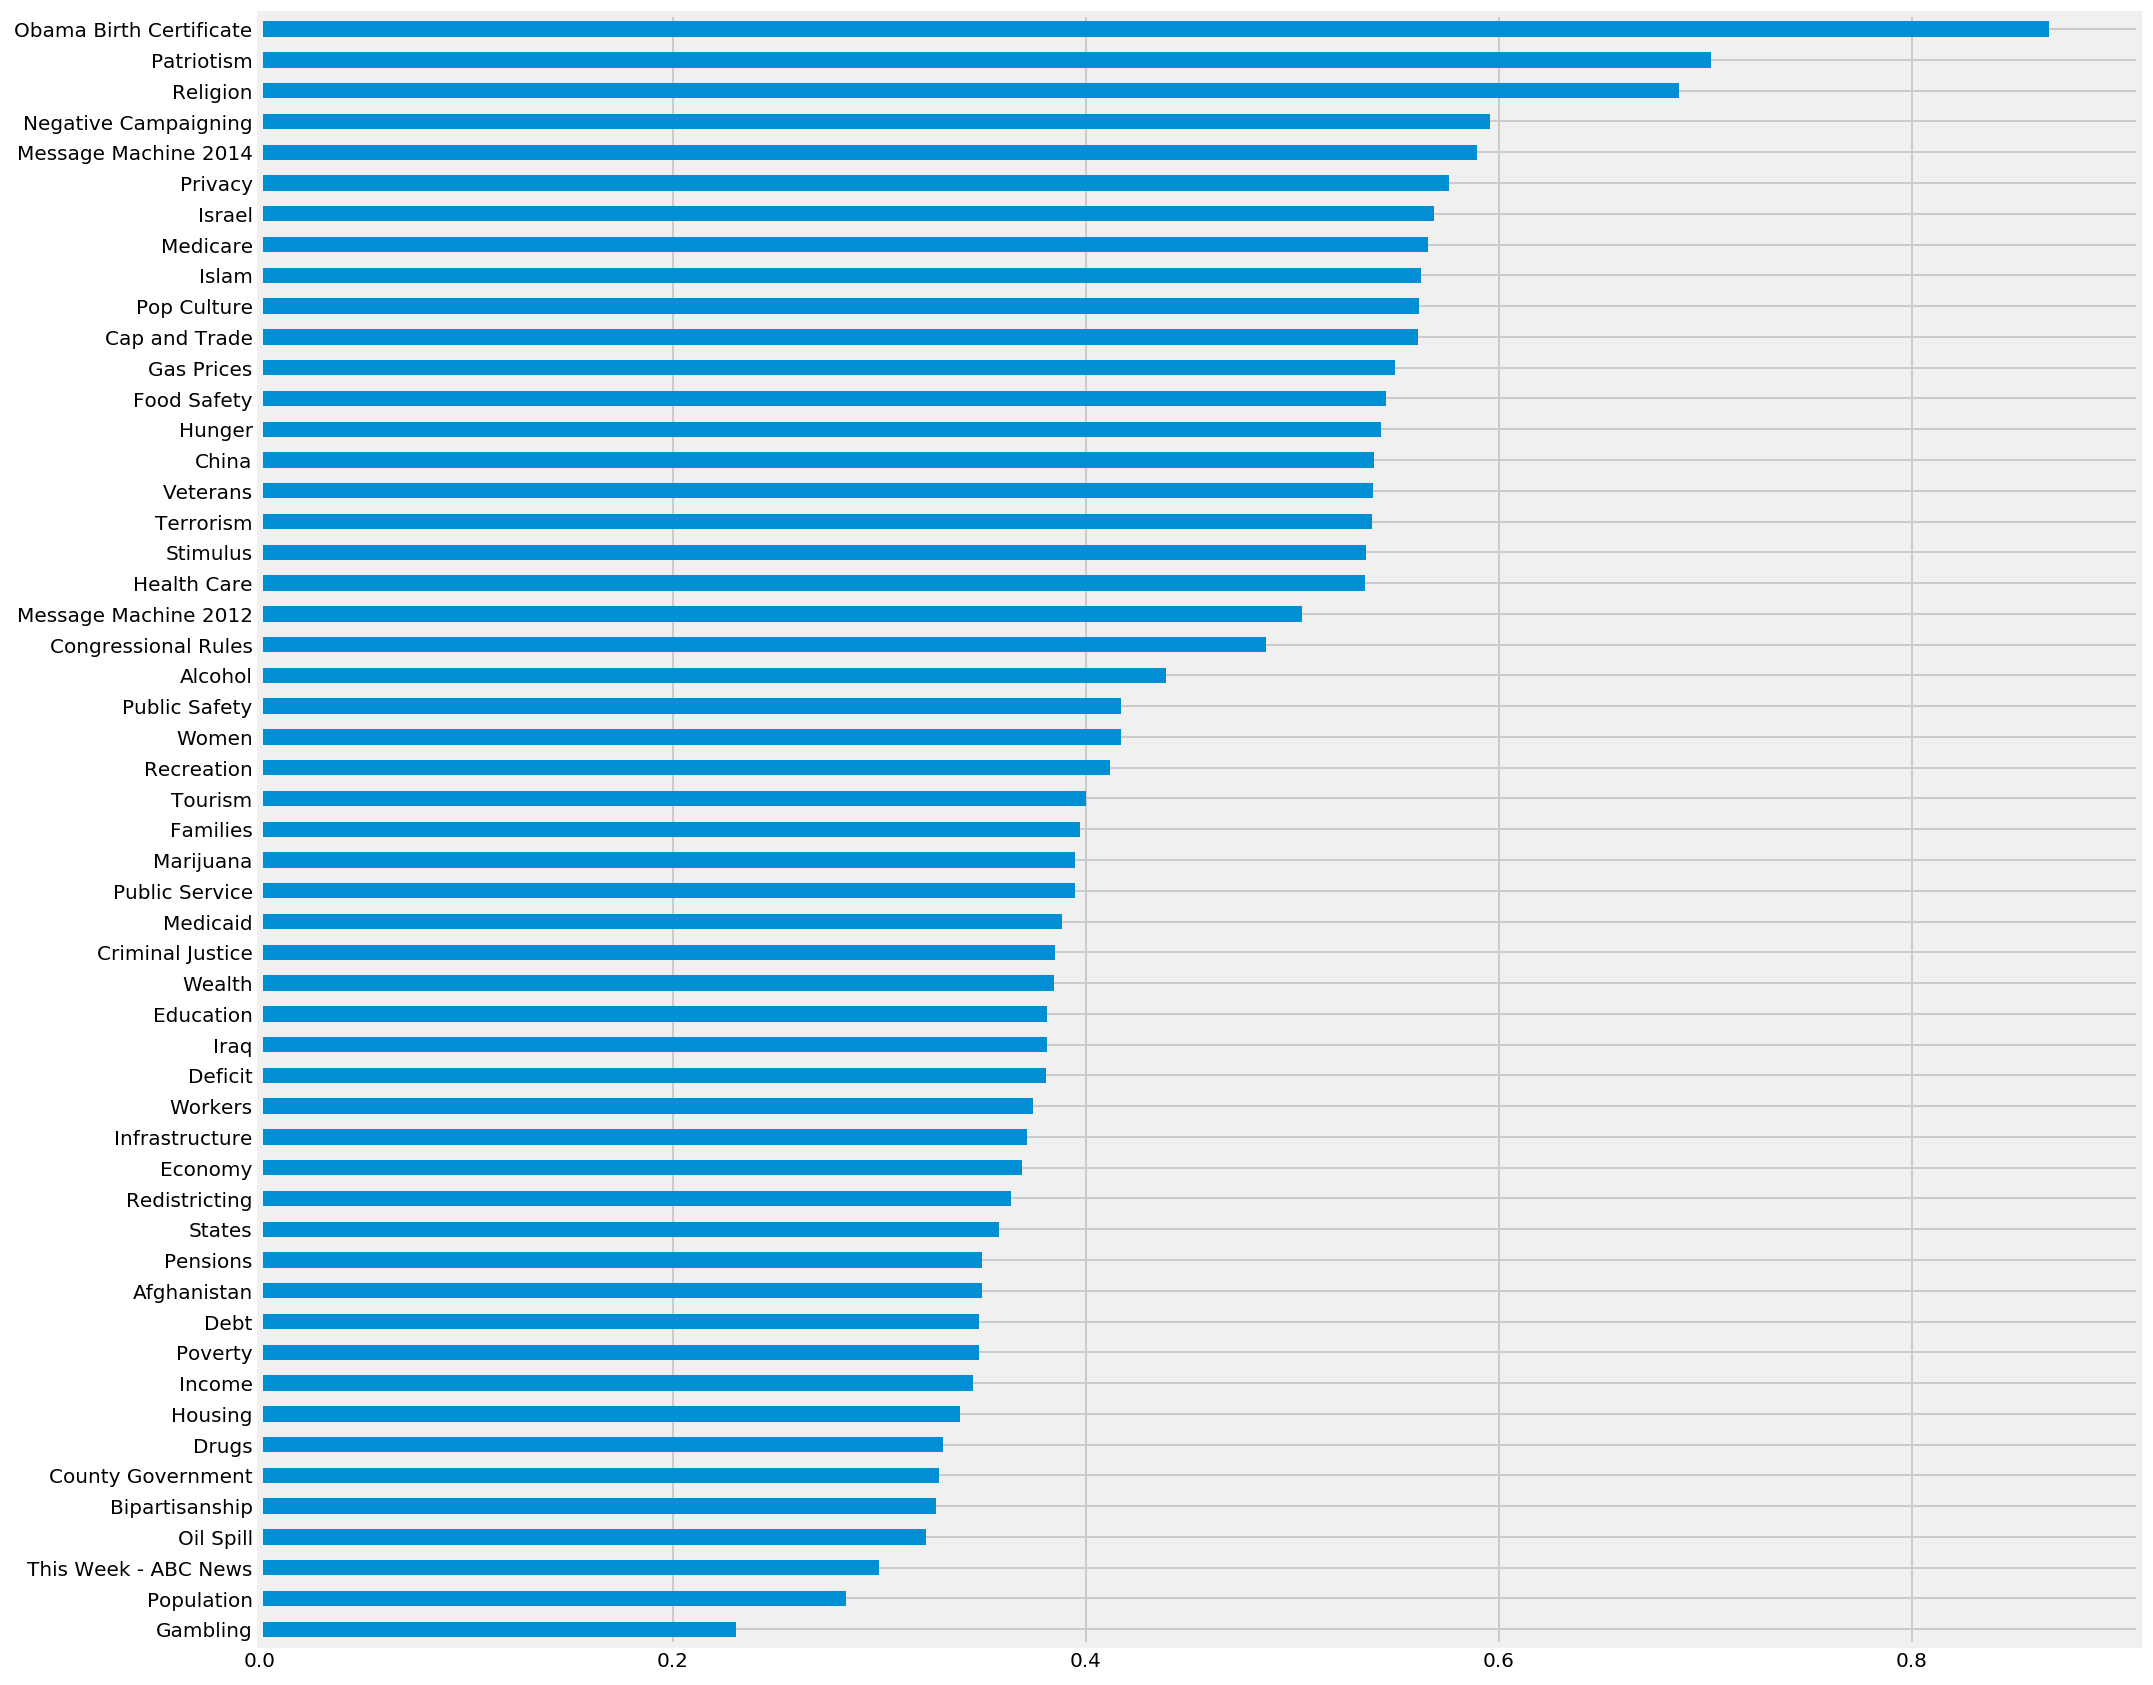

In [97]:
plt.figure(figsize=[15,15])
extremesubjects['proportion_lie'].plot.barh()
plt.show()

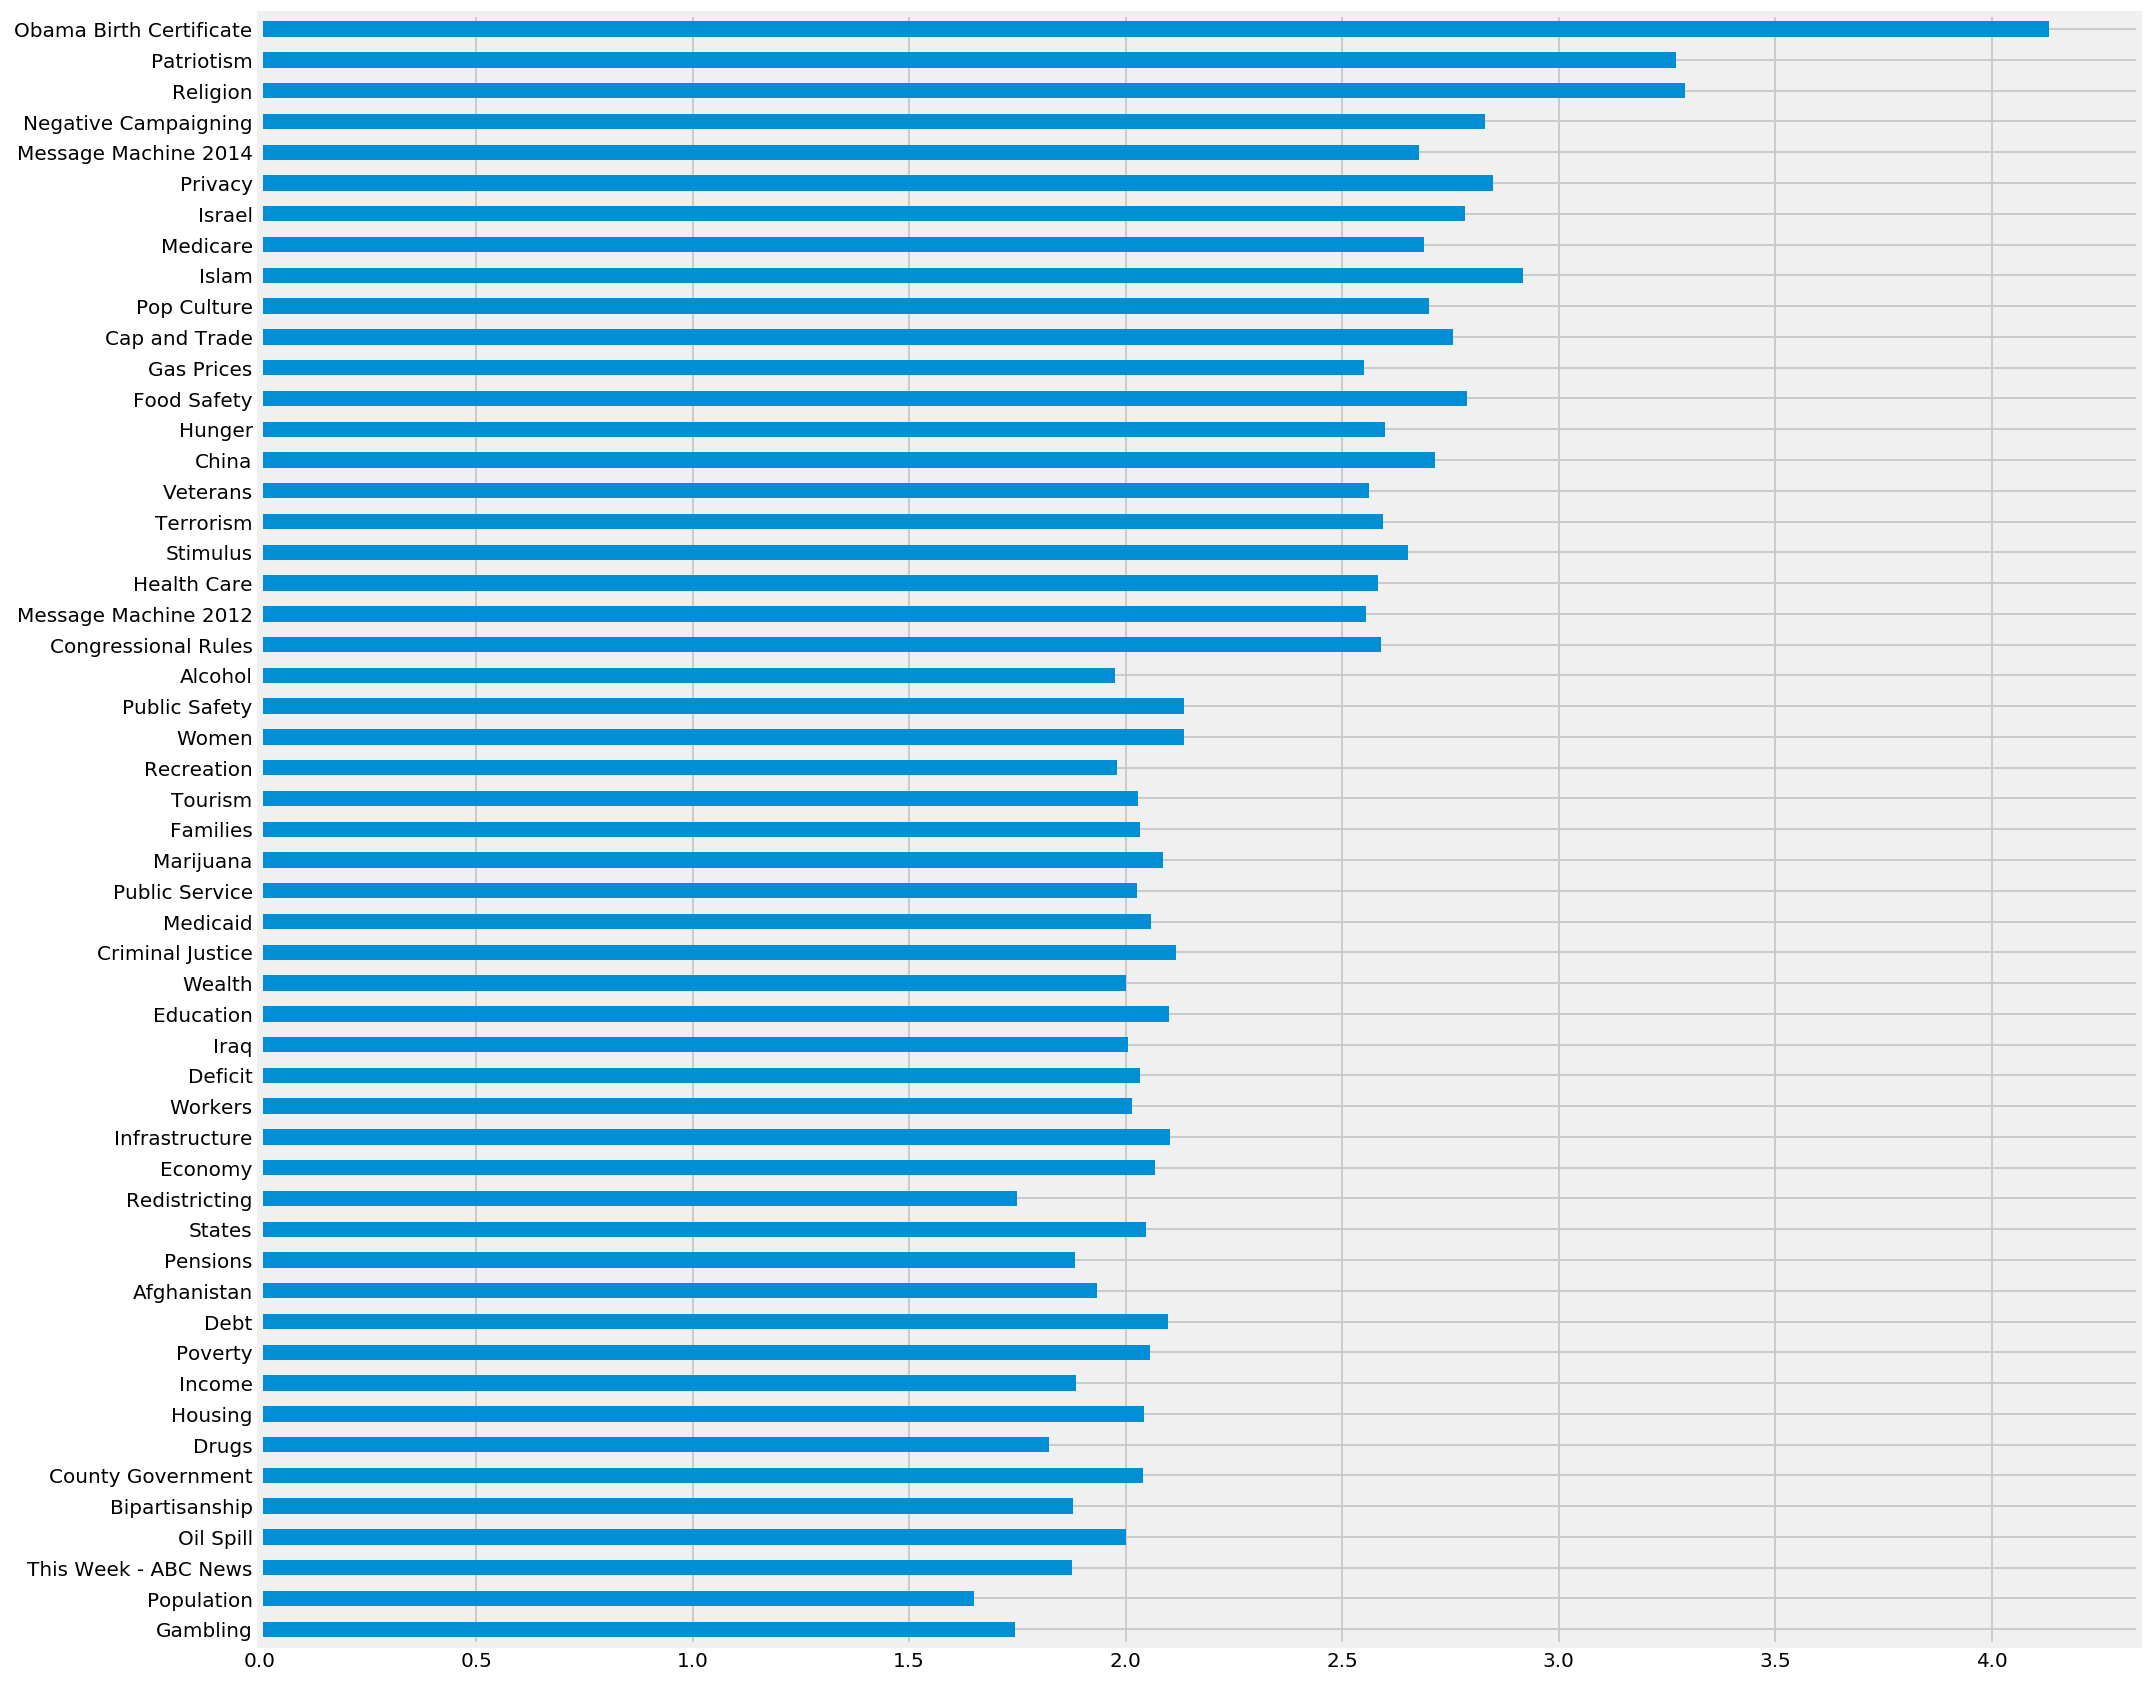

In [98]:
plt.figure(figsize=[15,15])
extremesubjects['average_ruling'].plot.barh()
plt.show()

In [99]:
commonsubjects.to_csv('rulingsbycommonsubjects.csv')

In [100]:
extremesubjects.to_csv('mostextremesubjects.csv')